# Part 0: Load in Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sbn
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
import localcider
from localcider.sequenceParameters import SequenceParameters
import re
import math
import scipy
from scipy.stats import ks_2samp
from matplotlib.patches import Rectangle
import pathlib
from matplotlib import font_manager
from matplotlib.pyplot import gcf


# Setup the fonts
fonts_path = pathlib.Path.home().joinpath('fonts') # i.e. `~/fonts` (update as needed)
font_filename = 'ARIAL.TTF'
font_path = fonts_path.joinpath(font_filename)
print(font_path)

font_manager.fontManager.addfont(str(font_path))
prop = font_manager.FontProperties(fname=font_path)

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = prop.get_name()
plt.rcParams['pdf.fonttype'] = 42 # Makes text editiable
plt.rcParams['ps.fonttype'] = 42

COLOR_MAP = dict()
COLOR_MAP['A']         = '#8c8c8c'
COLOR_MAP['CHNQST']    = '#077a15'
COLOR_MAP['DE']        = '#e23a36'
COLOR_MAP['FWY']       = '#f58220'
COLOR_MAP['G']         = '#86bd8d'
COLOR_MAP['ILMV']      = '#231f20'
COLOR_MAP['KR']        = '#1725c2'
COLOR_MAP['P']         = '#c25fc9'


# Using the global color map, we convert the colormap of amino acid
# groups, to a map against individual amino acids. This
# serves as our internal color map which is used for styling.
aacolor_map=dict()
for amino_acids in COLOR_MAP:
    for amino_acid in amino_acids:
        aacolor_map[amino_acid] = COLOR_MAP[amino_acids]

/home/research/kiersten.ruff/fonts/ARIAL.TTF


# Part 1: Load in Data and Map to GIN clusters

## 1.1 - Get full lengths of all human proteins

20882
20882


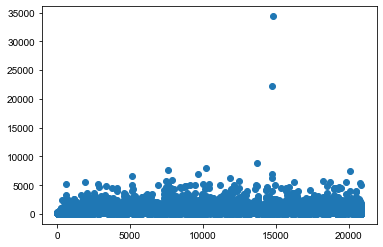

In [2]:
myfile = open('../0_Creating_GIN_Clusters/data/UP000005640_9606.fasta', 'r')
Lines = myfile.readlines()

tmpfullproteinaccs=[]
tmpfullproteinseqs=[]
tmpfullproteinlens=[]
thisseq = ''
for line in Lines:
    
    # remove pesky newline
    cleanline = line.strip()
    
    
    if cleanline[0]=='>':
        tmp=cleanline.split('|')
        tmpfullproteinaccs.append(tmp[1])
        
        # check that this is not the very first sequence, if not 
        # add the sequence
        if (thisseq is not ''): 
            tmpfullproteinseqs.append(thisseq.upper()) 
            tmpfullproteinlens.append(len(thisseq.upper()))

            # reset the sequence for the coming entry
            thisseq = '' 

    # else append the sequence
    else:
        thisseq += cleanline

# store the final sequence	
tmpfullproteinseqs.append(thisseq.upper()) 
tmpfullproteinlens.append(len(thisseq.upper()))

print(len(tmpfullproteinaccs))
print(len(tmpfullproteinseqs))

plt.plot(tmpfullproteinlens,'o')


## Load in All Sapiens Disordered Stretches >=30

In [3]:
speciesname='sapiens'

# Gene names table
mapdf=pd.read_table('../sapiens_uniprot_gene_name.tsv')
accsmap=mapdf['Uniprot'].tolist()
genesmap=mapdf['Gene'].tolist()

fullaccswnums=[]
fullaccs=[]
fullgeneswnums=[]
fullseqs=[]
fullseqlens=[]
fullstpos=[]
fullenpos=[]
fulltermini=[]
fullproteinlength=[]
goodidxs=[]
badidxs=[]

myfile = open('/project/fava/work/kiersten.ruff/For_Vicky/extracting_RRM_information/min_length_30/All/'+speciesname, 'r')
Lines = myfile.readlines()

count=0
for line in Lines:
    count=count+1
    fullline=line.split(" ")
    tmpseq=fullline[3]
    tmpacc=fullline[0]
    tmpst=fullline[1]
    tmpen=fullline[2]
    currseq=tmpseq.strip('\n')
    
    if len(currseq)>=30 and "X" not in currseq and "U" not in currseq and "Z" not in currseq and "J" not in currseq and "B" not in currseq and "O" not in currseq:
        fullaccswnums.append(tmpacc)
        fullseqs.append(currseq)
        tmp=tmpacc.split("_")
        fullaccs.append(tmp[0])
        if tmp[0] in accsmap:
            currgidx=accsmap.index(tmp[0])
            fullgeneswnums.append(genesmap[currgidx]+' IDR'+tmp[1])
        else:
            fullgeneswnums.append(tmp[0]+' IDR'+tmp[1])

        fullseqlens.append(len(currseq))
        fullstpos.append(tmpst)
        fullenpos.append(tmpen)  
        
        # Determine if IDR is within 5 residues of the termini and classify it as N- or C- or Non-terminal
        tmpidx=tmpfullproteinaccs.index(tmp[0])
        currfullproteinlen=tmpfullproteinlens[tmpidx]
        fullproteinlength.append(currfullproteinlen)
        coff=10
        if int(tmpst)<coff and int(tmpen)>currfullproteinlen-coff:
            fulltermini.append('IDR')
        elif int(tmpst)<coff and int(tmpen)<=currfullproteinlen-coff:
            fulltermini.append('N-terminal IDR')
        elif int(tmpst)>=coff and int(tmpen)>currfullproteinlen-coff:
            fulltermini.append('C-terminal IDR')
        else:
            fulltermini.append('Linker IDR')  
            
        goodidxs.append(count)
    else:
        badidxs.append(count)
        
print(len(fullseqs))
print(count)
print(len(goodidxs))
print(badidxs)

print(fullgeneswnums[0:5])
print(fullaccs[0:5])
print(fulltermini[0:5])
print(fullproteinlength[0:5])


24508
24535
24508
[337, 338, 5387, 7965, 8270, 8860, 9309, 13434, 18343, 20894, 20895, 20896, 20897, 20898, 20900, 20901, 20902, 20903, 20904, 20905, 20906, 20907, 20908, 20909, 21628, 22016, 23960]
['KRTAP4-16 IDR1', 'TULP4 IDR1', 'TULP4 IDR2', 'TULP4 IDR3', 'TULP4 IDR4']
['G5E9R7', 'Q9NRJ4', 'Q9NRJ4', 'Q9NRJ4', 'Q9NRJ4']
['C-terminal IDR', 'Linker IDR', 'Linker IDR', 'Linker IDR', 'Linker IDR']
[235, 1543, 1543, 1543, 1543]


## Load in all human IDR z-score data

In [4]:
# make sure features match
myfeat=['pol-pol','pol-hyd','pol-pos','pol-neg','pol-aro','pol-ala','pol-pro','pol-gly','hyd-hyd','hyd-pos','hyd-neg','hyd-aro','hyd-ala','hyd-pro','hyd-gly','pos-pos','pos-neg','pos-aro','pos-ala','pos-pro','pos-gly','neg-neg','neg-aro','neg-ala','neg-pro','neg-gly','aro-aro','aro-ala','aro-pro','aro-gly','ala-ala','ala-pro','ala-gly','pro-pro','pro-gly','gly-gly','Frac A','Frac C','Frac D','Frac E','Frac F','Frac G','Frac H','Frac I','Frac K','Frac L','Frac M','Frac N','Frac P','Frac Q','Frac R','Frac S','Frac T','Frac V','Frac W','Frac Y','Frac K+R','Frac D+E','Frac Polar','Frac Aliphatic','Frac Aromatic','R/K Ratio','E/D Ratio','Frac Chain Expanding','FCR','NCPR','Hydrophobicity','Disorder Promoting','Iso point','PPII','A Patch','C Patch','D Patch','E Patch','F Patch','G Patch','H Patch','I Patch','K Patch','L Patch','M Patch','N Patch','P Patch','Q Patch','R Patch','S Patch','T Patch','V Patch','Y Patch','RG Frac']
print(len(myfeat))

# Load in z-scores for all human IDRs
# Made in /project/fava/work/kiersten.ruff/Collaborations/Su/2023/Library_design/map_clusters_for_all_human_IDRs.ipynb
zvecall=np.load('../sapiens_full_idrome_gte_30_nardini_compositional_RtoK.npy')
print(zvecall.shape)

90
(24508, 90)


## Load in clusters from excel file

In [5]:
numkclusts=30

tmpgenelistclust=[]
tmpacclistbyclust=[]
allgenesIDRnum=[]
allaccsIDRnum=[]
allclusters=[]
for c in range(0,numkclusts):
    tmpdf=pd.read_excel('Test_clusts_IDR_0_100000_kmeans_'+str(numkclusts)+'_clusters.xlsx',sheet_name='cluster_'+str(c))

    tmpgenelistclust.append(tmpdf['Genes'].tolist())
    tmpacclistbyclust.append(tmpdf['Uniprot'].tolist())
    
    tmpgenes=tmpdf['Genes'].tolist()
    tmpaccs=tmpdf['Uniprot'].tolist()
    
    #print('Cluster_'+str(c))
    #print(len(tmpgenes))
    
    for g in range(0,len(tmpgenes)):
        if tmpgenes[g][0]=='*':
            allgenesIDRnum.append(tmpgenes[g][1:])
        else:
            allgenesIDRnum.append(tmpgenes[g])
        allaccsIDRnum.append(tmpaccs[g])
        allclusters.append(c)
        
print(len(allaccsIDRnum))
print(allclusters)
print(allgenesIDRnum)

24508
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

## Get z-score information for just the 100-300 IDRs

In [6]:
zvec100to300=np.zeros((len(allaccsIDRnum),len(myfeat)))
for s in range(0,len(allaccsIDRnum)):
    idx=fullaccswnums.index(allaccsIDRnum[s])
    zvec100to300[s,:]=zvecall[idx,:]
    
print(zvec100to300.shape)
print(zvec100to300[0,:])

(24508, 90)
[-6.45887563  0.         -3.89170269 -5.73524873  0.          0.
  0.         -5.84794449  0.          0.          0.          0.
  0.          0.          0.         -5.20929785 -0.75357312  0.
  0.          0.         -6.4414827   0.65940839  0.          0.
  0.          3.34172163  0.          0.          0.          0.
  0.          0.          0.          0.          0.         -2.3493727
 -0.25363286 -0.58236319  0.0445015  -0.45460923 -0.6098215   0.81328391
  3.03835228 -0.56213492 -0.99730211 -1.49642691 -0.83168432 -0.64496541
 -1.37527832  0.90817026  0.91972256  1.92216358 -0.3808184  -0.56598355
 -0.01951566 -0.11623775 -0.12930148 -0.32693822  2.52783096 -1.77618532
 -0.48287086  3.12865923 -0.40706222 -1.36707768 -0.33068532  0.16218349
 -1.32132469  2.45479516  0.93941589 -1.99718216 -0.26453678 -0.00891408
 -0.17776023 -0.34861861 -0.01188483 -0.18177356 -0.07679037 -0.01093911
 -0.25342933 -0.095519   -0.02644574 -0.0763383  -0.44702141 -0.15973391
 -0.096

## Create z-score arrays that set value to cutoff if above or below

In [7]:
cutoff=3

zvec100to300wcutoff=zvec100to300
for z in range(0,len(zvec100to300wcutoff)):
    pos=[i for i, ltr in enumerate(zvec100to300wcutoff[z,:]) if ltr > cutoff]
    zvec100to300wcutoff[z,pos]=cutoff
    pos=[i for i, ltr in enumerate(zvec100to300wcutoff[z,:]) if ltr < -cutoff]
    zvec100to300wcutoff[z,pos]=-cutoff
    
zvecall_wcutoff=zvecall
for z in range(0,len(zvecall_wcutoff)):
    pos=[i for i, ltr in enumerate(zvecall_wcutoff[z,:]) if ltr > cutoff]
    zvecall_wcutoff[z,pos]=cutoff
    pos=[i for i, ltr in enumerate(zvecall_wcutoff[z,:]) if ltr < -cutoff]
    zvecall_wcutoff[z,pos]=-cutoff

## Get centroids of each cluster

Cluster_0
Cluster_1
Cluster_2
Cluster_3
Cluster_4
Cluster_5
Cluster_6
Cluster_7
Cluster_8
Cluster_9
Cluster_10
Cluster_11
Cluster_12
Cluster_13
Cluster_14
Cluster_15
Cluster_16
Cluster_17
Cluster_18
Cluster_19
Cluster_20
Cluster_21
Cluster_22
Cluster_23
Cluster_24
Cluster_25
Cluster_26
Cluster_27
Cluster_28
Cluster_29
(30, 90)


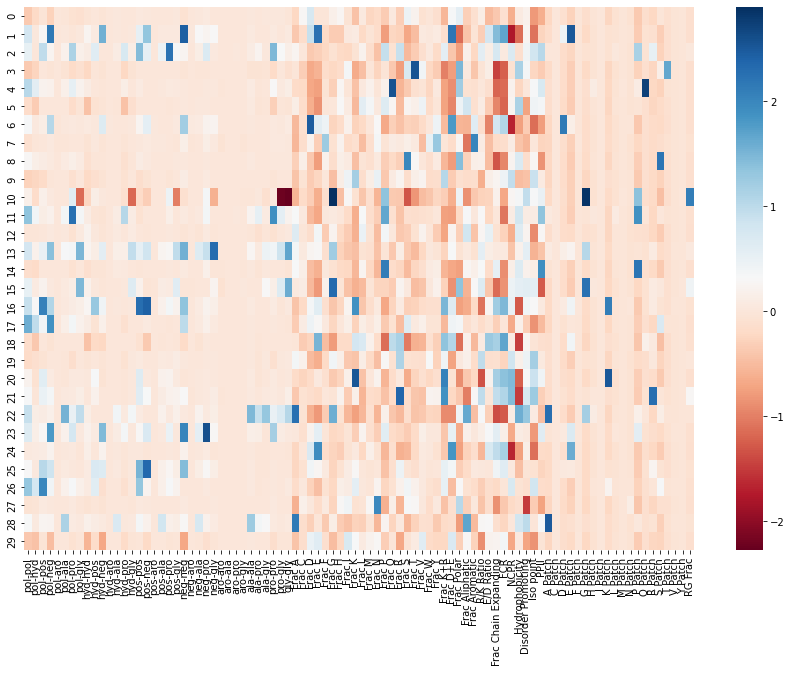

In [8]:
clustcentroids=np.zeros((numkclusts,len(myfeat)))
for c in range(0,numkclusts):
    print('Cluster_'+str(c))
    currclustpos=[x for x, ltr in enumerate(allclusters) if ltr == c]
    
    tmparray=np.zeros((len(currclustpos),len(myfeat)))
    count=-1
    for p in currclustpos:
        count=count+1
        tmparray[count,:]=zvec100to300wcutoff[p,:]
        
    #print(len(np.mean(tmparray, axis=0)))
    clustcentroids[c,:]=np.mean(tmparray, axis=0)

plt.figure(figsize=(15,10))
sbn.heatmap(clustcentroids,cmap='RdBu')
plt.xticks(np.arange(0.5, len(myfeat), 1), myfeat,rotation=90) 

print(clustcentroids.shape)

## Get cluster for all IDRs in human proteome

In [9]:
print(numkclusts)

fullclusternum=[]
fullmininterclustdist=[]
believeclust=[]

count=0
for i in range(0,len(fullseqs)):
    print('Current IDR count: '+str(i))
    
    tmpmeandisttoclust=[]
    for c in range(0,numkclusts):
        azvec=clustcentroids[c,:]
        bzvec=zvecall_wcutoff[i,:]
        tmpdist=np.sum((azvec-bzvec)**2)
        tmpmeandisttoclust.append(tmpdist)
        
    print(fullgeneswnums[i])
    print("Cluster: ", pd.Series(tmpmeandisttoclust).idxmin())
    fullclusternum.append(pd.Series(tmpmeandisttoclust).idxmin())
    
    minval=min(tmpmeandisttoclust)
    tmpdiff=[]
    for m in range(0,len(tmpmeandisttoclust)):
        if tmpmeandisttoclust[m]!=minval:
            tmpdiff.append(tmpmeandisttoclust[m]-minval)
        else:
            tmpdiff.append(100)
    fullmininterclustdist.append(min(tmpdiff))
    print(min(tmpdiff))
  
    if fullaccswnums[i] in allaccsIDRnum:
        count=count+1
        idx=allaccsIDRnum.index(fullaccswnums[i])
        tmpclustnum=allclusters[idx]
        print("K-means Cluster: "+str(tmpclustnum))
        print('Current IDR 100-300 Count: '+str(count))
        if tmpclustnum != fullclusternum[i]:
            print(tmpclustnum)
            print(fullclusternum[i])
            print(tmpmeandisttoclust)
            hi
            
    
    

    

30
Current IDR count: 0
KRTAP4-16 IDR1
Cluster:  14
10.379870436466312
K-means Cluster: 14
Current IDR 100-300 Count: 1
Current IDR count: 1
TULP4 IDR1
Cluster:  9
8.208799780011638
K-means Cluster: 9
Current IDR 100-300 Count: 2
Current IDR count: 2
TULP4 IDR2
Cluster:  11
0.6615453643338469
K-means Cluster: 11
Current IDR 100-300 Count: 3
Current IDR count: 3
TULP4 IDR3
Cluster:  14
13.215543518543797
K-means Cluster: 14
Current IDR 100-300 Count: 4
Current IDR count: 4
TULP4 IDR4
Cluster:  5
7.2462943865307
K-means Cluster: 5
Current IDR 100-300 Count: 5
Current IDR count: 5
TULP4 IDR5
Cluster:  8
9.811378363131709
K-means Cluster: 8
Current IDR 100-300 Count: 6
Current IDR count: 6
TULP4 IDR6
Cluster:  20
15.16643065492903
K-means Cluster: 20
Current IDR 100-300 Count: 7
Current IDR count: 7
TULP4 IDR7
Cluster:  16
11.614747392435419
K-means Cluster: 16
Current IDR 100-300 Count: 8
Current IDR count: 8
PPP4R3B IDR1
Cluster:  1
6.071657700689954
K-means Cluster: 1
Current IDR 100-30

K-means Cluster: 5
Current IDR 100-300 Count: 141
Current IDR count: 141
RTL8C IDR1
Cluster:  15
14.564885782124577
K-means Cluster: 15
Current IDR 100-300 Count: 142
Current IDR count: 142
RFLNA IDR1
Cluster:  12
3.096335921581158
K-means Cluster: 12
Current IDR 100-300 Count: 143
Current IDR count: 143
NPHP1 IDR1
Cluster:  1
7.230899197689997
K-means Cluster: 1
Current IDR 100-300 Count: 144
Current IDR count: 144
NPHP1 IDR2
Cluster:  24
10.646543112227732
K-means Cluster: 24
Current IDR 100-300 Count: 145
Current IDR count: 145
Q6ZTI0 IDR1
Cluster:  11
5.349983200208548
K-means Cluster: 11
Current IDR 100-300 Count: 146
Current IDR count: 146
CASR IDR1
Cluster:  4
14.51768602254782
K-means Cluster: 4
Current IDR 100-300 Count: 147
Current IDR count: 147
CASR IDR2
Cluster:  27
3.877335192937071
K-means Cluster: 27
Current IDR 100-300 Count: 148
Current IDR count: 148
CASR IDR3
Cluster:  13
2.5900388280207594
K-means Cluster: 13
Current IDR 100-300 Count: 149
Current IDR count: 149
Q6

Cluster:  0
2.8464127961262946
K-means Cluster: 0
Current IDR 100-300 Count: 260
Current IDR count: 260
CUEDC1 IDR5
Cluster:  24
6.062816028535124
K-means Cluster: 24
Current IDR 100-300 Count: 261
Current IDR count: 261
SMOX IDR1
Cluster:  13
1.3288236803859874
K-means Cluster: 13
Current IDR 100-300 Count: 262
Current IDR count: 262
SNRK IDR1
Cluster:  5
1.098079853336074
K-means Cluster: 5
Current IDR 100-300 Count: 263
Current IDR count: 263
SNRK IDR2
Cluster:  13
0.8297109765099933
K-means Cluster: 13
Current IDR 100-300 Count: 264
Current IDR count: 264
ADAMTS12 IDR1
Cluster:  3
1.0292011461958097
K-means Cluster: 3
Current IDR 100-300 Count: 265
Current IDR count: 265
ADAMTS12 IDR2
Cluster:  27
2.5773920824851757
K-means Cluster: 27
Current IDR 100-300 Count: 266
Current IDR count: 266
AGAP5 IDR1
Cluster:  8
1.5608443771844271
K-means Cluster: 8
Current IDR 100-300 Count: 267
Current IDR count: 267
AGAP5 IDR2
Cluster:  20
4.461871860061592
K-means Cluster: 20
Current IDR 100-300

K-means Cluster: 14
Current IDR 100-300 Count: 341
Current IDR count: 341
MLXIP IDR4
Cluster:  9
0.42502638530542924
K-means Cluster: 9
Current IDR 100-300 Count: 342
Current IDR count: 342
MLXIP IDR5
Cluster:  5
4.960108226041857
K-means Cluster: 5
Current IDR 100-300 Count: 343
Current IDR count: 343
C1orf159 IDR1
Cluster:  21
6.957725810108833
K-means Cluster: 21
Current IDR 100-300 Count: 344
Current IDR count: 344
TONSL IDR1
Cluster:  1
29.39374017317691
K-means Cluster: 1
Current IDR 100-300 Count: 345
Current IDR count: 345
TONSL IDR2
Cluster:  28
9.252849793758
K-means Cluster: 28
Current IDR 100-300 Count: 346
Current IDR count: 346
TONSL IDR3
Cluster:  2
4.853773052450329
K-means Cluster: 2
Current IDR 100-300 Count: 347
Current IDR count: 347
C1orf147 IDR1
Cluster:  19
5.669720008730845
K-means Cluster: 19
Current IDR 100-300 Count: 348
Current IDR count: 348
POM121 IDR1
Cluster:  14
15.064248693256133
K-means Cluster: 14
Current IDR 100-300 Count: 349
Current IDR count: 349

K-means Cluster: 19
Current IDR 100-300 Count: 431
Current IDR count: 431
TNRC18 IDR5
Cluster:  13
4.716772763933392
K-means Cluster: 13
Current IDR 100-300 Count: 432
Current IDR count: 432
TNRC18 IDR6
Cluster:  28
14.14917158791171
K-means Cluster: 28
Current IDR 100-300 Count: 433
Current IDR count: 433
TNRC18 IDR7
Cluster:  23
11.661686501759768
K-means Cluster: 23
Current IDR 100-300 Count: 434
Current IDR count: 434
TNRC18 IDR8
Cluster:  12
7.645586077001511
K-means Cluster: 12
Current IDR 100-300 Count: 435
Current IDR count: 435
TNRC18 IDR9
Cluster:  12
7.479335050357779
K-means Cluster: 12
Current IDR 100-300 Count: 436
Current IDR count: 436
TNRC18 IDR10
Cluster:  25
8.068659327888703
K-means Cluster: 25
Current IDR 100-300 Count: 437
Current IDR count: 437
TNRC18 IDR11
Cluster:  25
14.325398500436698
K-means Cluster: 25
Current IDR 100-300 Count: 438
Current IDR count: 438
TNRC18 IDR12
Cluster:  16
1.3822813238797167
K-means Cluster: 16
Current IDR 100-300 Count: 439
Current

Current IDR count: 526
ZBTB5 IDR3
Cluster:  27
7.026536510568253
K-means Cluster: 27
Current IDR 100-300 Count: 527
Current IDR count: 527
ZBTB5 IDR4
Cluster:  27
0.5618444558877123
K-means Cluster: 27
Current IDR 100-300 Count: 528
Current IDR count: 528
SYNM IDR1
Cluster:  8
7.408352827843622
K-means Cluster: 8
Current IDR 100-300 Count: 529
Current IDR count: 529
SYNM IDR2
Cluster:  18
4.9138128054124195
K-means Cluster: 18
Current IDR 100-300 Count: 530
Current IDR count: 530
SYNM IDR3
Cluster:  0
1.332278517969094
K-means Cluster: 0
Current IDR 100-300 Count: 531
Current IDR count: 531
SYNM IDR4
Cluster:  12
1.042239494386692
K-means Cluster: 12
Current IDR 100-300 Count: 532
Current IDR count: 532
SYNM IDR5
Cluster:  12
0.16170767465252922
K-means Cluster: 12
Current IDR 100-300 Count: 533
Current IDR count: 533
SYNM IDR6
Cluster:  3
4.756675588665111
K-means Cluster: 3
Current IDR 100-300 Count: 534
Current IDR count: 534
SYNM IDR7
Cluster:  0
3.71555577300407
K-means Cluster: 0

Current IDR count: 610
NUP153 IDR2
Cluster:  17
3.0540332062977953
K-means Cluster: 17
Current IDR 100-300 Count: 611
Current IDR count: 611
NUP153 IDR3
Cluster:  17
8.369308335129418
K-means Cluster: 17
Current IDR 100-300 Count: 612
Current IDR count: 612
NUP153 IDR4
Cluster:  7
14.09730597567954
K-means Cluster: 7
Current IDR 100-300 Count: 613
Current IDR count: 613
NUP153 IDR5
Cluster:  13
24.427145408232434
K-means Cluster: 13
Current IDR 100-300 Count: 614
Current IDR count: 614
NUP153 IDR6
Cluster:  8
5.597439374503509
K-means Cluster: 8
Current IDR 100-300 Count: 615
Current IDR count: 615
NUP153 IDR7
Cluster:  8
24.576379466180164
K-means Cluster: 8
Current IDR 100-300 Count: 616
Current IDR count: 616
NUP153 IDR8
Cluster:  7
4.12580299882319
K-means Cluster: 7
Current IDR 100-300 Count: 617
Current IDR count: 617
NUP153 IDR9
Cluster:  8
22.280704805062427
K-means Cluster: 8
Current IDR 100-300 Count: 618
Current IDR count: 618
NUP153 IDR10
Cluster:  8
5.668113914058104
K-mea

Cluster:  1
3.312066724680193
K-means Cluster: 1
Current IDR 100-300 Count: 691
Current IDR count: 691
RYR2 IDR3
Cluster:  24
8.011817020999
K-means Cluster: 24
Current IDR 100-300 Count: 692
Current IDR count: 692
RYR2 IDR4
Cluster:  1
14.629337193818536
K-means Cluster: 1
Current IDR 100-300 Count: 693
Current IDR count: 693
GDF5 IDR1
Cluster:  11
8.156417533558454
K-means Cluster: 11
Current IDR 100-300 Count: 694
Current IDR count: 694
GDF5 IDR2
Cluster:  19
4.250557972735713
K-means Cluster: 19
Current IDR 100-300 Count: 695
Current IDR count: 695
C2CD3 IDR1
Cluster:  26
5.269092343968708
K-means Cluster: 26
Current IDR 100-300 Count: 696
Current IDR count: 696
C2CD3 IDR2
Cluster:  25
2.296527363330352
K-means Cluster: 25
Current IDR 100-300 Count: 697
Current IDR count: 697
C2CD3 IDR3
Cluster:  5
7.5965902239868015
K-means Cluster: 5
Current IDR 100-300 Count: 698
Current IDR count: 698
C2CD3 IDR4
Cluster:  0
6.937623358063128
K-means Cluster: 0
Current IDR 100-300 Count: 699
Cur

Current IDR count: 782
ZNF831 IDR4
Cluster:  28
3.739642145429322
K-means Cluster: 28
Current IDR 100-300 Count: 783
Current IDR count: 783
ZNF831 IDR5
Cluster:  12
2.7941803340010978
K-means Cluster: 12
Current IDR 100-300 Count: 784
Current IDR count: 784
ZNF831 IDR6
Cluster:  28
5.0113221889752815
K-means Cluster: 28
Current IDR 100-300 Count: 785
Current IDR count: 785
ZNF831 IDR7
Cluster:  12
4.66464549833416
K-means Cluster: 12
Current IDR 100-300 Count: 786
Current IDR count: 786
ZNF831 IDR8
Cluster:  11
0.811610083049267
K-means Cluster: 11
Current IDR 100-300 Count: 787
Current IDR count: 787
ZNF831 IDR9
Cluster:  7
1.9471942392628492
K-means Cluster: 7
Current IDR 100-300 Count: 788
Current IDR count: 788
ZNF831 IDR10
Cluster:  26
1.5188279865150491
K-means Cluster: 26
Current IDR 100-300 Count: 789
Current IDR count: 789
ZNF831 IDR11
Cluster:  0
0.6395205083457469
K-means Cluster: 0
Current IDR 100-300 Count: 790
Current IDR count: 790
ZNF831 IDR12
Cluster:  29
1.18094356372

10.118069560885395
K-means Cluster: 22
Current IDR 100-300 Count: 900
Current IDR count: 900
KCNC3 IDR3
Cluster:  11
16.848085519283508
K-means Cluster: 11
Current IDR 100-300 Count: 901
Current IDR count: 901
KCNC3 IDR4
Cluster:  12
1.3098971209680101
K-means Cluster: 12
Current IDR 100-300 Count: 902
Current IDR count: 902
KCNC3 IDR5
Cluster:  14
8.999815295820618
K-means Cluster: 14
Current IDR 100-300 Count: 903
Current IDR count: 903
CDK13 IDR1
Cluster:  2
19.3462466551021
K-means Cluster: 2
Current IDR 100-300 Count: 904
Current IDR count: 904
CDK13 IDR2
Cluster:  26
7.839712875576367
K-means Cluster: 26
Current IDR 100-300 Count: 905
Current IDR count: 905
CDK13 IDR3
Cluster:  9
4.63153712127912
K-means Cluster: 9
Current IDR 100-300 Count: 906
Current IDR count: 906
CDK13 IDR4
Cluster:  25
0.7553705814585214
K-means Cluster: 25
Current IDR 100-300 Count: 907
Current IDR count: 907
CDK13 IDR5
Cluster:  26
1.9652131792545653
K-means Cluster: 26
Current IDR 100-300 Count: 908
Curr

23.61644669694865
K-means Cluster: 4
Current IDR 100-300 Count: 990
Current IDR count: 990
KMT2D IDR10
Cluster:  4
29.926741557310468
K-means Cluster: 4
Current IDR 100-300 Count: 991
Current IDR count: 991
KMT2D IDR11
Cluster:  14
2.6211397016600237
K-means Cluster: 14
Current IDR 100-300 Count: 992
Current IDR count: 992
KMT2D IDR12
Cluster:  9
3.0807936459447305
K-means Cluster: 9
Current IDR 100-300 Count: 993
Current IDR count: 993
KMT2D IDR13
Cluster:  23
9.531446259740598
K-means Cluster: 23
Current IDR 100-300 Count: 994
Current IDR count: 994
KMT2D IDR14
Cluster:  29
1.7996879649006559
K-means Cluster: 29
Current IDR 100-300 Count: 995
Current IDR count: 995
KMT2D IDR15
Cluster:  14
7.886221958317627
K-means Cluster: 14
Current IDR 100-300 Count: 996
Current IDR count: 996
CEP63 IDR1
Cluster:  26
7.574938783764011
K-means Cluster: 26
Current IDR 100-300 Count: 997
Current IDR count: 997
CEP63 IDR2
Cluster:  29
4.589233860579071
K-means Cluster: 29
Current IDR 100-300 Count: 99

K-means Cluster: 17
Current IDR 100-300 Count: 1080
Current IDR count: 1080
RPSA IDR1
Cluster:  12
4.551068838775265
K-means Cluster: 12
Current IDR 100-300 Count: 1081
Current IDR count: 1081
Q6ZS52 IDR1
Cluster:  8
2.9225646812492627
K-means Cluster: 8
Current IDR 100-300 Count: 1082
Current IDR count: 1082
Q6ZS52 IDR2
Cluster:  19
16.987500333440675
K-means Cluster: 19
Current IDR 100-300 Count: 1083
Current IDR count: 1083
PIWIL4 IDR1
Cluster:  5
2.5391088815844682
K-means Cluster: 5
Current IDR 100-300 Count: 1084
Current IDR count: 1084
MAN1C1 IDR1
Cluster:  28
14.314748366280291
K-means Cluster: 28
Current IDR 100-300 Count: 1085
Current IDR count: 1085
PIWIL3 IDR1
Cluster:  2
7.523446693618766
K-means Cluster: 2
Current IDR 100-300 Count: 1086
Current IDR count: 1086
PPAN IDR1
Cluster:  25
2.6550484817665847
K-means Cluster: 25
Current IDR 100-300 Count: 1087
Current IDR count: 1087
FAF2 IDR1
Cluster:  18
10.353607547545877
K-means Cluster: 18
Current IDR 100-300 Count: 1088
Cu

Current IDR 100-300 Count: 1171
Current IDR count: 1171
CCDC159 IDR1
Cluster:  0
5.466677324869327
K-means Cluster: 0
Current IDR 100-300 Count: 1172
Current IDR count: 1172
CCDC159 IDR2
Cluster:  7
1.7990704251476757
K-means Cluster: 7
Current IDR 100-300 Count: 1173
Current IDR count: 1173
S1PR1 IDR1
Cluster:  27
3.1929842987000647
K-means Cluster: 27
Current IDR 100-300 Count: 1174
Current IDR count: 1174
SLC38A4 IDR1
Cluster:  27
3.9602119216038076
K-means Cluster: 27
Current IDR 100-300 Count: 1175
Current IDR count: 1175
USP17L8 IDR1
Cluster:  18
6.175324188886847
K-means Cluster: 18
Current IDR 100-300 Count: 1176
Current IDR count: 1176
USP17L8 IDR2
Cluster:  27
2.8510418799898574
K-means Cluster: 27
Current IDR 100-300 Count: 1177
Current IDR count: 1177
TYROBP IDR1
Cluster:  7
8.424092839195147
K-means Cluster: 7
Current IDR 100-300 Count: 1178
Current IDR count: 1178
CCDC26 IDR1
Cluster:  27
8.28495407230291
K-means Cluster: 27
Current IDR 100-300 Count: 1179
Current IDR cou

CEP120 IDR1
Cluster:  9
3.5479085163474124
K-means Cluster: 9
Current IDR 100-300 Count: 1251
Current IDR count: 1251
FUBP3 IDR1
Cluster:  4
3.7321953498217155
K-means Cluster: 4
Current IDR 100-300 Count: 1252
Current IDR count: 1252
SLC3A2 IDR1
Cluster:  12
2.5541519304212343
K-means Cluster: 12
Current IDR 100-300 Count: 1253
Current IDR count: 1253
GLDC IDR1
Cluster:  15
19.376882500151908
K-means Cluster: 15
Current IDR 100-300 Count: 1254
Current IDR count: 1254
AEN IDR1
Cluster:  2
14.867917026343711
K-means Cluster: 2
Current IDR 100-300 Count: 1255
Current IDR count: 1255
AEN IDR2
Cluster:  7
2.9789750593587385
K-means Cluster: 7
Current IDR 100-300 Count: 1256
Current IDR count: 1256
HOXB9 IDR1
Cluster:  0
0.15454807308243268
K-means Cluster: 0
Current IDR 100-300 Count: 1257
Current IDR count: 1257
HOXB4 IDR1
Cluster:  7
23.356652653725014
K-means Cluster: 7
Current IDR 100-300 Count: 1258
Current IDR count: 1258
HOXB4 IDR2
Cluster:  11
18.667825526687047
K-means Cluster: 11

NAB2 IDR3
Cluster:  12
0.7815172552008889
K-means Cluster: 12
Current IDR 100-300 Count: 1339
Current IDR count: 1339
GPR68 IDR1
Cluster:  12
4.30835326326963
K-means Cluster: 12
Current IDR 100-300 Count: 1340
Current IDR count: 1340
MSMP IDR1
Cluster:  14
11.388703947412328
K-means Cluster: 14
Current IDR 100-300 Count: 1341
Current IDR count: 1341
C1orf122 IDR1
Cluster:  13
0.3752402582949088
K-means Cluster: 13
Current IDR 100-300 Count: 1342
Current IDR count: 1342
C1orf122 IDR2
Cluster:  19
3.4496191632716915
K-means Cluster: 19
Current IDR 100-300 Count: 1343
Current IDR count: 1343
GATA2 IDR1
Cluster:  5
6.9320479755109545
K-means Cluster: 5
Current IDR 100-300 Count: 1344
Current IDR count: 1344
GATA2 IDR2
Cluster:  22
11.374486857413487
K-means Cluster: 22
Current IDR 100-300 Count: 1345
Current IDR count: 1345
GATA2 IDR3
Cluster:  5
4.6632750866150445
K-means Cluster: 5
Current IDR 100-300 Count: 1346
Current IDR count: 1346
CLDN14 IDR1
Cluster:  7
4.2327488562064985
K-means

Current IDR 100-300 Count: 1444
Current IDR count: 1444
BICDL2 IDR1
Cluster:  13
2.6872462694873818
K-means Cluster: 13
Current IDR 100-300 Count: 1445
Current IDR count: 1445
BICDL2 IDR2
Cluster:  25
7.964194922623076
K-means Cluster: 25
Current IDR 100-300 Count: 1446
Current IDR count: 1446
BICDL2 IDR3
Cluster:  19
4.425560321086532
K-means Cluster: 19
Current IDR 100-300 Count: 1447
Current IDR count: 1447
REEP4 IDR1
Cluster:  25
8.075413639109527
K-means Cluster: 25
Current IDR 100-300 Count: 1448
Current IDR count: 1448
PEG10 IDR1
Cluster:  1
10.771978618474748
K-means Cluster: 1
Current IDR 100-300 Count: 1449
Current IDR count: 1449
PEG10 IDR2
Cluster:  28
22.070968391562253
K-means Cluster: 28
Current IDR 100-300 Count: 1450
Current IDR count: 1450
PEG10 IDR3
Cluster:  12
5.426100424740238
K-means Cluster: 12
Current IDR 100-300 Count: 1451
Current IDR count: 1451
RNPEPL1 IDR1
Cluster:  12
4.975165093152956
K-means Cluster: 12
Current IDR 100-300 Count: 1452
Current IDR count:

Cluster:  29
0.6604935924721573
K-means Cluster: 29
Current IDR 100-300 Count: 1542
Current IDR count: 1542
PRDM2 IDR3
Cluster:  25
8.242849183782361
K-means Cluster: 25
Current IDR 100-300 Count: 1543
Current IDR count: 1543
PRDM2 IDR4
Cluster:  26
0.40994045063456497
K-means Cluster: 26
Current IDR 100-300 Count: 1544
Current IDR count: 1544
PRDM2 IDR5
Cluster:  26
1.5761996163743106
K-means Cluster: 26
Current IDR 100-300 Count: 1545
Current IDR count: 1545
PRDM2 IDR6
Cluster:  11
19.34019142138785
K-means Cluster: 11
Current IDR 100-300 Count: 1546
Current IDR count: 1546
PRDM2 IDR7
Cluster:  24
1.953616495382267
K-means Cluster: 24
Current IDR 100-300 Count: 1547
Current IDR count: 1547
PRDM2 IDR8
Cluster:  9
0.28449090184041737
K-means Cluster: 9
Current IDR 100-300 Count: 1548
Current IDR count: 1548
PRDM2 IDR9
Cluster:  9
9.350923430737069
K-means Cluster: 9
Current IDR 100-300 Count: 1549
Current IDR count: 1549
AKAP6 IDR1
Cluster:  12
1.6853305394895628
K-means Cluster: 12
Cu

CHERP IDR2
Cluster:  4
0.5670272470542841
K-means Cluster: 4
Current IDR 100-300 Count: 1654
Current IDR count: 1654
CHERP IDR3
Cluster:  21
24.887193923810138
K-means Cluster: 21
Current IDR 100-300 Count: 1655
Current IDR count: 1655
POLR2A IDR1
Cluster:  8
4.0946308789797285
K-means Cluster: 8
Current IDR 100-300 Count: 1656
Current IDR count: 1656
CALHM1 IDR1
Cluster:  28
19.61971445567844
K-means Cluster: 28
Current IDR 100-300 Count: 1657
Current IDR count: 1657
CALHM1 IDR2
Cluster:  2
1.126376549879005
K-means Cluster: 2
Current IDR 100-300 Count: 1658
Current IDR count: 1658
TNNI3 IDR1
Cluster:  2
7.547802551197464
K-means Cluster: 2
Current IDR 100-300 Count: 1659
Current IDR count: 1659
SGPP2 IDR1
Cluster:  12
12.99672037208677
K-means Cluster: 12
Current IDR 100-300 Count: 1660
Current IDR count: 1660
IL22RA1 IDR1
Cluster:  5
5.390227574209316
K-means Cluster: 5
Current IDR 100-300 Count: 1661
Current IDR count: 1661
IL22RA1 IDR2
Cluster:  0
1.4173087016419483
K-means Cluste

Current IDR 100-300 Count: 1744
Current IDR count: 1744
XRN1 IDR3
Cluster:  9
0.49654671665955874
K-means Cluster: 9
Current IDR 100-300 Count: 1745
Current IDR count: 1745
XRN1 IDR4
Cluster:  8
0.10001669266211266
K-means Cluster: 8
Current IDR 100-300 Count: 1746
Current IDR count: 1746
AVL9 IDR1
Cluster:  29
7.703206578212891
K-means Cluster: 29
Current IDR 100-300 Count: 1747
Current IDR count: 1747
TRAT1 IDR1
Cluster:  16
16.30669057037366
K-means Cluster: 16
Current IDR 100-300 Count: 1748
Current IDR count: 1748
PGAP1 IDR1
Cluster:  9
14.060729905668744
K-means Cluster: 9
Current IDR 100-300 Count: 1749
Current IDR count: 1749
ZHX2 IDR1
Cluster:  29
2.7063748024196137
K-means Cluster: 29
Current IDR 100-300 Count: 1750
Current IDR count: 1750
ZHX2 IDR2
Cluster:  26
4.035835517420949
K-means Cluster: 26
Current IDR 100-300 Count: 1751
Current IDR count: 1751
ZHX2 IDR3
Cluster:  2
9.140441395663586
K-means Cluster: 2
Current IDR 100-300 Count: 1752
Current IDR count: 1752
ZHX2 IDR

Cluster:  19
5.244698990934232
K-means Cluster: 19
Current IDR 100-300 Count: 1826
Current IDR count: 1826
AHRR IDR3
Cluster:  8
5.436620901427137
K-means Cluster: 8
Current IDR 100-300 Count: 1827
Current IDR count: 1827
CREB3L1 IDR1
Cluster:  17
3.6819573823675285
K-means Cluster: 17
Current IDR 100-300 Count: 1828
Current IDR count: 1828
CREB3L1 IDR2
Cluster:  5
3.263377268697777
K-means Cluster: 5
Current IDR 100-300 Count: 1829
Current IDR count: 1829
CREB3L1 IDR3
Cluster:  7
5.557615276103181
K-means Cluster: 7
Current IDR 100-300 Count: 1830
Current IDR count: 1830
HELZ2 IDR1
Cluster:  12
9.238546041950698
K-means Cluster: 12
Current IDR 100-300 Count: 1831
Current IDR count: 1831
HELZ2 IDR2
Cluster:  2
1.128382723259918
K-means Cluster: 2
Current IDR 100-300 Count: 1832
Current IDR count: 1832
HELZ2 IDR3
Cluster:  28
10.819912033224952
K-means Cluster: 28
Current IDR 100-300 Count: 1833
Current IDR count: 1833
DTX3 IDR1
Cluster:  14
8.722315088804905
K-means Cluster: 14
Current

RBM27 IDR6
Cluster:  15
21.371673262272665
K-means Cluster: 15
Current IDR 100-300 Count: 1909
Current IDR count: 1909
RBM27 IDR7
Cluster:  1
16.030294640464128
K-means Cluster: 1
Current IDR 100-300 Count: 1910
Current IDR count: 1910
RUNX1T1 IDR1
Cluster:  3
9.963555287432968
K-means Cluster: 3
Current IDR 100-300 Count: 1911
Current IDR count: 1911
RUNX1T1 IDR2
Cluster:  7
7.253513621357136
K-means Cluster: 7
Current IDR 100-300 Count: 1912
Current IDR count: 1912
RUNX1T1 IDR3
Cluster:  17
7.253312201656108
K-means Cluster: 17
Current IDR 100-300 Count: 1913
Current IDR count: 1913
RUNX1T1 IDR4
Cluster:  3
18.99035760357888
K-means Cluster: 3
Current IDR 100-300 Count: 1914
Current IDR count: 1914
Q5W150 IDR1
Cluster:  14
3.6273481057102472
K-means Cluster: 14
Current IDR 100-300 Count: 1915
Current IDR count: 1915
ODAM IDR1
Cluster:  17
2.2149799369872056
K-means Cluster: 17
Current IDR 100-300 Count: 1916
Current IDR count: 1916
IVNS1ABP IDR1
Cluster:  26
9.365103575492657
K-means

Cluster:  0
2.350934872948841
K-means Cluster: 0
Current IDR 100-300 Count: 1988
Current IDR count: 1988
CABIN1 IDR3
Cluster:  2
4.586170815775635
K-means Cluster: 2
Current IDR 100-300 Count: 1989
Current IDR count: 1989
CABIN1 IDR4
Cluster:  12
2.8063542495607123
K-means Cluster: 12
Current IDR 100-300 Count: 1990
Current IDR count: 1990
B5MDG6 IDR1
Cluster:  26
10.50114145197864
K-means Cluster: 26
Current IDR 100-300 Count: 1991
Current IDR count: 1991
B5MDG6 IDR2
Cluster:  5
1.4574104004082535
K-means Cluster: 5
Current IDR 100-300 Count: 1992
Current IDR count: 1992
B5MDG6 IDR3
Cluster:  22
6.024997202020373
K-means Cluster: 22
Current IDR 100-300 Count: 1993
Current IDR count: 1993
B5MDG6 IDR4
Cluster:  26
3.4416584437197812
K-means Cluster: 26
Current IDR 100-300 Count: 1994
Current IDR count: 1994
MGARP IDR1
Cluster:  29
2.34521574463497
K-means Cluster: 29
Current IDR 100-300 Count: 1995
Current IDR count: 1995
MGARP IDR2
Cluster:  29
8.228303788535126
K-means Cluster: 29
Cur

LFNG IDR1
Cluster:  2
6.988607192839055
K-means Cluster: 2
Current IDR 100-300 Count: 2066
Current IDR count: 2066
KCNH6 IDR1
Cluster:  0
1.100103244971482
K-means Cluster: 0
Current IDR 100-300 Count: 2067
Current IDR count: 2067
KCNH6 IDR2
Cluster:  5
1.0310499168979383
K-means Cluster: 5
Current IDR 100-300 Count: 2068
Current IDR count: 2068
SPTBN4 IDR1
Cluster:  12
11.32744546946131
K-means Cluster: 12
Current IDR 100-300 Count: 2069
Current IDR count: 2069
SPTBN4 IDR2
Cluster:  2
15.038831130754481
K-means Cluster: 2
Current IDR 100-300 Count: 2070
Current IDR count: 2070
SPTBN4 IDR3
Cluster:  21
6.6173712870911885
K-means Cluster: 21
Current IDR 100-300 Count: 2071
Current IDR count: 2071
CARD9 IDR1
Cluster:  25
13.60046706384334
K-means Cluster: 25
Current IDR 100-300 Count: 2072
Current IDR count: 2072
AFAP1L1 IDR1
Cluster:  23
10.313344861782795
K-means Cluster: 23
Current IDR 100-300 Count: 2073
Current IDR count: 2073
AFAP1L1 IDR2
Cluster:  7
1.1605227611994167
K-means Clus

Cluster:  19
8.382673591429572
K-means Cluster: 19
Current IDR 100-300 Count: 2151
Current IDR count: 2151
STAG2 IDR1
Cluster:  16
11.033061390321244
K-means Cluster: 16
Current IDR 100-300 Count: 2152
Current IDR count: 2152
STAG2 IDR2
Cluster:  26
5.587051339297378
K-means Cluster: 26
Current IDR 100-300 Count: 2153
Current IDR count: 2153
STAG2 IDR3
Cluster:  17
1.4932175690078822
K-means Cluster: 17
Current IDR 100-300 Count: 2154
Current IDR count: 2154
METTL14 IDR1
Cluster:  24
10.566170603757255
K-means Cluster: 24
Current IDR 100-300 Count: 2155
Current IDR count: 2155
METTL14 IDR2
Cluster:  15
4.347239923350273
K-means Cluster: 15
Current IDR 100-300 Count: 2156
Current IDR count: 2156
MLH1 IDR1
Cluster:  17
9.890605970714653
K-means Cluster: 17
Current IDR 100-300 Count: 2157
Current IDR count: 2157
H2BC3 IDR1
Cluster:  20
31.991639530792767
K-means Cluster: 20
Current IDR 100-300 Count: 2158
Current IDR count: 2158
OSER1 IDR1
Cluster:  25
3.6636060406789177
K-means Cluster: 

K-means Cluster: 28
Current IDR 100-300 Count: 2233
Current IDR count: 2233
RNF169 IDR3
Cluster:  0
2.7832675383891825
K-means Cluster: 0
Current IDR 100-300 Count: 2234
Current IDR count: 2234
RNF169 IDR4
Cluster:  15
1.4000216985836715
K-means Cluster: 15
Current IDR 100-300 Count: 2235
Current IDR count: 2235
RNF169 IDR5
Cluster:  26
0.7148863768616636
K-means Cluster: 26
Current IDR 100-300 Count: 2236
Current IDR count: 2236
RNF169 IDR6
Cluster:  9
5.6755319167486675
K-means Cluster: 9
Current IDR 100-300 Count: 2237
Current IDR count: 2237
TRIB3 IDR1
Cluster:  2
0.6133983111844614
K-means Cluster: 2
Current IDR 100-300 Count: 2238
Current IDR count: 2238
MCTP1 IDR1
Cluster:  2
1.9258686118169663
K-means Cluster: 2
Current IDR 100-300 Count: 2239
Current IDR count: 2239
STC1 IDR1
Cluster:  9
4.606809149938307
K-means Cluster: 9
Current IDR 100-300 Count: 2240
Current IDR count: 2240
CEP72 IDR1
Cluster:  9
0.7509177323000742
K-means Cluster: 9
Current IDR 100-300 Count: 2241
Curren

9.465542008669516
K-means Cluster: 26
Current IDR 100-300 Count: 2321
Current IDR count: 2321
PRKAB1 IDR1
Cluster:  0
1.9342362746839612
K-means Cluster: 0
Current IDR 100-300 Count: 2322
Current IDR count: 2322
FLACC1 IDR1
Cluster:  5
0.25419287592758977
K-means Cluster: 5
Current IDR 100-300 Count: 2323
Current IDR count: 2323
COL4A1 IDR1
Cluster:  10
61.76404727678536
K-means Cluster: 10
Current IDR 100-300 Count: 2324
Current IDR count: 2324
COL4A1 IDR2
Cluster:  10
46.51809681892772
K-means Cluster: 10
Current IDR 100-300 Count: 2325
Current IDR count: 2325
COL4A1 IDR3
Cluster:  10
61.24449622310681
K-means Cluster: 10
Current IDR 100-300 Count: 2326
Current IDR count: 2326
CAVIN4 IDR1
Cluster:  21
0.9110863368980127
K-means Cluster: 21
Current IDR 100-300 Count: 2327
Current IDR count: 2327
CAVIN4 IDR2
Cluster:  24
8.595319783982944
K-means Cluster: 24
Current IDR 100-300 Count: 2328
Current IDR count: 2328
PLCB2 IDR1
Cluster:  1
11.992636403078624
K-means Cluster: 1
Current IDR 

Cluster:  24
6.746389875815332
K-means Cluster: 24
Current IDR 100-300 Count: 2424
Current IDR count: 2424
YAF2 IDR1
Cluster:  20
1.7595026258506152
K-means Cluster: 20
Current IDR 100-300 Count: 2425
Current IDR count: 2425
YAF2 IDR2
Cluster:  8
8.135532929136915
K-means Cluster: 8
Current IDR 100-300 Count: 2426
Current IDR count: 2426
SLC35F3 IDR1
Cluster:  28
14.724273899297916
K-means Cluster: 28
Current IDR 100-300 Count: 2427
Current IDR count: 2427
SLC35F3 IDR2
Cluster:  21
0.7629377652724827
K-means Cluster: 21
Current IDR 100-300 Count: 2428
Current IDR count: 2428
TIGD4 IDR1
Cluster:  6
17.754345053295857
K-means Cluster: 6
Current IDR 100-300 Count: 2429
Current IDR count: 2429
NOP9 IDR1
Cluster:  19
1.007729727520335
K-means Cluster: 19
Current IDR 100-300 Count: 2430
Current IDR count: 2430
ACRBP IDR1
Cluster:  3
0.43602946669783904
K-means Cluster: 3
Current IDR 100-300 Count: 2431
Current IDR count: 2431
ACRBP IDR2
Cluster:  24
8.869458821227092
K-means Cluster: 24
Curr

Current IDR count: 2558
LILRB5 IDR4
Cluster:  12
8.741340285496364
K-means Cluster: 12
Current IDR 100-300 Count: 2559
Current IDR count: 2559
LILRB3 IDR1
Cluster:  9
4.414634492739189
K-means Cluster: 9
Current IDR 100-300 Count: 2560
Current IDR count: 2560
LILRB3 IDR2
Cluster:  0
1.7626390383054584
K-means Cluster: 0
Current IDR 100-300 Count: 2561
Current IDR count: 2561
SRSF11 IDR1
Cluster:  15
25.896243185264453
K-means Cluster: 15
Current IDR 100-300 Count: 2562
Current IDR count: 2562
SRSF11 IDR2
Cluster:  16
0.8672317460520773
K-means Cluster: 16
Current IDR 100-300 Count: 2563
Current IDR count: 2563
NEIL1 IDR1
Cluster:  16
6.714063819960067
K-means Cluster: 16
Current IDR 100-300 Count: 2564
Current IDR count: 2564
KIF18B IDR1
Cluster:  12
1.5358398080933
K-means Cluster: 12
Current IDR 100-300 Count: 2565
Current IDR count: 2565
KIF18B IDR2
Cluster:  19
0.4364217740412357
K-means Cluster: 19
Current IDR 100-300 Count: 2566
Current IDR count: 2566
KIF18B IDR3
Cluster:  26
6.

Current IDR count: 2671
AAGAB IDR1
Cluster:  0
11.716621561177643
K-means Cluster: 0
Current IDR 100-300 Count: 2672
Current IDR count: 2672
MIXL1 IDR1
Cluster:  11
6.83341441921678
K-means Cluster: 11
Current IDR 100-300 Count: 2673
Current IDR count: 2673
ONECUT1 IDR1
Cluster:  5
1.553704943132857
K-means Cluster: 5
Current IDR 100-300 Count: 2674
Current IDR count: 2674
ONECUT1 IDR2
Cluster:  5
9.579418425063423
K-means Cluster: 5
Current IDR 100-300 Count: 2675
Current IDR count: 2675
ONECUT1 IDR3
Cluster:  8
1.7939626528270196
K-means Cluster: 8
Current IDR 100-300 Count: 2676
Current IDR count: 2676
NFKBIL1 IDR1
Cluster:  21
2.633179348095865
K-means Cluster: 21
Current IDR 100-300 Count: 2677
Current IDR count: 2677
NFKBIL1 IDR2
Cluster:  1
14.530039105964079
K-means Cluster: 1
Current IDR 100-300 Count: 2678
Current IDR count: 2678
NFKBIL1 IDR3
Cluster:  21
2.8678321725698055
K-means Cluster: 21
Current IDR 100-300 Count: 2679
Current IDR count: 2679
EPS15L1 IDR1
Cluster:  8
4.

5.906429177789931
K-means Cluster: 17
Current IDR 100-300 Count: 2750
Current IDR count: 2750
ANK3 IDR17
Cluster:  7
10.538454173822643
K-means Cluster: 7
Current IDR 100-300 Count: 2751
Current IDR count: 2751
ANK3 IDR18
Cluster:  29
4.773059755375865
K-means Cluster: 29
Current IDR 100-300 Count: 2752
Current IDR count: 2752
ANK3 IDR19
Cluster:  27
18.353603445541115
K-means Cluster: 27
Current IDR 100-300 Count: 2753
Current IDR count: 2753
ANK3 IDR20
Cluster:  9
11.485732744353193
K-means Cluster: 9
Current IDR 100-300 Count: 2754
Current IDR count: 2754
ANK3 IDR21
Cluster:  9
0.9721470823566065
K-means Cluster: 9
Current IDR 100-300 Count: 2755
Current IDR count: 2755
ANK3 IDR22
Cluster:  9
1.635526450908099
K-means Cluster: 9
Current IDR 100-300 Count: 2756
Current IDR count: 2756
PYHIN1 IDR1
Cluster:  26
2.3868558732399805
K-means Cluster: 26
Current IDR 100-300 Count: 2757
Current IDR count: 2757
PYHIN1 IDR2
Cluster:  5
3.428557401885474
K-means Cluster: 5
Current IDR 100-300 C

K-means Cluster: 9
Current IDR 100-300 Count: 2859
Current IDR count: 2859
CUX1 IDR5
Cluster:  12
5.663294745345066
K-means Cluster: 12
Current IDR 100-300 Count: 2860
Current IDR count: 2860
CUX1 IDR6
Cluster:  12
4.150145770229635
K-means Cluster: 12
Current IDR 100-300 Count: 2861
Current IDR count: 2861
CUX1 IDR7
Cluster:  0
2.1305780260049296
K-means Cluster: 0
Current IDR 100-300 Count: 2862
Current IDR count: 2862
CUX1 IDR8
Cluster:  26
12.446575199250166
K-means Cluster: 26
Current IDR 100-300 Count: 2863
Current IDR count: 2863
CUX1 IDR9
Cluster:  28
3.3141659574483597
K-means Cluster: 28
Current IDR 100-300 Count: 2864
Current IDR count: 2864
PKD2L2 IDR1
Cluster:  18
8.013854767051317
K-means Cluster: 18
Current IDR 100-300 Count: 2865
Current IDR count: 2865
DLGAP1 IDR1
Cluster:  7
4.111704408567661
K-means Cluster: 7
Current IDR 100-300 Count: 2866
Current IDR count: 2866
DLGAP1 IDR2
Cluster:  25
0.33943413574088765
K-means Cluster: 25
Current IDR 100-300 Count: 2867
Curren

6.907863938393419
K-means Cluster: 15
Current IDR 100-300 Count: 2934
Current IDR count: 2934
UBQLN4 IDR3
Cluster:  3
9.350243239161603
K-means Cluster: 3
Current IDR 100-300 Count: 2935
Current IDR count: 2935
RABGEF1 IDR1
Cluster:  12
4.957972001048919
K-means Cluster: 12
Current IDR 100-300 Count: 2936
Current IDR count: 2936
RABGEF1 IDR2
Cluster:  17
4.762575797541196
K-means Cluster: 17
Current IDR 100-300 Count: 2937
Current IDR count: 2937
RABGEF1 IDR3
Cluster:  11
12.015976534076596
K-means Cluster: 11
Current IDR 100-300 Count: 2938
Current IDR count: 2938
RABGEF1 IDR4
Cluster:  14
1.8076018676293018
K-means Cluster: 14
Current IDR 100-300 Count: 2939
Current IDR count: 2939
SMARCA1 IDR1
Cluster:  28
16.85583549992259
K-means Cluster: 28
Current IDR 100-300 Count: 2940
Current IDR count: 2940
SMARCA1 IDR2
Cluster:  25
5.8391403292994895
K-means Cluster: 25
Current IDR 100-300 Count: 2941
Current IDR count: 2941
SMARCA1 IDR3
Cluster:  24
4.563200031138777
K-means Cluster: 24
Cu

Current IDR 100-300 Count: 3016
Current IDR count: 3016
HOXB2 IDR1
Cluster:  2
3.5569880505981573
K-means Cluster: 2
Current IDR 100-300 Count: 3017
Current IDR count: 3017
HOXB2 IDR2
Cluster:  25
4.788853241353372
K-means Cluster: 25
Current IDR 100-300 Count: 3018
Current IDR count: 3018
HOXB1 IDR1
Cluster:  7
5.993034228581138
K-means Cluster: 7
Current IDR 100-300 Count: 3019
Current IDR count: 3019
HOXB1 IDR2
Cluster:  7
1.6225543542519745
K-means Cluster: 7
Current IDR 100-300 Count: 3020
Current IDR count: 3020
HOXB1 IDR3
Cluster:  2
11.159593209241002
K-means Cluster: 2
Current IDR 100-300 Count: 3021
Current IDR count: 3021
HOXB3 IDR1
Cluster:  15
27.30430312514962
K-means Cluster: 15
Current IDR 100-300 Count: 3022
Current IDR count: 3022
HOXB3 IDR2
Cluster:  7
1.7921620280757224
K-means Cluster: 7
Current IDR 100-300 Count: 3023
Current IDR count: 3023
HOXB3 IDR3
Cluster:  5
4.58563674739565
K-means Cluster: 5
Current IDR 100-300 Count: 3024
Current IDR count: 3024
RNF128 ID

9.280706387963303
K-means Cluster: 24
Current IDR 100-300 Count: 3098
Current IDR count: 3098
CMYA5 IDR7
Cluster:  17
9.876567064885247
K-means Cluster: 17
Current IDR 100-300 Count: 3099
Current IDR count: 3099
CMYA5 IDR8
Cluster:  28
1.91809345809272
K-means Cluster: 28
Current IDR 100-300 Count: 3100
Current IDR count: 3100
CMYA5 IDR9
Cluster:  29
4.919582825080539
K-means Cluster: 29
Current IDR 100-300 Count: 3101
Current IDR count: 3101
CMYA5 IDR10
Cluster:  29
10.904522343748816
K-means Cluster: 29
Current IDR 100-300 Count: 3102
Current IDR count: 3102
CMYA5 IDR11
Cluster:  17
22.873414680693593
K-means Cluster: 17
Current IDR 100-300 Count: 3103
Current IDR count: 3103
CMYA5 IDR12
Cluster:  29
3.1942427372437443
K-means Cluster: 29
Current IDR 100-300 Count: 3104
Current IDR count: 3104
CMYA5 IDR13
Cluster:  29
8.03860630764703
K-means Cluster: 29
Current IDR 100-300 Count: 3105
Current IDR count: 3105
CMYA5 IDR14
Cluster:  29
2.230050861129836
K-means Cluster: 29
Current IDR 

Current IDR 100-300 Count: 3205
Current IDR count: 3205
RSPRY1 IDR1
Cluster:  21
4.123712824821887
K-means Cluster: 21
Current IDR 100-300 Count: 3206
Current IDR count: 3206
SLC26A2 IDR1
Cluster:  0
4.7798754454838885
K-means Cluster: 0
Current IDR 100-300 Count: 3207
Current IDR count: 3207
LLGL1 IDR1
Cluster:  28
9.451458377765789
K-means Cluster: 28
Current IDR 100-300 Count: 3208
Current IDR count: 3208
LLGL1 IDR2
Cluster:  3
2.31983103818936
K-means Cluster: 3
Current IDR 100-300 Count: 3209
Current IDR count: 3209
C11orf52 IDR1
Cluster:  4
9.245669055712252
K-means Cluster: 4
Current IDR 100-300 Count: 3210
Current IDR count: 3210
GALNT6 IDR1
Cluster:  7
13.017881193946998
K-means Cluster: 7
Current IDR 100-300 Count: 3211
Current IDR count: 3211
SYCP2L IDR1
Cluster:  24
9.294455199104462
K-means Cluster: 24
Current IDR 100-300 Count: 3212
Current IDR count: 3212
SYCP2L IDR2
Cluster:  17
5.270179836273231
K-means Cluster: 17
Current IDR 100-300 Count: 3213
Current IDR count: 321

6.67785477455557
K-means Cluster: 5
Current IDR 100-300 Count: 3352
Current IDR count: 3352
SPAG5 IDR2
Cluster:  17
0.7114891697506422
K-means Cluster: 17
Current IDR 100-300 Count: 3353
Current IDR count: 3353
SPAG5 IDR3
Cluster:  0
1.8860678429952458
K-means Cluster: 0
Current IDR 100-300 Count: 3354
Current IDR count: 3354
SPAG5 IDR4
Cluster:  24
11.684675382927995
K-means Cluster: 24
Current IDR 100-300 Count: 3355
Current IDR count: 3355
SPAG5 IDR5
Cluster:  3
3.6802669312814444
K-means Cluster: 3
Current IDR 100-300 Count: 3356
Current IDR count: 3356
RPS6 IDR1
Cluster:  20
0.14651615767344595
K-means Cluster: 20
Current IDR 100-300 Count: 3357
Current IDR count: 3357
RPS6 IDR2
Cluster:  20
16.254388153496038
K-means Cluster: 20
Current IDR 100-300 Count: 3358
Current IDR count: 3358
CHTF18 IDR1
Cluster:  2
6.076954966901617
K-means Cluster: 2
Current IDR 100-300 Count: 3359
Current IDR count: 3359
CHTF18 IDR2
Cluster:  12
4.990736885551822
K-means Cluster: 12
Current IDR 100-300

K-means Cluster: 5
Current IDR 100-300 Count: 3495
Current IDR count: 3495
SLITRK5 IDR1
Cluster:  7
1.9151804655960518
K-means Cluster: 7
Current IDR 100-300 Count: 3496
Current IDR count: 3496
SLITRK5 IDR2
Cluster:  23
12.136401535092745
K-means Cluster: 23
Current IDR 100-300 Count: 3497
Current IDR count: 3497
HEXIM1 IDR1
Cluster:  13
8.976603483738728
K-means Cluster: 13
Current IDR 100-300 Count: 3498
Current IDR count: 3498
HEXIM1 IDR2
Cluster:  6
29.49159325120567
K-means Cluster: 6
Current IDR 100-300 Count: 3499
Current IDR count: 3499
SOX30 IDR1
Cluster:  11
21.18791212208894
K-means Cluster: 11
Current IDR 100-300 Count: 3500
Current IDR count: 3500
SOX30 IDR2
Cluster:  5
1.4627956917238052
K-means Cluster: 5
Current IDR 100-300 Count: 3501
Current IDR count: 3501
SOX30 IDR3
Cluster:  5
9.003220137288878
K-means Cluster: 5
Current IDR 100-300 Count: 3502
Current IDR count: 3502
SOX30 IDR4
Cluster:  27
17.029625841355553
K-means Cluster: 27
Current IDR 100-300 Count: 3503
Cur

Current IDR 100-300 Count: 3585
Current IDR count: 3585
TRIP10 IDR3
Cluster:  18
7.2047687157255
K-means Cluster: 18
Current IDR 100-300 Count: 3586
Current IDR count: 3586
TRIP10 IDR4
Cluster:  23
1.5783841634205409
K-means Cluster: 23
Current IDR 100-300 Count: 3587
Current IDR count: 3587
TRIP10 IDR5
Cluster:  0
1.918240668731812
K-means Cluster: 0
Current IDR 100-300 Count: 3588
Current IDR count: 3588
ZNF200 IDR1
Cluster:  1
5.721696668623856
K-means Cluster: 1
Current IDR 100-300 Count: 3589
Current IDR count: 3589
CHAC1 IDR1
Cluster:  14
1.1104674160098824
K-means Cluster: 14
Current IDR 100-300 Count: 3590
Current IDR count: 3590
PPIG IDR1
Cluster:  21
4.256811147727312
K-means Cluster: 21
Current IDR 100-300 Count: 3591
Current IDR count: 3591
XRCC4 IDR1
Cluster:  29
11.3686366356818
K-means Cluster: 29
Current IDR 100-300 Count: 3592
Current IDR count: 3592
SNTB2 IDR1
Cluster:  14
7.134920621508474
K-means Cluster: 14
Current IDR 100-300 Count: 3593
Current IDR count: 3593
SN

11.467064730479805
K-means Cluster: 23
Current IDR 100-300 Count: 3680
Current IDR count: 3680
GAB2 IDR1
Cluster:  8
9.945749246017527
K-means Cluster: 8
Current IDR 100-300 Count: 3681
Current IDR count: 3681
GAB2 IDR2
Cluster:  7
4.661675171863212
K-means Cluster: 7
Current IDR 100-300 Count: 3682
Current IDR count: 3682
GAB2 IDR3
Cluster:  5
0.1732828560165025
K-means Cluster: 5
Current IDR 100-300 Count: 3683
Current IDR count: 3683
GAB2 IDR4
Cluster:  26
1.2996313311155063
K-means Cluster: 26
Current IDR 100-300 Count: 3684
Current IDR count: 3684
DCTPP1 IDR1
Cluster:  0
5.028321310345998
K-means Cluster: 0
Current IDR 100-300 Count: 3685
Current IDR count: 3685
NBEAL1 IDR1
Cluster:  29
1.74377974050811
K-means Cluster: 29
Current IDR 100-300 Count: 3686
Current IDR count: 3686
NBEAL1 IDR2
Cluster:  8
3.4684131658623585
K-means Cluster: 8
Current IDR 100-300 Count: 3687
Current IDR count: 3687
PLPPR3 IDR1
Cluster:  28
4.578998984840446
K-means Cluster: 28
Current IDR 100-300 Count

Current IDR count: 3758
SLC25A23 IDR1
Cluster:  21
18.10016086256296
K-means Cluster: 21
Current IDR 100-300 Count: 3759
Current IDR count: 3759
SLC25A23 IDR2
Cluster:  0
1.057506374497656
K-means Cluster: 0
Current IDR 100-300 Count: 3760
Current IDR count: 3760
SLC12A7 IDR1
Cluster:  12
6.166446582263724
K-means Cluster: 12
Current IDR 100-300 Count: 3761
Current IDR count: 3761
SLC12A7 IDR2
Cluster:  28
7.762218409408327
K-means Cluster: 28
Current IDR 100-300 Count: 3762
Current IDR count: 3762
CCDC122 IDR1
Cluster:  17
2.994234011755097
K-means Cluster: 17
Current IDR 100-300 Count: 3763
Current IDR count: 3763
LDLRAD2 IDR1
Cluster:  0
8.040980412126103
K-means Cluster: 0
Current IDR 100-300 Count: 3764
Current IDR count: 3764
APBA2 IDR1
Cluster:  17
3.27724094978214
K-means Cluster: 17
Current IDR 100-300 Count: 3765
Current IDR count: 3765
APBA2 IDR2
Cluster:  0
2.8538597220949633
K-means Cluster: 0
Current IDR 100-300 Count: 3766
Current IDR count: 3766
NLRP1 IDR1
Cluster:  14


K-means Cluster: 19
Current IDR 100-300 Count: 3866
Current IDR count: 3866
HTRA2 IDR1
Cluster:  3
15.533236890487316
K-means Cluster: 3
Current IDR 100-300 Count: 3867
Current IDR count: 3867
ANKRD35 IDR1
Cluster:  1
13.51800600431421
K-means Cluster: 1
Current IDR 100-300 Count: 3868
Current IDR count: 3868
ANKRD35 IDR2
Cluster:  12
4.497839631339666
K-means Cluster: 12
Current IDR 100-300 Count: 3869
Current IDR count: 3869
ANKRD35 IDR3
Cluster:  12
3.013336309118621
K-means Cluster: 12
Current IDR 100-300 Count: 3870
Current IDR count: 3870
ANKRD35 IDR4
Cluster:  18
8.4405889409095
K-means Cluster: 18
Current IDR 100-300 Count: 3871
Current IDR count: 3871
PCDH15 IDR1
Cluster:  14
6.2449820432701415
K-means Cluster: 14
Current IDR 100-300 Count: 3872
Current IDR count: 3872
PCDH15 IDR2
Cluster:  27
9.749639369460098
K-means Cluster: 27
Current IDR 100-300 Count: 3873
Current IDR count: 3873
PCDH15 IDR3
Cluster:  14
20.37284369119333
K-means Cluster: 14
Current IDR 100-300 Count: 38

Cluster:  9
10.636477966513969
K-means Cluster: 9
Current IDR 100-300 Count: 3991
Current IDR count: 3991
MRPS5 IDR1
Cluster:  16
12.064899289928242
K-means Cluster: 16
Current IDR 100-300 Count: 3992
Current IDR count: 3992
KLRC1 IDR1
Cluster:  9
0.6977399937373718
K-means Cluster: 9
Current IDR 100-300 Count: 3993
Current IDR count: 3993
FANCI IDR1
Cluster:  16
30.33481633701505
K-means Cluster: 16
Current IDR 100-300 Count: 3994
Current IDR count: 3994
ZBTB48 IDR1
Cluster:  17
1.3063927484120512
K-means Cluster: 17
Current IDR 100-300 Count: 3995
Current IDR count: 3995
SCNN1B IDR1
Cluster:  7
3.400230328015155
K-means Cluster: 7
Current IDR 100-300 Count: 3996
Current IDR count: 3996
GPS2 IDR1
Cluster:  18
20.09173844278027
K-means Cluster: 18
Current IDR 100-300 Count: 3997
Current IDR count: 3997
GPS2 IDR2
Cluster:  7
6.1101421560437785
K-means Cluster: 7
Current IDR 100-300 Count: 3998
Current IDR count: 3998
GPS2 IDR3
Cluster:  5
9.956985175178119
K-means Cluster: 5
Current IDR

Cluster:  9
2.659011047992877
K-means Cluster: 9
Current IDR 100-300 Count: 4068
Current IDR count: 4068
ODF2 IDR2
Cluster:  21
0.20992590728295113
K-means Cluster: 21
Current IDR 100-300 Count: 4069
Current IDR count: 4069
NBEA IDR1
Cluster:  17
12.606419891299744
K-means Cluster: 17
Current IDR 100-300 Count: 4070
Current IDR count: 4070
NBEA IDR2
Cluster:  17
2.8491257109724586
K-means Cluster: 17
Current IDR 100-300 Count: 4071
Current IDR count: 4071
NBEA IDR3
Cluster:  9
4.90195408830667
K-means Cluster: 9
Current IDR 100-300 Count: 4072
Current IDR count: 4072
NBEA IDR4
Cluster:  29
9.809778484361171
K-means Cluster: 29
Current IDR 100-300 Count: 4073
Current IDR count: 4073
NBEA IDR5
Cluster:  29
8.024230263854328
K-means Cluster: 29
Current IDR 100-300 Count: 4074
Current IDR count: 4074
BATF3 IDR1
Cluster:  25
8.628565645596069
K-means Cluster: 25
Current IDR 100-300 Count: 4075
Current IDR count: 4075
CCNJ IDR1
Cluster:  5
0.6988617871880578
K-means Cluster: 5
Current IDR 10

K-means Cluster: 12
Current IDR 100-300 Count: 4166
Current IDR count: 4166
PPP1R15B IDR1
Cluster:  7
4.053738486677545
K-means Cluster: 7
Current IDR 100-300 Count: 4167
Current IDR count: 4167
PPP1R15B IDR2
Cluster:  27
0.2559850496255862
K-means Cluster: 27
Current IDR 100-300 Count: 4168
Current IDR count: 4168
PPP1R15B IDR3
Cluster:  24
0.39595630409625215
K-means Cluster: 24
Current IDR 100-300 Count: 4169
Current IDR count: 4169
PPP1R15B IDR4
Cluster:  6
22.016983757158783
K-means Cluster: 6
Current IDR 100-300 Count: 4170
Current IDR count: 4170
PPP1R15B IDR5
Cluster:  24
0.6503021022959281
K-means Cluster: 24
Current IDR 100-300 Count: 4171
Current IDR count: 4171
ARHGAP32 IDR1
Cluster:  1
28.744581813845386
K-means Cluster: 1
Current IDR 100-300 Count: 4172
Current IDR count: 4172
ARHGAP32 IDR2
Cluster:  25
0.4593865691100625
K-means Cluster: 25
Current IDR 100-300 Count: 4173
Current IDR count: 4173
ARHGAP32 IDR3
Cluster:  17
0.28005302108284624
K-means Cluster: 17
Current I

Current IDR 100-300 Count: 4254
Current IDR count: 4254
C1orf174 IDR4
Cluster:  6
11.121133444134557
K-means Cluster: 6
Current IDR 100-300 Count: 4255
Current IDR count: 4255
TRMT44 IDR1
Cluster:  12
5.004175787968954
K-means Cluster: 12
Current IDR 100-300 Count: 4256
Current IDR count: 4256
XIRP2 IDR1
Cluster:  0
0.2972369245265156
K-means Cluster: 0
Current IDR 100-300 Count: 4257
Current IDR count: 4257
XIRP2 IDR2
Cluster:  27
3.084050568148257
K-means Cluster: 27
Current IDR 100-300 Count: 4258
Current IDR count: 4258
XIRP2 IDR3
Cluster:  17
3.2799156897983437
K-means Cluster: 17
Current IDR 100-300 Count: 4259
Current IDR count: 4259
XIRP2 IDR4
Cluster:  11
15.944292091353326
K-means Cluster: 11
Current IDR 100-300 Count: 4260
Current IDR count: 4260
XIRP2 IDR5
Cluster:  9
3.920276380915368
K-means Cluster: 9
Current IDR 100-300 Count: 4261
Current IDR count: 4261
XIRP2 IDR6
Cluster:  11
11.766348184190235
K-means Cluster: 11
Current IDR 100-300 Count: 4262
Current IDR count: 42

MAP3K19 IDR1
Cluster:  6
0.26904922614423654
K-means Cluster: 6
Current IDR 100-300 Count: 4331
Current IDR count: 4331
MAP3K19 IDR2
Cluster:  25
6.317839370992811
K-means Cluster: 25
Current IDR 100-300 Count: 4332
Current IDR count: 4332
MAP3K19 IDR3
Cluster:  9
2.9884794067259683
K-means Cluster: 9
Current IDR 100-300 Count: 4333
Current IDR count: 4333
MAP3K19 IDR4
Cluster:  9
21.546447394136095
K-means Cluster: 9
Current IDR 100-300 Count: 4334
Current IDR count: 4334
MAP3K19 IDR5
Cluster:  27
3.3435916091743536
K-means Cluster: 27
Current IDR 100-300 Count: 4335
Current IDR count: 4335
ZCCHC14 IDR1
Cluster:  15
24.07552598950305
K-means Cluster: 15
Current IDR 100-300 Count: 4336
Current IDR count: 4336
ZCCHC14 IDR2
Cluster:  26
9.249402048058254
K-means Cluster: 26
Current IDR 100-300 Count: 4337
Current IDR count: 4337
ZCCHC14 IDR3
Cluster:  5
10.068338987792067
K-means Cluster: 5
Current IDR 100-300 Count: 4338
Current IDR count: 4338
ZCCHC14 IDR4
Cluster:  17
5.66119630215974

Current IDR 100-300 Count: 4415
Current IDR count: 4415
NCOA2 IDR8
Cluster:  4
4.699218628546937
K-means Cluster: 4
Current IDR 100-300 Count: 4416
Current IDR count: 4416
NCOA2 IDR9
Cluster:  27
0.8056533800287511
K-means Cluster: 27
Current IDR 100-300 Count: 4417
Current IDR count: 4417
SLC9A3R2 IDR1
Cluster:  26
5.269419373481462
K-means Cluster: 26
Current IDR 100-300 Count: 4418
Current IDR count: 4418
SLC9A3R2 IDR2
Cluster:  7
10.845278793201349
K-means Cluster: 7
Current IDR 100-300 Count: 4419
Current IDR count: 4419
SLC9A3R2 IDR3
Cluster:  25
1.8512579679456493
K-means Cluster: 25
Current IDR 100-300 Count: 4420
Current IDR count: 4420
IFNAR1 IDR1
Cluster:  6
1.5508154428677088
K-means Cluster: 6
Current IDR 100-300 Count: 4421
Current IDR count: 4421
ART3 IDR1
Cluster:  23
5.0229194306346585
K-means Cluster: 23
Current IDR 100-300 Count: 4422
Current IDR count: 4422
TUBB3 IDR1
Cluster:  1
5.587611218381113
K-means Cluster: 1
Current IDR 100-300 Count: 4423
Current IDR count:

Current IDR count: 4500
PIN4 IDR1
Cluster:  15
6.582830818842687
K-means Cluster: 15
Current IDR 100-300 Count: 4501
Current IDR count: 4501
SYCP1 IDR1
Cluster:  5
0.8932556400459006
K-means Cluster: 5
Current IDR 100-300 Count: 4502
Current IDR count: 4502
SZRD1 IDR1
Cluster:  23
2.627113542027253
K-means Cluster: 23
Current IDR 100-300 Count: 4503
Current IDR count: 4503
SLX4IP IDR1
Cluster:  26
0.8044539379893365
K-means Cluster: 26
Current IDR 100-300 Count: 4504
Current IDR count: 4504
SLX4IP IDR2
Cluster:  25
0.4484965234334659
K-means Cluster: 25
Current IDR 100-300 Count: 4505
Current IDR count: 4505
SLX4IP IDR3
Cluster:  26
7.76870114470049
K-means Cluster: 26
Current IDR 100-300 Count: 4506
Current IDR count: 4506
FOXB2 IDR1
Cluster:  11
7.248449260733807
K-means Cluster: 11
Current IDR 100-300 Count: 4507
Current IDR count: 4507
GRINA IDR1
Cluster:  14
3.399392294707866
K-means Cluster: 14
Current IDR 100-300 Count: 4508
Current IDR count: 4508
RBMS2 IDR1
Cluster:  27
4.5577

DDX53 IDR1
Cluster:  19
0.47229096299120954
K-means Cluster: 19
Current IDR 100-300 Count: 4589
Current IDR count: 4589
FNDC3B IDR1
Cluster:  9
4.107049995606609
K-means Cluster: 9
Current IDR 100-300 Count: 4590
Current IDR count: 4590
FNDC3B IDR2
Cluster:  15
29.896724717756356
K-means Cluster: 15
Current IDR 100-300 Count: 4591
Current IDR count: 4591
BCL2L1 IDR1
Cluster:  27
1.23311711462609
K-means Cluster: 27
Current IDR 100-300 Count: 4592
Current IDR count: 4592
NOBOX IDR1
Cluster:  26
0.21053113459902306
K-means Cluster: 26
Current IDR 100-300 Count: 4593
Current IDR count: 4593
NOBOX IDR2
Cluster:  11
8.825573859445655
K-means Cluster: 11
Current IDR 100-300 Count: 4594
Current IDR count: 4594
NOBOX IDR3
Cluster:  12
10.115894909083504
K-means Cluster: 12
Current IDR 100-300 Count: 4595
Current IDR count: 4595
ILDR2 IDR1
Cluster:  11
0.8033093630198636
K-means Cluster: 11
Current IDR 100-300 Count: 4596
Current IDR count: 4596
ILDR2 IDR2
Cluster:  7
14.79774001467856
K-means 

Current IDR count: 4667
ITGB1BP2 IDR2
Cluster:  1
10.387292708384763
K-means Cluster: 1
Current IDR 100-300 Count: 4668
Current IDR count: 4668
CHST2 IDR1
Cluster:  22
9.74098776691477
K-means Cluster: 22
Current IDR 100-300 Count: 4669
Current IDR count: 4669
PMS2 IDR1
Cluster:  0
2.1378297871718317
K-means Cluster: 0
Current IDR 100-300 Count: 4670
Current IDR count: 4670
N4BP2L1 IDR1
Cluster:  4
8.251851465493125
K-means Cluster: 4
Current IDR 100-300 Count: 4671
Current IDR count: 4671
TERF1 IDR1
Cluster:  24
16.56787684964276
K-means Cluster: 24
Current IDR 100-300 Count: 4672
Current IDR count: 4672
TERF1 IDR2
Cluster:  29
8.229652037406069
K-means Cluster: 29
Current IDR 100-300 Count: 4673
Current IDR count: 4673
TERF1 IDR3
Cluster:  20
9.155149033240512
K-means Cluster: 20
Current IDR 100-300 Count: 4674
Current IDR count: 4674
PMS1 IDR1
Cluster:  24
13.575018549942712
K-means Cluster: 24
Current IDR 100-300 Count: 4675
Current IDR count: 4675
CYB5A IDR1
Cluster:  0
2.70593787

K-means Cluster: 18
Current IDR 100-300 Count: 4751
Current IDR count: 4751
FUBP1 IDR1
Cluster:  13
5.7987864015825465
K-means Cluster: 13
Current IDR 100-300 Count: 4752
Current IDR count: 4752
FUBP1 IDR2
Cluster:  15
11.396139916095642
K-means Cluster: 15
Current IDR 100-300 Count: 4753
Current IDR count: 4753
FUBP1 IDR3
Cluster:  14
13.612609596173868
K-means Cluster: 14
Current IDR 100-300 Count: 4754
Current IDR count: 4754
FUBP1 IDR4
Cluster:  4
14.890472501329342
K-means Cluster: 4
Current IDR 100-300 Count: 4755
Current IDR count: 4755
EFS IDR1
Cluster:  14
9.883003984444692
K-means Cluster: 14
Current IDR 100-300 Count: 4756
Current IDR count: 4756
EFS IDR2
Cluster:  14
2.9268423359519673
K-means Cluster: 14
Current IDR 100-300 Count: 4757
Current IDR count: 4757
EFS IDR3
Cluster:  11
9.239151889368856
K-means Cluster: 11
Current IDR 100-300 Count: 4758
Current IDR count: 4758
EFS IDR4
Cluster:  12
7.089751549326383
K-means Cluster: 12
Current IDR 100-300 Count: 4759
Current I

Current IDR 100-300 Count: 4833
Current IDR count: 4833
CLMN IDR3
Cluster:  17
15.649493077817159
K-means Cluster: 17
Current IDR 100-300 Count: 4834
Current IDR count: 4834
CLMN IDR4
Cluster:  25
6.060416813732008
K-means Cluster: 25
Current IDR 100-300 Count: 4835
Current IDR count: 4835
CLMN IDR5
Cluster:  17
19.030871322910805
K-means Cluster: 17
Current IDR 100-300 Count: 4836
Current IDR count: 4836
MEP1A IDR1
Cluster:  4
4.3568259161585985
K-means Cluster: 4
Current IDR 100-300 Count: 4837
Current IDR count: 4837
MAP1B IDR1
Cluster:  20
18.926328440314606
K-means Cluster: 20
Current IDR 100-300 Count: 4838
Current IDR count: 4838
MAP1B IDR2
Cluster:  1
5.6391717432083155
K-means Cluster: 1
Current IDR 100-300 Count: 4839
Current IDR count: 4839
MAP1B IDR3
Cluster:  7
9.538271360279829
K-means Cluster: 7
Current IDR 100-300 Count: 4840
Current IDR count: 4840
MAP1B IDR4
Cluster:  29
3.4995607327753575
K-means Cluster: 29
Current IDR 100-300 Count: 4841
Current IDR count: 4841
MAP

Current IDR 100-300 Count: 4926
Current IDR count: 4926
KRT75 IDR1
Cluster:  8
7.096571833433934
K-means Cluster: 8
Current IDR 100-300 Count: 4927
Current IDR count: 4927
KRT75 IDR2
Cluster:  15
19.56947467365658
K-means Cluster: 15
Current IDR 100-300 Count: 4928
Current IDR count: 4928
PPP1R7 IDR1
Cluster:  1
1.7049943105689778
K-means Cluster: 1
Current IDR 100-300 Count: 4929
Current IDR count: 4929
BBOF1 IDR1
Cluster:  7
14.335214224664245
K-means Cluster: 7
Current IDR 100-300 Count: 4930
Current IDR count: 4930
FAM8A1 IDR1
Cluster:  28
15.222499013471154
K-means Cluster: 28
Current IDR 100-300 Count: 4931
Current IDR count: 4931
FAM8A1 IDR2
Cluster:  19
7.82945763590665
K-means Cluster: 19
Current IDR 100-300 Count: 4932
Current IDR count: 4932
SMG8 IDR1
Cluster:  12
7.273042185241756
K-means Cluster: 12
Current IDR 100-300 Count: 4933
Current IDR count: 4933
SMG8 IDR2
Cluster:  0
0.8764852944139747
K-means Cluster: 0
Current IDR 100-300 Count: 4934
Current IDR count: 4934
FNDC

Current IDR 100-300 Count: 5015
Current IDR count: 5015
RAB3GAP1 IDR2
Cluster:  2
6.969318626290175
K-means Cluster: 2
Current IDR 100-300 Count: 5016
Current IDR count: 5016
DNAJA1 IDR1
Cluster:  6
1.1894637177384197
K-means Cluster: 6
Current IDR 100-300 Count: 5017
Current IDR count: 5017
SETDB1 IDR1
Cluster:  6
23.57177588813261
K-means Cluster: 6
Current IDR 100-300 Count: 5018
Current IDR count: 5018
SETDB1 IDR2
Cluster:  11
17.024899609310044
K-means Cluster: 11
Current IDR 100-300 Count: 5019
Current IDR count: 5019
SETDB1 IDR3
Cluster:  25
7.7597914318767565
K-means Cluster: 25
Current IDR 100-300 Count: 5020
Current IDR count: 5020
KARS1 IDR1
Cluster:  28
11.078229245547604
K-means Cluster: 28
Current IDR 100-300 Count: 5021
Current IDR count: 5021
NDRG2 IDR1
Cluster:  8
6.925857363460388
K-means Cluster: 8
Current IDR 100-300 Count: 5022
Current IDR count: 5022
EPN2 IDR1
Cluster:  5
1.4912921365446898
K-means Cluster: 5
Current IDR 100-300 Count: 5023
Current IDR count: 5023

5.074489674919835
K-means Cluster: 0
Current IDR 100-300 Count: 5109
Current IDR count: 5109
SYT16 IDR4
Cluster:  8
24.105406542562054
K-means Cluster: 8
Current IDR 100-300 Count: 5110
Current IDR count: 5110
SRGAP1 IDR1
Cluster:  9
0.7439984163313937
K-means Cluster: 9
Current IDR 100-300 Count: 5111
Current IDR count: 5111
SRGAP1 IDR2
Cluster:  26
2.3534204185516963
K-means Cluster: 26
Current IDR 100-300 Count: 5112
Current IDR count: 5112
SRGAP1 IDR3
Cluster:  11
8.004228647650972
K-means Cluster: 11
Current IDR 100-300 Count: 5113
Current IDR count: 5113
CCDC91 IDR1
Cluster:  6
17.628769788432002
K-means Cluster: 6
Current IDR 100-300 Count: 5114
Current IDR count: 5114
STMN1 IDR1
Cluster:  18
14.344077758321212
K-means Cluster: 18
Current IDR 100-300 Count: 5115
Current IDR count: 5115
RNF17 IDR1
Cluster:  29
5.138133059021136
K-means Cluster: 29
Current IDR 100-300 Count: 5116
Current IDR count: 5116
CEP57 IDR1
Cluster:  8
16.26163952614992
K-means Cluster: 8
Current IDR 100-30

Cluster:  28
2.4691366728946846
K-means Cluster: 28
Current IDR 100-300 Count: 5208
Current IDR count: 5208
FYCO1 IDR1
Cluster:  29
0.7694972022253168
K-means Cluster: 29
Current IDR 100-300 Count: 5209
Current IDR count: 5209
FYCO1 IDR2
Cluster:  18
5.073801431890999
K-means Cluster: 18
Current IDR 100-300 Count: 5210
Current IDR count: 5210
FYCO1 IDR3
Cluster:  0
6.050362428365325
K-means Cluster: 0
Current IDR 100-300 Count: 5211
Current IDR count: 5211
FYCO1 IDR4
Cluster:  3
2.1164659991643333
K-means Cluster: 3
Current IDR 100-300 Count: 5212
Current IDR count: 5212
RASSF2 IDR1
Cluster:  25
0.8443001243055122
K-means Cluster: 25
Current IDR 100-300 Count: 5213
Current IDR count: 5213
ZNF704 IDR1
Cluster:  17
7.307978300883271
K-means Cluster: 17
Current IDR 100-300 Count: 5214
Current IDR count: 5214
ZNF704 IDR2
Cluster:  14
0.018732703964612796
K-means Cluster: 14
Current IDR 100-300 Count: 5215
Current IDR count: 5215
ZNF704 IDR3
Cluster:  19
2.801416521506436
K-means Cluster: 1

2.310187475703696
K-means Cluster: 27
Current IDR 100-300 Count: 5286
Current IDR count: 5286
CCDC12 IDR1
Cluster:  18
8.069252347952428
K-means Cluster: 18
Current IDR 100-300 Count: 5287
Current IDR count: 5287
SPRR2E IDR1
Cluster:  14
5.615612969442424
K-means Cluster: 14
Current IDR 100-300 Count: 5288
Current IDR count: 5288
PAX2 IDR1
Cluster:  3
0.5155867444436524
K-means Cluster: 3
Current IDR 100-300 Count: 5289
Current IDR count: 5289
PAX2 IDR2
Cluster:  5
3.806697707528361
K-means Cluster: 5
Current IDR 100-300 Count: 5290
Current IDR count: 5290
DOCK6 IDR1
Cluster:  19
2.891721627093567
K-means Cluster: 19
Current IDR 100-300 Count: 5291
Current IDR count: 5291
DOCK6 IDR2
Cluster:  0
2.8726762093299776
K-means Cluster: 0
Current IDR 100-300 Count: 5292
Current IDR count: 5292
DOCK6 IDR3
Cluster:  23
5.678435932148169
K-means Cluster: 23
Current IDR 100-300 Count: 5293
Current IDR count: 5293
DOCK6 IDR4
Cluster:  21
14.71802624212868
K-means Cluster: 21
Current IDR 100-300 Co

Current IDR 100-300 Count: 5364
Current IDR count: 5364
NCOA3 IDR6
Cluster:  17
2.0249652173775416
K-means Cluster: 17
Current IDR 100-300 Count: 5365
Current IDR count: 5365
NCOA3 IDR7
Cluster:  5
6.637117117145621
K-means Cluster: 5
Current IDR 100-300 Count: 5366
Current IDR count: 5366
NCOA3 IDR8
Cluster:  27
1.7768978021537478
K-means Cluster: 27
Current IDR 100-300 Count: 5367
Current IDR count: 5367
NCOA3 IDR9
Cluster:  4
24.34972667825182
K-means Cluster: 4
Current IDR 100-300 Count: 5368
Current IDR count: 5368
TNFRSF11A IDR1
Cluster:  7
3.9953652538780347
K-means Cluster: 7
Current IDR 100-300 Count: 5369
Current IDR count: 5369
TNFRSF11A IDR2
Cluster:  17
7.457312605814664
K-means Cluster: 17
Current IDR 100-300 Count: 5370
Current IDR count: 5370
TNFRSF11A IDR3
Cluster:  28
9.265529683798679
K-means Cluster: 28
Current IDR 100-300 Count: 5371
Current IDR count: 5371
ANKLE1 IDR1
Cluster:  0
2.4240394150485187
K-means Cluster: 0
Current IDR 100-300 Count: 5372
Current IDR cou

Current IDR count: 5445
DGKI IDR1
Cluster:  22
21.173029176252744
K-means Cluster: 22
Current IDR 100-300 Count: 5446
Current IDR count: 5446
DGKI IDR2
Cluster:  28
25.310905207444932
K-means Cluster: 28
Current IDR 100-300 Count: 5447
Current IDR count: 5447
DGKI IDR3
Cluster:  20
2.764678106743993
K-means Cluster: 20
Current IDR 100-300 Count: 5448
Current IDR count: 5448
Q9UF72 IDR1
Cluster:  5
8.962017439247067
K-means Cluster: 5
Current IDR 100-300 Count: 5449
Current IDR count: 5449
GAGE12H IDR1
Cluster:  24
2.3283633906926475
K-means Cluster: 24
Current IDR 100-300 Count: 5450
Current IDR count: 5450
MYO15A IDR1
Cluster:  16
0.5624271664007594
K-means Cluster: 16
Current IDR 100-300 Count: 5451
Current IDR count: 5451
MYO15A IDR2
Cluster:  20
20.743894496457386
K-means Cluster: 20
Current IDR 100-300 Count: 5452
Current IDR count: 5452
MYO15A IDR3
Cluster:  14
7.056144356142383
K-means Cluster: 14
Current IDR 100-300 Count: 5453
Current IDR count: 5453
MYO15A IDR4
Cluster:  0
3.

8.786700799152051
K-means Cluster: 11
Current IDR 100-300 Count: 5523
Current IDR count: 5523
SPATA31A1 IDR1
Cluster:  11
2.2024282815085847
K-means Cluster: 11
Current IDR 100-300 Count: 5524
Current IDR count: 5524
SPATA31A1 IDR2
Cluster:  9
2.513279227829962
K-means Cluster: 9
Current IDR 100-300 Count: 5525
Current IDR count: 5525
SPATA31A1 IDR3
Cluster:  19
3.8084177250063718
K-means Cluster: 19
Current IDR 100-300 Count: 5526
Current IDR count: 5526
SPATA31A1 IDR4
Cluster:  9
5.574306203168
K-means Cluster: 9
Current IDR 100-300 Count: 5527
Current IDR count: 5527
LRRC37A2 IDR1
Cluster:  7
0.8766102340491813
K-means Cluster: 7
Current IDR 100-300 Count: 5528
Current IDR count: 5528
LRRC37A2 IDR2
Cluster:  29
1.3812080927283787
K-means Cluster: 29
Current IDR 100-300 Count: 5529
Current IDR count: 5529
LRRC37A2 IDR3
Cluster:  5
1.3620652861274678
K-means Cluster: 5
Current IDR 100-300 Count: 5530
Current IDR count: 5530
LRRC37A2 IDR4
Cluster:  3
7.204651024583217
K-means Cluster: 

Cluster:  5
1.629780637565112
K-means Cluster: 5
Current IDR 100-300 Count: 5610
Current IDR count: 5610
KIF13B IDR3
Cluster:  26
3.2369194338306713
K-means Cluster: 26
Current IDR 100-300 Count: 5611
Current IDR count: 5611
KIF13B IDR4
Cluster:  12
2.211437919433042
K-means Cluster: 12
Current IDR 100-300 Count: 5612
Current IDR count: 5612
KIF13B IDR5
Cluster:  19
19.619759870147412
K-means Cluster: 19
Current IDR 100-300 Count: 5613
Current IDR count: 5613
ETV5 IDR1
Cluster:  14
17.714698098130896
K-means Cluster: 14
Current IDR 100-300 Count: 5614
Current IDR count: 5614
TNKS2 IDR1
Cluster:  8
3.2670339441647442
K-means Cluster: 8
Current IDR 100-300 Count: 5615
Current IDR count: 5615
KRT73 IDR1
Cluster:  8
6.911550991469653
K-means Cluster: 8
Current IDR 100-300 Count: 5616
Current IDR count: 5616
KRT73 IDR2
Cluster:  19
3.9060482284833355
K-means Cluster: 19
Current IDR 100-300 Count: 5617
Current IDR count: 5617
SYAP1 IDR1
Cluster:  12
6.820308299229193
K-means Cluster: 12
Curr

Current IDR 100-300 Count: 5694
Current IDR count: 5694
SENP6 IDR1
Cluster:  25
0.8061959770227318
K-means Cluster: 25
Current IDR 100-300 Count: 5695
Current IDR count: 5695
SENP6 IDR2
Cluster:  2
4.721858178534745
K-means Cluster: 2
Current IDR 100-300 Count: 5696
Current IDR count: 5696
SENP6 IDR3
Cluster:  6
5.98342629706957
K-means Cluster: 6
Current IDR 100-300 Count: 5697
Current IDR count: 5697
SENP6 IDR4
Cluster:  6
12.961601462524822
K-means Cluster: 6
Current IDR 100-300 Count: 5698
Current IDR count: 5698
SENP6 IDR5
Cluster:  29
0.7522119762433732
K-means Cluster: 29
Current IDR 100-300 Count: 5699
Current IDR count: 5699
CDH4 IDR1
Cluster:  26
1.2075003873461014
K-means Cluster: 26
Current IDR 100-300 Count: 5700
Current IDR count: 5700
CDH4 IDR2
Cluster:  23
16.822408768318713
K-means Cluster: 23
Current IDR 100-300 Count: 5701
Current IDR count: 5701
CCDC66 IDR1
Cluster:  9
8.676451046228877
K-means Cluster: 9
Current IDR 100-300 Count: 5702
Current IDR count: 5702
CCDC6

Current IDR count: 5784
PDE8B IDR2
Cluster:  7
3.256431468089474
K-means Cluster: 7
Current IDR 100-300 Count: 5785
Current IDR count: 5785
PRSS12 IDR1
Cluster:  14
1.3574210316691833
K-means Cluster: 14
Current IDR 100-300 Count: 5786
Current IDR count: 5786
RASGRP1 IDR1
Cluster:  19
6.636045986817752
K-means Cluster: 19
Current IDR 100-300 Count: 5787
Current IDR count: 5787
LRRC4C IDR1
Cluster:  3
8.014337189793
K-means Cluster: 3
Current IDR 100-300 Count: 5788
Current IDR count: 5788
ZNRF2 IDR1
Cluster:  22
39.113402830991596
K-means Cluster: 22
Current IDR 100-300 Count: 5789
Current IDR count: 5789
NUDT9 IDR1
Cluster:  27
6.592453641760237
K-means Cluster: 27
Current IDR 100-300 Count: 5790
Current IDR count: 5790
NUDT9 IDR2
Cluster:  7
0.4059642180460621
K-means Cluster: 7
Current IDR 100-300 Count: 5791
Current IDR count: 5791
SVIP IDR1
Cluster:  2
17.99464505301927
K-means Cluster: 2
Current IDR 100-300 Count: 5792
Current IDR count: 5792
HELQ IDR1
Cluster:  27
11.56078141842

ZFHX4 IDR8
Cluster:  4
14.220538393804404
K-means Cluster: 4
Current IDR 100-300 Count: 5884
Current IDR count: 5884
ZFHX4 IDR9
Cluster:  4
35.32217601232421
K-means Cluster: 4
Current IDR 100-300 Count: 5885
Current IDR count: 5885
ZFHX4 IDR10
Cluster:  29
1.800858646152328
K-means Cluster: 29
Current IDR 100-300 Count: 5886
Current IDR count: 5886
ZFHX4 IDR11
Cluster:  11
15.799121160347354
K-means Cluster: 11
Current IDR 100-300 Count: 5887
Current IDR count: 5887
ZFHX4 IDR12
Cluster:  11
3.1352591215728722
K-means Cluster: 11
Current IDR 100-300 Count: 5888
Current IDR count: 5888
ZFHX4 IDR13
Cluster:  26
3.779046563707567
K-means Cluster: 26
Current IDR 100-300 Count: 5889
Current IDR count: 5889
ZFHX4 IDR14
Cluster:  29
5.34613639246265
K-means Cluster: 29
Current IDR 100-300 Count: 5890
Current IDR count: 5890
ZFHX4 IDR15
Cluster:  6
5.120207331622829
K-means Cluster: 6
Current IDR 100-300 Count: 5891
Current IDR count: 5891
ZFHX4 IDR16
Cluster:  2
6.1608295263292945
K-means Clu

2.4275393773795457
K-means Cluster: 20
Current IDR 100-300 Count: 5961
Current IDR count: 5961
USH1G IDR2
Cluster:  0
0.2865691036177722
K-means Cluster: 0
Current IDR 100-300 Count: 5962
Current IDR count: 5962
PTPN20 IDR1
Cluster:  29
1.2200120297304373
K-means Cluster: 29
Current IDR 100-300 Count: 5963
Current IDR count: 5963
PTPN20 IDR2
Cluster:  7
9.838002286617098
K-means Cluster: 7
Current IDR 100-300 Count: 5964
Current IDR count: 5964
CFAP92 IDR1
Cluster:  0
9.6114539203007
K-means Cluster: 0
Current IDR 100-300 Count: 5965
Current IDR count: 5965
CFAP92 IDR2
Cluster:  29
2.754138419198611
K-means Cluster: 29
Current IDR 100-300 Count: 5966
Current IDR count: 5966
CFAP92 IDR3
Cluster:  25
4.752161489336842
K-means Cluster: 25
Current IDR 100-300 Count: 5967
Current IDR count: 5967
CYTIP IDR1
Cluster:  7
1.3254168073835402
K-means Cluster: 7
Current IDR 100-300 Count: 5968
Current IDR count: 5968
CYTIP IDR2
Cluster:  8
2.157352305756767
K-means Cluster: 8
Current IDR 100-300 C

8.364824320274186
K-means Cluster: 18
Current IDR 100-300 Count: 6051
Current IDR count: 6051
MYH6 IDR2
Cluster:  1
5.143520690744495
K-means Cluster: 1
Current IDR 100-300 Count: 6052
Current IDR count: 6052
MXRA5 IDR1
Cluster:  25
8.252113363824293
K-means Cluster: 25
Current IDR 100-300 Count: 6053
Current IDR count: 6053
MXRA5 IDR2
Cluster:  20
8.495028801710472
K-means Cluster: 20
Current IDR 100-300 Count: 6054
Current IDR count: 6054
MXRA5 IDR3
Cluster:  5
2.7156836012641286
K-means Cluster: 5
Current IDR 100-300 Count: 6055
Current IDR count: 6055
MXRA5 IDR4
Cluster:  29
10.437116574688233
K-means Cluster: 29
Current IDR 100-300 Count: 6056
Current IDR count: 6056
MXRA5 IDR5
Cluster:  26
1.6241954612917908
K-means Cluster: 26
Current IDR 100-300 Count: 6057
Current IDR count: 6057
MXRA5 IDR6
Cluster:  3
2.691048414806776
K-means Cluster: 3
Current IDR 100-300 Count: 6058
Current IDR count: 6058
MXRA5 IDR7
Cluster:  26
0.42513044165975344
K-means Cluster: 26
Current IDR 100-300 

12.243416130605937
K-means Cluster: 25
Current IDR 100-300 Count: 6158
Current IDR count: 6158
KIF17 IDR4
Cluster:  26
3.0292542812374066
K-means Cluster: 26
Current IDR 100-300 Count: 6159
Current IDR count: 6159
PDE4DIP IDR1
Cluster:  0
3.575152580864941
K-means Cluster: 0
Current IDR 100-300 Count: 6160
Current IDR count: 6160
PDE4DIP IDR2
Cluster:  17
9.172893775058157
K-means Cluster: 17
Current IDR 100-300 Count: 6161
Current IDR count: 6161
PDE4DIP IDR3
Cluster:  0
1.2116952913442347
K-means Cluster: 0
Current IDR 100-300 Count: 6162
Current IDR count: 6162
PDE4DIP IDR4
Cluster:  8
18.84582026095667
K-means Cluster: 8
Current IDR 100-300 Count: 6163
Current IDR count: 6163
PDE4DIP IDR5
Cluster:  8
9.100532228842045
K-means Cluster: 8
Current IDR 100-300 Count: 6164
Current IDR count: 6164
PDE4DIP IDR6
Cluster:  5
4.333182396000215
K-means Cluster: 5
Current IDR 100-300 Count: 6165
Current IDR count: 6165
PDE4DIP IDR7
Cluster:  5
6.0282403517266765
K-means Cluster: 5
Current IDR 

Current IDR 100-300 Count: 6235
Current IDR count: 6235
KLF17 IDR1
Cluster:  27
0.6880885739553833
K-means Cluster: 27
Current IDR 100-300 Count: 6236
Current IDR count: 6236
KLF17 IDR2
Cluster:  5
2.1328398816038767
K-means Cluster: 5
Current IDR 100-300 Count: 6237
Current IDR count: 6237
KLF17 IDR3
Cluster:  27
2.421799203512961
K-means Cluster: 27
Current IDR 100-300 Count: 6238
Current IDR count: 6238
ECSCR IDR1
Cluster:  3
1.5404059981405318
K-means Cluster: 3
Current IDR 100-300 Count: 6239
Current IDR count: 6239
ECSCR IDR2
Cluster:  0
3.2775369242181753
K-means Cluster: 0
Current IDR 100-300 Count: 6240
Current IDR count: 6240
CXXC5 IDR1
Cluster:  22
27.054841646147743
K-means Cluster: 22
Current IDR 100-300 Count: 6241
Current IDR count: 6241
AHCTF1 IDR1
Cluster:  17
3.327778215687964
K-means Cluster: 17
Current IDR 100-300 Count: 6242
Current IDR count: 6242
AHCTF1 IDR2
Cluster:  9
7.564472754023015
K-means Cluster: 9
Current IDR 100-300 Count: 6243
Current IDR count: 6243
A

Cluster:  18
2.707091731579858
K-means Cluster: 18
Current IDR 100-300 Count: 6337
Current IDR count: 6337
SNRNP70 IDR2
Cluster:  21
33.86999736870952
K-means Cluster: 21
Current IDR 100-300 Count: 6338
Current IDR count: 6338
AIRE IDR1
Cluster:  28
8.675397889873071
K-means Cluster: 28
Current IDR 100-300 Count: 6339
Current IDR count: 6339
AIRE IDR2
Cluster:  28
2.259777359838779
K-means Cluster: 28
Current IDR 100-300 Count: 6340
Current IDR count: 6340
AIRE IDR3
Cluster:  12
4.379127904530407
K-means Cluster: 12
Current IDR 100-300 Count: 6341
Current IDR count: 6341
NPHP3 IDR1
Cluster:  8
10.802922294555874
K-means Cluster: 8
Current IDR 100-300 Count: 6342
Current IDR count: 6342
WASH3P IDR1
Cluster:  25
10.656438305705336
K-means Cluster: 25
Current IDR 100-300 Count: 6343
Current IDR count: 6343
WASH3P IDR2
Cluster:  13
11.541400589769893
K-means Cluster: 13
Current IDR 100-300 Count: 6344
Current IDR count: 6344
RCOR1 IDR1
Cluster:  22
12.627006166543286
K-means Cluster: 22
Cu

Current IDR 100-300 Count: 6450
Current IDR count: 6450
FRMPD1 IDR7
Cluster:  23
18.727392725648894
K-means Cluster: 23
Current IDR 100-300 Count: 6451
Current IDR count: 6451
TEX33 IDR1
Cluster:  0
1.9807299195745394
K-means Cluster: 0
Current IDR 100-300 Count: 6452
Current IDR count: 6452
CEP131 IDR1
Cluster:  19
2.0387374054210206
K-means Cluster: 19
Current IDR 100-300 Count: 6453
Current IDR count: 6453
CEP131 IDR2
Cluster:  25
1.6361577051265073
K-means Cluster: 25
Current IDR 100-300 Count: 6454
Current IDR count: 6454
CEP131 IDR3
Cluster:  28
1.7344504901963944
K-means Cluster: 28
Current IDR 100-300 Count: 6455
Current IDR count: 6455
CEP131 IDR4
Cluster:  25
10.603514412725382
K-means Cluster: 25
Current IDR 100-300 Count: 6456
Current IDR count: 6456
CEP131 IDR5
Cluster:  29
0.8640759570593417
K-means Cluster: 29
Current IDR 100-300 Count: 6457
Current IDR count: 6457
CEP131 IDR6
Cluster:  18
4.899868048810507
K-means Cluster: 18
Current IDR 100-300 Count: 6458
Current IDR 

Current IDR count: 6523
KIF3C IDR1
Cluster:  15
24.99675772546974
K-means Cluster: 15
Current IDR 100-300 Count: 6524
Current IDR count: 6524
KIF3C IDR2
Cluster:  2
4.977500825910354
K-means Cluster: 2
Current IDR 100-300 Count: 6525
Current IDR count: 6525
KIF3C IDR3
Cluster:  19
7.853705394265084
K-means Cluster: 19
Current IDR 100-300 Count: 6526
Current IDR count: 6526
TNPO2 IDR1
Cluster:  6
3.9883862609469602
K-means Cluster: 6
Current IDR 100-300 Count: 6527
Current IDR count: 6527
NUTM2B IDR1
Cluster:  11
29.858366651770623
K-means Cluster: 11
Current IDR 100-300 Count: 6528
Current IDR count: 6528
NUTM2B IDR2
Cluster:  14
21.466825885772998
K-means Cluster: 14
Current IDR 100-300 Count: 6529
Current IDR count: 6529
NUTM2B IDR3
Cluster:  24
7.530547018360217
K-means Cluster: 24
Current IDR 100-300 Count: 6530
Current IDR count: 6530
NUTM2B IDR4
Cluster:  19
8.889291176149097
K-means Cluster: 19
Current IDR 100-300 Count: 6531
Current IDR count: 6531
NUTM2B IDR5
Cluster:  12
1.50

Current IDR 100-300 Count: 6621
Current IDR count: 6621
SOCS1 IDR1
Cluster:  11
16.861801067936234
K-means Cluster: 11
Current IDR 100-300 Count: 6622
Current IDR count: 6622
MAFG IDR1
Cluster:  16
4.9428382992489475
K-means Cluster: 16
Current IDR 100-300 Count: 6623
Current IDR count: 6623
NKX2-8 IDR1
Cluster:  2
5.664536502980376
K-means Cluster: 2
Current IDR 100-300 Count: 6624
Current IDR count: 6624
DDX3Y IDR1
Cluster:  7
14.409274084176175
K-means Cluster: 7
Current IDR 100-300 Count: 6625
Current IDR count: 6625
DDX3Y IDR2
Cluster:  15
15.600764361214019
K-means Cluster: 15
Current IDR 100-300 Count: 6626
Current IDR count: 6626
STAMBP IDR1
Cluster:  26
8.165965259434458
K-means Cluster: 26
Current IDR 100-300 Count: 6627
Current IDR count: 6627
A1A4T8 IDR1
Cluster:  21
3.0303442718426297
K-means Cluster: 21
Current IDR 100-300 Count: 6628
Current IDR count: 6628
GPR42 IDR1
Cluster:  0
1.8387104637376908
K-means Cluster: 0
Current IDR 100-300 Count: 6629
Current IDR count: 662

1.5664388556362852
K-means Cluster: 5
Current IDR 100-300 Count: 6704
Current IDR count: 6704
SBF1 IDR4
Cluster:  2
5.61586506120954
K-means Cluster: 2
Current IDR 100-300 Count: 6705
Current IDR count: 6705
SBF1 IDR5
Cluster:  19
1.9880408295345937
K-means Cluster: 19
Current IDR 100-300 Count: 6706
Current IDR count: 6706
SBF1 IDR6
Cluster:  8
17.548315312839215
K-means Cluster: 8
Current IDR 100-300 Count: 6707
Current IDR count: 6707
MBD4 IDR1
Cluster:  12
1.6065395931452926
K-means Cluster: 12
Current IDR 100-300 Count: 6708
Current IDR count: 6708
NEU4 IDR1
Cluster:  14
14.500722007216808
K-means Cluster: 14
Current IDR 100-300 Count: 6709
Current IDR count: 6709
HIPK3 IDR1
Cluster:  0
5.439018063499709
K-means Cluster: 0
Current IDR 100-300 Count: 6710
Current IDR count: 6710
HIPK3 IDR2
Cluster:  8
1.6690917777386858
K-means Cluster: 8
Current IDR 100-300 Count: 6711
Current IDR count: 6711
MASTL IDR1
Cluster:  29
6.284503814881454
K-means Cluster: 29
Current IDR 100-300 Count: 

Cluster:  0
0.44468497448221456
K-means Cluster: 0
Current IDR 100-300 Count: 6800
Current IDR count: 6800
LAIR1 IDR2
Cluster:  0
6.53428621391285
K-means Cluster: 0
Current IDR 100-300 Count: 6801
Current IDR count: 6801
LAIR1 IDR3
Cluster:  12
2.7088140531734055
K-means Cluster: 12
Current IDR 100-300 Count: 6802
Current IDR count: 6802
PRAG1 IDR1
Cluster:  14
6.6017293117284055
K-means Cluster: 14
Current IDR 100-300 Count: 6803
Current IDR count: 6803
PRAG1 IDR2
Cluster:  7
3.954259052327819
K-means Cluster: 7
Current IDR 100-300 Count: 6804
Current IDR count: 6804
PRAG1 IDR3
Cluster:  19
4.433149915441451
K-means Cluster: 19
Current IDR 100-300 Count: 6805
Current IDR count: 6805
PRAG1 IDR4
Cluster:  0
1.995610604647382
K-means Cluster: 0
Current IDR 100-300 Count: 6806
Current IDR count: 6806
PRAG1 IDR5
Cluster:  28
3.0460059831165225
K-means Cluster: 28
Current IDR 100-300 Count: 6807
Current IDR count: 6807
L3MBTL3 IDR1
Cluster:  16
4.130122044213927
K-means Cluster: 16
Current

Current IDR count: 6896
UBTF IDR4
Cluster:  1
5.82486430821298
K-means Cluster: 1
Current IDR 100-300 Count: 6897
Current IDR count: 6897
SCD IDR1
Cluster:  3
10.779935379199618
K-means Cluster: 3
Current IDR 100-300 Count: 6898
Current IDR count: 6898
ZIC2 IDR1
Cluster:  22
21.84339256371276
K-means Cluster: 22
Current IDR 100-300 Count: 6899
Current IDR count: 6899
ITPR1 IDR1
Cluster:  17
2.020021366972479
K-means Cluster: 17
Current IDR 100-300 Count: 6900
Current IDR count: 6900
ITPR1 IDR2
Cluster:  0
2.590758595535405
K-means Cluster: 0
Current IDR 100-300 Count: 6901
Current IDR count: 6901
ITPR1 IDR3
Cluster:  29
2.0648095522750367
K-means Cluster: 29
Current IDR 100-300 Count: 6902
Current IDR count: 6902
ITPR1 IDR4
Cluster:  15
30.928809108612715
K-means Cluster: 15
Current IDR 100-300 Count: 6903
Current IDR count: 6903
ITPR1 IDR5
Cluster:  16
5.832012470372668
K-means Cluster: 16
Current IDR 100-300 Count: 6904
Current IDR count: 6904
ITPR1 IDR6
Cluster:  2
1.076465298389976

Current IDR 100-300 Count: 6990
Current IDR count: 6990
ATF7-NPFF IDR2
Cluster:  5
8.297572353947281
K-means Cluster: 5
Current IDR 100-300 Count: 6991
Current IDR count: 6991
ATF7-NPFF IDR3
Cluster:  2
10.591021306003007
K-means Cluster: 2
Current IDR 100-300 Count: 6992
Current IDR count: 6992
STAC3 IDR1
Cluster:  23
13.950288277456998
K-means Cluster: 23
Current IDR 100-300 Count: 6993
Current IDR count: 6993
STAC3 IDR2
Cluster:  20
10.701384431549734
K-means Cluster: 20
Current IDR 100-300 Count: 6994
Current IDR count: 6994
DRAP1 IDR1
Cluster:  13
0.25287512380982236
K-means Cluster: 13
Current IDR 100-300 Count: 6995
Current IDR count: 6995
WDFY4 IDR1
Cluster:  12
1.3456867411316367
K-means Cluster: 12
Current IDR 100-300 Count: 6996
Current IDR count: 6996
WDFY4 IDR2
Cluster:  0
2.308718079585212
K-means Cluster: 0
Current IDR 100-300 Count: 6997
Current IDR count: 6997
WDFY4 IDR3
Cluster:  12
5.248716809196942
K-means Cluster: 12
Current IDR 100-300 Count: 6998
Current IDR coun

K-means Cluster: 24
Current IDR 100-300 Count: 7074
Current IDR count: 7074
STARD7 IDR2
Cluster:  26
0.4086762676620097
K-means Cluster: 26
Current IDR 100-300 Count: 7075
Current IDR count: 7075
CNMD IDR1
Cluster:  7
2.181590770373404
K-means Cluster: 7
Current IDR 100-300 Count: 7076
Current IDR count: 7076
KCTD16 IDR1
Cluster:  8
5.45477665456
K-means Cluster: 8
Current IDR 100-300 Count: 7077
Current IDR count: 7077
DAZ1 IDR1
Cluster:  5
3.7359366085652397
K-means Cluster: 5
Current IDR 100-300 Count: 7078
Current IDR count: 7078
DAZ1 IDR2
Cluster:  5
3.7367105651712293
K-means Cluster: 5
Current IDR 100-300 Count: 7079
Current IDR count: 7079
HES4 IDR1
Cluster:  28
9.561321926387699
K-means Cluster: 28
Current IDR 100-300 Count: 7080
Current IDR count: 7080
ISX IDR1
Cluster:  21
0.5015947732918278
K-means Cluster: 21
Current IDR 100-300 Count: 7081
Current IDR count: 7081
CCDC13 IDR1
Cluster:  25
2.331854359499193
K-means Cluster: 25
Current IDR 100-300 Count: 7082
Current IDR cou

1.4086252386842801
K-means Cluster: 24
Current IDR 100-300 Count: 7162
Current IDR count: 7162
NKX3-2 IDR1
Cluster:  12
0.4143960916980518
K-means Cluster: 12
Current IDR 100-300 Count: 7163
Current IDR count: 7163
NKX3-2 IDR2
Cluster:  13
29.970636572642064
K-means Cluster: 13
Current IDR 100-300 Count: 7164
Current IDR count: 7164
Q5SRD3 IDR1
Cluster:  8
5.935157555687834
K-means Cluster: 8
Current IDR 100-300 Count: 7165
Current IDR count: 7165
CFP IDR1
Cluster:  9
1.7775639897885895
K-means Cluster: 9
Current IDR 100-300 Count: 7166
Current IDR count: 7166
ZNG1C IDR1
Cluster:  24
1.4958741385148357
K-means Cluster: 24
Current IDR 100-300 Count: 7167
Current IDR count: 7167
A8MUU9 IDR1
Cluster:  19
20.001821579073123
K-means Cluster: 19
Current IDR 100-300 Count: 7168
Current IDR count: 7168
AGRN IDR1
Cluster:  12
3.7380095275652785
K-means Cluster: 12
Current IDR 100-300 Count: 7169
Current IDR count: 7169
AGRN IDR2
Cluster:  19
2.8901965822039983
K-means Cluster: 19
Current IDR 10

Current IDR count: 7252
NECAB3 IDR1
Cluster:  19
1.7241807354886163
K-means Cluster: 19
Current IDR 100-300 Count: 7253
Current IDR count: 7253
IPO9 IDR1
Cluster:  1
19.444804176261506
K-means Cluster: 1
Current IDR 100-300 Count: 7254
Current IDR count: 7254
WDR53 IDR1
Cluster:  25
1.0350625684476142
K-means Cluster: 25
Current IDR 100-300 Count: 7255
Current IDR count: 7255
SYT4 IDR1
Cluster:  9
3.722398497406381
K-means Cluster: 9
Current IDR 100-300 Count: 7256
Current IDR count: 7256
LAPTM4B IDR1
Cluster:  21
11.985372416409803
K-means Cluster: 21
Current IDR 100-300 Count: 7257
Current IDR count: 7257
IQGAP3 IDR1
Cluster:  19
15.469765488235453
K-means Cluster: 19
Current IDR 100-300 Count: 7258
Current IDR count: 7258
RAI2 IDR1
Cluster:  14
9.576244260216093
K-means Cluster: 14
Current IDR 100-300 Count: 7259
Current IDR count: 7259
RAI2 IDR2
Cluster:  29
2.6045907871686396
K-means Cluster: 29
Current IDR 100-300 Count: 7260
Current IDR count: 7260
RBM42 IDR1
Cluster:  10
2.4215

TMEM121B IDR1
Cluster:  22
9.571086748656796
K-means Cluster: 22
Current IDR 100-300 Count: 7346
Current IDR count: 7346
TMEM121B IDR2
Cluster:  22
14.1996732413119
K-means Cluster: 22
Current IDR 100-300 Count: 7347
Current IDR count: 7347
TMEM121B IDR3
Cluster:  11
18.715127343494512
K-means Cluster: 11
Current IDR 100-300 Count: 7348
Current IDR count: 7348
TMPO IDR1
Cluster:  23
10.322499908196555
K-means Cluster: 23
Current IDR 100-300 Count: 7349
Current IDR count: 7349
TMPO IDR2
Cluster:  26
2.2135489869288776
K-means Cluster: 26
Current IDR 100-300 Count: 7350
Current IDR count: 7350
TMPO IDR3
Cluster:  8
4.426188803192922
K-means Cluster: 8
Current IDR 100-300 Count: 7351
Current IDR count: 7351
CIR1 IDR1
Cluster:  24
8.304951865417124
K-means Cluster: 24
Current IDR 100-300 Count: 7352
Current IDR count: 7352
CIR1 IDR2
Cluster:  16
25.539576044788042
K-means Cluster: 16
Current IDR 100-300 Count: 7353
Current IDR count: 7353
EBF4 IDR1
Cluster:  15
12.89785187479184
K-means Cl

Current IDR count: 7438
NUP42 IDR1
Cluster:  7
17.287206880508187
K-means Cluster: 7
Current IDR 100-300 Count: 7439
Current IDR count: 7439
NUP42 IDR2
Cluster:  22
6.070384114044799
K-means Cluster: 22
Current IDR 100-300 Count: 7440
Current IDR count: 7440
NUP42 IDR3
Cluster:  8
12.285535534244751
K-means Cluster: 8
Current IDR 100-300 Count: 7441
Current IDR count: 7441
CLMP IDR1
Cluster:  17
13.130803751977211
K-means Cluster: 17
Current IDR 100-300 Count: 7442
Current IDR count: 7442
ESR1 IDR1
Cluster:  7
1.0464404065660986
K-means Cluster: 7
Current IDR 100-300 Count: 7443
Current IDR count: 7443
ESR1 IDR2
Cluster:  21
28.981627436130786
K-means Cluster: 21
Current IDR 100-300 Count: 7444
Current IDR count: 7444
ISY1 IDR1
Cluster:  1
31.60175303250887
K-means Cluster: 1
Current IDR 100-300 Count: 7445
Current IDR count: 7445
PRR27 IDR1
Cluster:  28
7.578158307775041
K-means Cluster: 28
Current IDR 100-300 Count: 7446
Current IDR count: 7446
ZFP57 IDR1
Cluster:  20
4.4131561959411

Current IDR count: 7534
ATF5 IDR1
Cluster:  14
10.17194071293018
K-means Cluster: 14
Current IDR 100-300 Count: 7535
Current IDR count: 7535
ATF5 IDR2
Cluster:  2
31.022405354489067
K-means Cluster: 2
Current IDR 100-300 Count: 7536
Current IDR count: 7536
NCBP3 IDR1
Cluster:  28
9.87842061016405
K-means Cluster: 28
Current IDR 100-300 Count: 7537
Current IDR count: 7537
NCBP3 IDR2
Cluster:  6
5.5744670381684145
K-means Cluster: 6
Current IDR 100-300 Count: 7538
Current IDR count: 7538
NCBP3 IDR3
Cluster:  1
0.4213723788723307
K-means Cluster: 1
Current IDR 100-300 Count: 7539
Current IDR count: 7539
NEK9 IDR1
Cluster:  15
2.2510996214341503
K-means Cluster: 15
Current IDR 100-300 Count: 7540
Current IDR count: 7540
NEK9 IDR2
Cluster:  13
8.758197867973031
K-means Cluster: 13
Current IDR 100-300 Count: 7541
Current IDR count: 7541
NEK9 IDR3
Cluster:  29
6.479962647209831
K-means Cluster: 29
Current IDR 100-300 Count: 7542
Current IDR count: 7542
NEK9 IDR4
Cluster:  17
6.792730303335801

14.837299070969628
K-means Cluster: 1
Current IDR 100-300 Count: 7641
Current IDR count: 7641
GPR101 IDR1
Cluster:  24
4.8966482183885915
K-means Cluster: 24
Current IDR 100-300 Count: 7642
Current IDR count: 7642
GPR101 IDR2
Cluster:  29
2.2584702526491967
K-means Cluster: 29
Current IDR 100-300 Count: 7643
Current IDR count: 7643
MISP IDR1
Cluster:  0
1.0130214847894372
K-means Cluster: 0
Current IDR 100-300 Count: 7644
Current IDR count: 7644
MISP IDR2
Cluster:  5
8.973935526485299
K-means Cluster: 5
Current IDR 100-300 Count: 7645
Current IDR count: 7645
MISP IDR3
Cluster:  19
2.057604206180173
K-means Cluster: 19
Current IDR 100-300 Count: 7646
Current IDR count: 7646
MISP IDR4
Cluster:  17
13.8185684005904
K-means Cluster: 17
Current IDR 100-300 Count: 7647
Current IDR count: 7647
HOOK1 IDR1
Cluster:  18
12.660427000658714
K-means Cluster: 18
Current IDR 100-300 Count: 7648
Current IDR count: 7648
HOOK1 IDR2
Cluster:  29
4.440115854366596
K-means Cluster: 29
Current IDR 100-300 C

Current IDR count: 7724
TATDN2 IDR4
Cluster:  29
4.463608047258809
K-means Cluster: 29
Current IDR 100-300 Count: 7725
Current IDR count: 7725
TATDN2 IDR5
Cluster:  7
1.0558380085126622
K-means Cluster: 7
Current IDR 100-300 Count: 7726
Current IDR count: 7726
SLC6A17 IDR1
Cluster:  5
4.02859100659353
K-means Cluster: 5
Current IDR 100-300 Count: 7727
Current IDR count: 7727
RNF150 IDR1
Cluster:  0
2.4330271076328174
K-means Cluster: 0
Current IDR 100-300 Count: 7728
Current IDR count: 7728
SLC16A14 IDR1
Cluster:  17
7.046938391761223
K-means Cluster: 17
Current IDR 100-300 Count: 7729
Current IDR count: 7729
FBLIM1 IDR1
Cluster:  19
2.940318648002183
K-means Cluster: 19
Current IDR 100-300 Count: 7730
Current IDR count: 7730
FBLIM1 IDR2
Cluster:  11
0.1481321166298244
K-means Cluster: 11
Current IDR 100-300 Count: 7731
Current IDR count: 7731
HNRNPK IDR1
Cluster:  1
4.135217399042894
K-means Cluster: 1
Current IDR 100-300 Count: 7732
Current IDR count: 7732
HNRNPK IDR2
Cluster:  2
14.

Cluster:  3
7.961606356600285
K-means Cluster: 3
Current IDR 100-300 Count: 7821
Current IDR count: 7821
PRRC2C IDR9
Cluster:  5
9.083818020922884
K-means Cluster: 5
Current IDR 100-300 Count: 7822
Current IDR count: 7822
PRRC2C IDR10
Cluster:  8
8.417040303403269
K-means Cluster: 8
Current IDR 100-300 Count: 7823
Current IDR count: 7823
PRRC2C IDR11
Cluster:  5
20.401867289795696
K-means Cluster: 5
Current IDR 100-300 Count: 7824
Current IDR count: 7824
PRRC2C IDR12
Cluster:  9
5.147716234845795
K-means Cluster: 9
Current IDR 100-300 Count: 7825
Current IDR count: 7825
RBFOX1 IDR1
Cluster:  12
0.31250240842325283
K-means Cluster: 12
Current IDR 100-300 Count: 7826
Current IDR count: 7826
RETREG1 IDR1
Cluster:  28
7.123202469285218
K-means Cluster: 28
Current IDR 100-300 Count: 7827
Current IDR count: 7827
RETREG1 IDR2
Cluster:  0
2.39247866618393
K-means Cluster: 0
Current IDR 100-300 Count: 7828
Current IDR count: 7828
RETREG1 IDR3
Cluster:  17
1.340592142748207
K-means Cluster: 17
C

Current IDR count: 7925
GPHN IDR2
Cluster:  19
4.261287337604504
K-means Cluster: 19
Current IDR 100-300 Count: 7926
Current IDR count: 7926
CCDC177 IDR1
Cluster:  28
14.306673875556008
K-means Cluster: 28
Current IDR 100-300 Count: 7927
Current IDR count: 7927
CCDC177 IDR2
Cluster:  22
4.801251005639337
K-means Cluster: 22
Current IDR 100-300 Count: 7928
Current IDR count: 7928
CCDC177 IDR3
Cluster:  18
13.122667308096155
K-means Cluster: 18
Current IDR 100-300 Count: 7929
Current IDR count: 7929
CCDC177 IDR4
Cluster:  18
6.217155071873407
K-means Cluster: 18
Current IDR 100-300 Count: 7930
Current IDR count: 7930
STRA6 IDR1
Cluster:  7
5.139820880552719
K-means Cluster: 7
Current IDR 100-300 Count: 7931
Current IDR count: 7931
STRA6 IDR2
Cluster:  12
3.1726503991007178
K-means Cluster: 12
Current IDR 100-300 Count: 7932
Current IDR count: 7932
PRDM6 IDR1
Cluster:  11
14.123548264951289
K-means Cluster: 11
Current IDR 100-300 Count: 7933
Current IDR count: 7933
AVPI1 IDR1
Cluster:  21

Current IDR 100-300 Count: 8030
Current IDR count: 8030
ZMYND11 IDR1
Cluster:  25
3.702574600191671
K-means Cluster: 25
Current IDR 100-300 Count: 8031
Current IDR count: 8031
PDHX IDR1
Cluster:  14
13.400465252446722
K-means Cluster: 14
Current IDR 100-300 Count: 8032
Current IDR count: 8032
PDHX IDR2
Cluster:  14
9.929227686730137
K-means Cluster: 14
Current IDR 100-300 Count: 8033
Current IDR count: 8033
PLK4 IDR1
Cluster:  7
5.652491164955633
K-means Cluster: 7
Current IDR 100-300 Count: 8034
Current IDR count: 8034
PLK4 IDR2
Cluster:  7
8.464057803132455
K-means Cluster: 7
Current IDR 100-300 Count: 8035
Current IDR count: 8035
PLK4 IDR3
Cluster:  7
3.725134763186773
K-means Cluster: 7
Current IDR 100-300 Count: 8036
Current IDR count: 8036
SETD2 IDR1
Cluster:  23
10.227185394450395
K-means Cluster: 23
Current IDR 100-300 Count: 8037
Current IDR count: 8037
SETD2 IDR2
Cluster:  29
2.4264102795161797
K-means Cluster: 29
Current IDR 100-300 Count: 8038
Current IDR count: 8038
SETD2 

Cluster:  1
10.666204548566327
K-means Cluster: 1
Current IDR 100-300 Count: 8132
Current IDR count: 8132
SHF IDR1
Cluster:  19
4.0744687344569535
K-means Cluster: 19
Current IDR 100-300 Count: 8133
Current IDR count: 8133
SHF IDR2
Cluster:  24
5.496355359411794
K-means Cluster: 24
Current IDR 100-300 Count: 8134
Current IDR count: 8134
SHF IDR3
Cluster:  14
0.9963465155899627
K-means Cluster: 14
Current IDR 100-300 Count: 8135
Current IDR count: 8135
Q8N9H6 IDR1
Cluster:  0
8.41511488591086
K-means Cluster: 0
Current IDR 100-300 Count: 8136
Current IDR count: 8136
RABL2B IDR1
Cluster:  24
15.25118557278525
K-means Cluster: 24
Current IDR 100-300 Count: 8137
Current IDR count: 8137
CALR IDR1
Cluster:  6
5.204725533332926
K-means Cluster: 6
Current IDR 100-300 Count: 8138
Current IDR count: 8138
CALR IDR2
Cluster:  1
15.091820830171223
K-means Cluster: 1
Current IDR 100-300 Count: 8139
Current IDR count: 8139
MYT1 IDR1
Cluster:  25
17.11777257899785
K-means Cluster: 25
Current IDR 100-3

1.660581779227229
K-means Cluster: 0
Current IDR 100-300 Count: 8212
Current IDR count: 8212
C19orf18 IDR1
Cluster:  20
3.220500216520371
K-means Cluster: 20
Current IDR 100-300 Count: 8213
Current IDR count: 8213
GLIS3 IDR1
Cluster:  8
19.157208749558173
K-means Cluster: 8
Current IDR 100-300 Count: 8214
Current IDR count: 8214
GLIS3 IDR2
Cluster:  11
10.336176152646765
K-means Cluster: 11
Current IDR 100-300 Count: 8215
Current IDR count: 8215
GLIS3 IDR3
Cluster:  9
7.813636162474538
K-means Cluster: 9
Current IDR 100-300 Count: 8216
Current IDR count: 8216
GLIS3 IDR4
Cluster:  5
8.72924333430317
K-means Cluster: 5
Current IDR 100-300 Count: 8217
Current IDR count: 8217
HCFC2 IDR1
Cluster:  27
8.76203136882863
K-means Cluster: 27
Current IDR 100-300 Count: 8218
Current IDR count: 8218
HCFC2 IDR2
Cluster:  3
14.68577686050078
K-means Cluster: 3
Current IDR 100-300 Count: 8219
Current IDR count: 8219
YIF1A IDR1
Cluster:  7
0.45238068784051677
K-means Cluster: 7
Current IDR 100-300 Coun

Cluster:  27
4.921537726760803
K-means Cluster: 27
Current IDR 100-300 Count: 8302
Current IDR count: 8302
DCUN1D3 IDR1
Cluster:  9
0.6583379576079125
K-means Cluster: 9
Current IDR 100-300 Count: 8303
Current IDR count: 8303
PLEKHM2 IDR1
Cluster:  25
5.471604066998815
K-means Cluster: 25
Current IDR 100-300 Count: 8304
Current IDR count: 8304
PLEKHM2 IDR2
Cluster:  12
1.404943797191848
K-means Cluster: 12
Current IDR 100-300 Count: 8305
Current IDR count: 8305
FAM114A1 IDR1
Cluster:  29
2.555409520273308
K-means Cluster: 29
Current IDR 100-300 Count: 8306
Current IDR count: 8306
FAM114A1 IDR2
Cluster:  0
0.6406023023626801
K-means Cluster: 0
Current IDR 100-300 Count: 8307
Current IDR count: 8307
FAM114A1 IDR3
Cluster:  16
1.3444034408168335
K-means Cluster: 16
Current IDR 100-300 Count: 8308
Current IDR count: 8308
DNAJC14 IDR1
Cluster:  13
1.0448486191572073
K-means Cluster: 13
Current IDR 100-300 Count: 8309
Current IDR count: 8309
DNAJC14 IDR2
Cluster:  20
1.9237983313118718
K-mea

3.262821188897423
K-means Cluster: 17
Current IDR 100-300 Count: 8401
Current IDR count: 8401
ICE1 IDR1
Cluster:  19
1.8561736518957623
K-means Cluster: 19
Current IDR 100-300 Count: 8402
Current IDR count: 8402
ICE1 IDR2
Cluster:  7
5.645255598180924
K-means Cluster: 7
Current IDR 100-300 Count: 8403
Current IDR count: 8403
ICE1 IDR3
Cluster:  6
16.421158796689753
K-means Cluster: 6
Current IDR 100-300 Count: 8404
Current IDR count: 8404
ICE1 IDR4
Cluster:  9
7.783814380109241
K-means Cluster: 9
Current IDR 100-300 Count: 8405
Current IDR count: 8405
ICE1 IDR5
Cluster:  9
1.6505328184758632
K-means Cluster: 9
Current IDR 100-300 Count: 8406
Current IDR count: 8406
ICE1 IDR6
Cluster:  8
10.198010495767665
K-means Cluster: 8
Current IDR 100-300 Count: 8407
Current IDR count: 8407
ICE1 IDR7
Cluster:  0
2.375454957066605
K-means Cluster: 0
Current IDR 100-300 Count: 8408
Current IDR count: 8408
ICE1 IDR8
Cluster:  0
8.872045089744903
K-means Cluster: 0
Current IDR 100-300 Count: 8409
Curr

Cluster:  5
3.2281256979374433
K-means Cluster: 5
Current IDR 100-300 Count: 8490
Current IDR count: 8490
SETD5 IDR2
Cluster:  20
5.861237651251329
K-means Cluster: 20
Current IDR 100-300 Count: 8491
Current IDR count: 8491
SETD5 IDR3
Cluster:  25
6.349200878721163
K-means Cluster: 25
Current IDR 100-300 Count: 8492
Current IDR count: 8492
SETD5 IDR4
Cluster:  27
1.5213235149696018
K-means Cluster: 27
Current IDR 100-300 Count: 8493
Current IDR count: 8493
SETD5 IDR5
Cluster:  14
9.731000695538391
K-means Cluster: 14
Current IDR 100-300 Count: 8494
Current IDR count: 8494
SETD5 IDR6
Cluster:  27
1.4110334352870133
K-means Cluster: 27
Current IDR 100-300 Count: 8495
Current IDR count: 8495
SETD5 IDR7
Cluster:  8
10.640799489212515
K-means Cluster: 8
Current IDR 100-300 Count: 8496
Current IDR count: 8496
CARHSP1 IDR1
Cluster:  2
17.072957330162282
K-means Cluster: 2
Current IDR 100-300 Count: 8497
Current IDR count: 8497
SCML2 IDR1
Cluster:  17
6.8702620452333605
K-means Cluster: 17
Cur

Cluster:  2
9.480191963549814
K-means Cluster: 2
Current IDR 100-300 Count: 8611
Current IDR count: 8611
ZCCHC4 IDR1
Cluster:  20
3.5678378912547686
K-means Cluster: 20
Current IDR 100-300 Count: 8612
Current IDR count: 8612
MAGEF1 IDR1
Cluster:  12
9.24703277318293
K-means Cluster: 12
Current IDR 100-300 Count: 8613
Current IDR count: 8613
TOX4 IDR1
Cluster:  16
4.724582869410881
K-means Cluster: 16
Current IDR 100-300 Count: 8614
Current IDR count: 8614
TOX4 IDR2
Cluster:  14
5.571326550960116
K-means Cluster: 14
Current IDR 100-300 Count: 8615
Current IDR count: 8615
TOX4 IDR3
Cluster:  5
6.176079212555997
K-means Cluster: 5
Current IDR 100-300 Count: 8616
Current IDR count: 8616
TOX4 IDR4
Cluster:  12
1.784313092194104
K-means Cluster: 12
Current IDR 100-300 Count: 8617
Current IDR count: 8617
GOLM2 IDR1
Cluster:  17
0.5615816055969134
K-means Cluster: 17
Current IDR 100-300 Count: 8618
Current IDR count: 8618
RHOBTB1 IDR1
Cluster:  24
10.704983647675544
K-means Cluster: 24
Current

20.42573271344535
K-means Cluster: 23
Current IDR 100-300 Count: 8716
Current IDR count: 8716
FNBP4 IDR2
Cluster:  11
23.364745710582007
K-means Cluster: 11
Current IDR 100-300 Count: 8717
Current IDR count: 8717
FNBP4 IDR3
Cluster:  25
3.920739892972396
K-means Cluster: 25
Current IDR 100-300 Count: 8718
Current IDR count: 8718
FNBP4 IDR4
Cluster:  23
22.857791945796016
K-means Cluster: 23
Current IDR 100-300 Count: 8719
Current IDR count: 8719
FNBP4 IDR5
Cluster:  2
5.0577721956022685
K-means Cluster: 2
Current IDR 100-300 Count: 8720
Current IDR count: 8720
LCORL IDR1
Cluster:  27
4.824733509861542
K-means Cluster: 27
Current IDR 100-300 Count: 8721
Current IDR count: 8721
LCORL IDR2
Cluster:  21
6.193079532149277
K-means Cluster: 21
Current IDR 100-300 Count: 8722
Current IDR count: 8722
LCORL IDR3
Cluster:  26
0.37123798537643893
K-means Cluster: 26
Current IDR 100-300 Count: 8723
Current IDR count: 8723
MLH3 IDR1
Cluster:  7
5.55969748457813
K-means Cluster: 7
Current IDR 100-300

Current IDR 100-300 Count: 8798
Current IDR count: 8798
PRG2 IDR1
Cluster:  24
11.785196954388713
K-means Cluster: 24
Current IDR 100-300 Count: 8799
Current IDR count: 8799
OSM IDR1
Cluster:  21
25.296465279143625
K-means Cluster: 21
Current IDR 100-300 Count: 8800
Current IDR count: 8800
C16orf78 IDR1
Cluster:  20
24.12466504933537
K-means Cluster: 20
Current IDR 100-300 Count: 8801
Current IDR count: 8801
C16orf78 IDR2
Cluster:  6
1.9831358331694133
K-means Cluster: 6
Current IDR 100-300 Count: 8802
Current IDR count: 8802
S1PR3 IDR1
Cluster:  26
14.844568732002905
K-means Cluster: 26
Current IDR 100-300 Count: 8803
Current IDR count: 8803
ZNG1B IDR1
Cluster:  24
2.2354627799637043
K-means Cluster: 24
Current IDR 100-300 Count: 8804
Current IDR count: 8804
PHC3 IDR1
Cluster:  3
21.294640630809944
K-means Cluster: 3
Current IDR 100-300 Count: 8805
Current IDR count: 8805
PHC3 IDR2
Cluster:  8
7.186038488210073
K-means Cluster: 8
Current IDR 100-300 Count: 8806
Current IDR count: 8806

Current IDR 100-300 Count: 8897
Current IDR count: 8897
CAAP1 IDR2
Cluster:  15
9.840952879750958
K-means Cluster: 15
Current IDR 100-300 Count: 8898
Current IDR count: 8898
CAAP1 IDR3
Cluster:  29
14.5059048496829
K-means Cluster: 29
Current IDR 100-300 Count: 8899
Current IDR count: 8899
DAGLA IDR1
Cluster:  5
2.9526509316043175
K-means Cluster: 5
Current IDR 100-300 Count: 8900
Current IDR count: 8900
DAGLA IDR2
Cluster:  13
17.31775299039041
K-means Cluster: 13
Current IDR 100-300 Count: 8901
Current IDR count: 8901
DAGLA IDR3
Cluster:  5
3.351040062262303
K-means Cluster: 5
Current IDR 100-300 Count: 8902
Current IDR count: 8902
COLEC12 IDR1
Cluster:  10
43.13866501459927
K-means Cluster: 10
Current IDR 100-300 Count: 8903
Current IDR count: 8903
BRMS1L IDR1
Cluster:  24
1.6102378521391927
K-means Cluster: 24
Current IDR 100-300 Count: 8904
Current IDR count: 8904
BRMS1L IDR2
Cluster:  16
5.130539478178584
K-means Cluster: 16
Current IDR 100-300 Count: 8905
Current IDR count: 8905

K-means Cluster: 6
Current IDR 100-300 Count: 9017
Current IDR count: 9017
TP53AIP1 IDR1
Cluster:  8
4.800069038017654
K-means Cluster: 8
Current IDR 100-300 Count: 9018
Current IDR count: 9018
RC3H1 IDR1
Cluster:  5
8.194872074542893
K-means Cluster: 5
Current IDR 100-300 Count: 9019
Current IDR count: 9019
RC3H1 IDR2
Cluster:  5
11.53389351998839
K-means Cluster: 5
Current IDR 100-300 Count: 9020
Current IDR count: 9020
RC3H1 IDR3
Cluster:  2
0.9952378816506027
K-means Cluster: 2
Current IDR 100-300 Count: 9021
Current IDR count: 9021
RC3H1 IDR4
Cluster:  7
5.202899392999939
K-means Cluster: 7
Current IDR 100-300 Count: 9022
Current IDR count: 9022
RC3H1 IDR5
Cluster:  11
21.248628303779196
K-means Cluster: 11
Current IDR 100-300 Count: 9023
Current IDR count: 9023
RC3H1 IDR6
Cluster:  27
7.290882524893699
K-means Cluster: 27
Current IDR 100-300 Count: 9024
Current IDR count: 9024
SRL IDR1
Cluster:  24
7.309334410757373
K-means Cluster: 24
Current IDR 100-300 Count: 9025
Current IDR 

K-means Cluster: 26
Current IDR 100-300 Count: 9100
Current IDR count: 9100
TNFRSF18 IDR1
Cluster:  24
12.199254708407299
K-means Cluster: 24
Current IDR 100-300 Count: 9101
Current IDR count: 9101
DAB2 IDR1
Cluster:  20
4.093618516458676
K-means Cluster: 20
Current IDR 100-300 Count: 9102
Current IDR count: 9102
DAB2 IDR2
Cluster:  7
1.8244017370669567
K-means Cluster: 7
Current IDR 100-300 Count: 9103
Current IDR count: 9103
DAB2 IDR3
Cluster:  11
8.28331417933305
K-means Cluster: 11
Current IDR 100-300 Count: 9104
Current IDR count: 9104
DAB2 IDR4
Cluster:  7
5.656086482571297
K-means Cluster: 7
Current IDR 100-300 Count: 9105
Current IDR count: 9105
GRAMD2A IDR1
Cluster:  25
0.601414751594092
K-means Cluster: 25
Current IDR 100-300 Count: 9106
Current IDR count: 9106
GRAMD2A IDR2
Cluster:  7
7.448942477182598
K-means Cluster: 7
Current IDR 100-300 Count: 9107
Current IDR count: 9107
TMEM215 IDR1
Cluster:  17
4.003337157583143
K-means Cluster: 17
Current IDR 100-300 Count: 9108
Curr

Current IDR count: 9183
CCDC85C IDR2
Cluster:  14
8.78534432406358
K-means Cluster: 14
Current IDR 100-300 Count: 9184
Current IDR count: 9184
PRRT1 IDR1
Cluster:  11
22.00031260440646
K-means Cluster: 11
Current IDR 100-300 Count: 9185
Current IDR count: 9185
SLC25A46 IDR1
Cluster:  15
2.7969083844971507
K-means Cluster: 15
Current IDR 100-300 Count: 9186
Current IDR count: 9186
SLC25A46 IDR2
Cluster:  7
12.136002891226145
K-means Cluster: 7
Current IDR 100-300 Count: 9187
Current IDR count: 9187
ARFGEF1 IDR1
Cluster:  29
0.8628517883536233
K-means Cluster: 29
Current IDR 100-300 Count: 9188
Current IDR count: 9188
ARFGEF1 IDR2
Cluster:  27
5.251639295271286
K-means Cluster: 27
Current IDR 100-300 Count: 9189
Current IDR count: 9189
ARFGEF1 IDR3
Cluster:  27
12.94818875877344
K-means Cluster: 27
Current IDR 100-300 Count: 9190
Current IDR count: 9190
CCNB3 IDR1
Cluster:  26
5.489032236608235
K-means Cluster: 26
Current IDR 100-300 Count: 9191
Current IDR count: 9191
CCNB3 IDR2
Cluster

CDC42EP1 IDR1
Cluster:  7
4.861502355477214
K-means Cluster: 7
Current IDR 100-300 Count: 9298
Current IDR count: 9298
CDC42EP1 IDR2
Cluster:  12
1.5802834111946993
K-means Cluster: 12
Current IDR 100-300 Count: 9299
Current IDR count: 9299
CDC42EP1 IDR3
Cluster:  23
3.5671957901532068
K-means Cluster: 23
Current IDR 100-300 Count: 9300
Current IDR count: 9300
KIF3A IDR1
Cluster:  16
5.742039861826427
K-means Cluster: 16
Current IDR 100-300 Count: 9301
Current IDR count: 9301
KIF3A IDR2
Cluster:  9
0.9752895737706098
K-means Cluster: 9
Current IDR 100-300 Count: 9302
Current IDR count: 9302
K7EPK0 IDR2
Cluster:  14
1.184804497032566
K-means Cluster: 14
Current IDR 100-300 Count: 9303
Current IDR count: 9303
K7EPK0 IDR3
Cluster:  5
0.6657997266500786
K-means Cluster: 5
Current IDR 100-300 Count: 9304
Current IDR count: 9304
LOC400499 IDR1
Cluster:  6
25.024779984126987
K-means Cluster: 6
Current IDR 100-300 Count: 9305
Current IDR count: 9305
LOC400499 IDR2
Cluster:  2
16.59233867997886

13.61885712033337
K-means Cluster: 28
Current IDR 100-300 Count: 9399
Current IDR count: 9399
DDX17 IDR2
Cluster:  21
6.418514384775278
K-means Cluster: 21
Current IDR 100-300 Count: 9400
Current IDR count: 9400
DDX17 IDR3
Cluster:  15
3.1335937590074607
K-means Cluster: 15
Current IDR 100-300 Count: 9401
Current IDR count: 9401
DDX17 IDR4
Cluster:  11
9.161737892179275
K-means Cluster: 11
Current IDR 100-300 Count: 9402
Current IDR count: 9402
PAIP1 IDR1
Cluster:  15
4.945763040075697
K-means Cluster: 15
Current IDR 100-300 Count: 9403
Current IDR count: 9403
PAIP1 IDR2
Cluster:  6
14.582115279027448
K-means Cluster: 6
Current IDR 100-300 Count: 9404
Current IDR count: 9404
HSP90AA4P IDR1
Cluster:  16
7.341796580166282
K-means Cluster: 16
Current IDR 100-300 Count: 9405
Current IDR count: 9405
HSP90AA4P IDR2
Cluster:  24
4.070462737106567
K-means Cluster: 24
Current IDR 100-300 Count: 9406
Current IDR count: 9406
HSP90AA5P IDR1
Cluster:  16
15.624297583605369
K-means Cluster: 16
Curre

Cluster:  14
1.3295861787762284
K-means Cluster: 14
Current IDR 100-300 Count: 9508
Current IDR count: 9508
BVES IDR1
Cluster:  23
5.539094199395841
K-means Cluster: 23
Current IDR 100-300 Count: 9509
Current IDR count: 9509
TEX13B IDR1
Cluster:  28
7.634975140673681
K-means Cluster: 28
Current IDR 100-300 Count: 9510
Current IDR count: 9510
CD5 IDR1
Cluster:  27
4.660263110335308
K-means Cluster: 27
Current IDR 100-300 Count: 9511
Current IDR count: 9511
SCAMP3 IDR1
Cluster:  2
11.724016388858445
K-means Cluster: 2
Current IDR 100-300 Count: 9512
Current IDR count: 9512
HES1 IDR1
Cluster:  26
15.069448665347274
K-means Cluster: 26
Current IDR 100-300 Count: 9513
Current IDR count: 9513
HES1 IDR2
Cluster:  14
3.4866367390414545
K-means Cluster: 14
Current IDR 100-300 Count: 9514
Current IDR count: 9514
CT45A10 IDR1
Cluster:  9
4.474137984645036
K-means Cluster: 9
Current IDR 100-300 Count: 9515
Current IDR count: 9515
ERVK-19 IDR1
Cluster:  29
0.5669965105657724
K-means Cluster: 29
Cur

Current IDR count: 9634
HOXA11 IDR1
Cluster:  28
2.8924338477174842
K-means Cluster: 28
Current IDR 100-300 Count: 9635
Current IDR count: 9635
HOXC8 IDR1
Cluster:  7
6.61572520079222
K-means Cluster: 7
Current IDR 100-300 Count: 9636
Current IDR count: 9636
HOXC8 IDR2
Cluster:  24
0.30283066861642993
K-means Cluster: 24
Current IDR 100-300 Count: 9637
Current IDR count: 9637
C4orf46 IDR1
Cluster:  11
8.352193631835455
K-means Cluster: 11
Current IDR 100-300 Count: 9638
Current IDR count: 9638
SBF2 IDR1
Cluster:  25
5.208184010554504
K-means Cluster: 25
Current IDR 100-300 Count: 9639
Current IDR count: 9639
SBF2 IDR2
Cluster:  27
4.184710471489801
K-means Cluster: 27
Current IDR 100-300 Count: 9640
Current IDR count: 9640
LLPH IDR1
Cluster:  9
5.944091880640848
K-means Cluster: 9
Current IDR 100-300 Count: 9641
Current IDR count: 9641
LLPH IDR2
Cluster:  20
14.86847628046187
K-means Cluster: 20
Current IDR 100-300 Count: 9642
Current IDR count: 9642
KIF21A IDR1
Cluster:  1
6.337872951

Current IDR count: 9744
HTR2A IDR1
Cluster:  27
7.181591906863993
K-means Cluster: 27
Current IDR 100-300 Count: 9745
Current IDR count: 9745
NANOS3 IDR1
Cluster:  12
1.3931857382730186
K-means Cluster: 12
Current IDR 100-300 Count: 9746
Current IDR count: 9746
NANOS3 IDR2
Cluster:  15
17.735477582000208
K-means Cluster: 15
Current IDR 100-300 Count: 9747
Current IDR count: 9747
C18orf21 IDR1
Cluster:  8
2.6186117208693993
K-means Cluster: 8
Current IDR 100-300 Count: 9748
Current IDR count: 9748
ZNF703 IDR1
Cluster:  15
7.269313588818477
K-means Cluster: 15
Current IDR 100-300 Count: 9749
Current IDR count: 9749
ZNF703 IDR2
Cluster:  22
18.558125884758
K-means Cluster: 22
Current IDR 100-300 Count: 9750
Current IDR count: 9750
ZNF703 IDR3
Cluster:  5
9.88922582306732
K-means Cluster: 5
Current IDR 100-300 Count: 9751
Current IDR count: 9751
CD74 IDR1
Cluster:  21
8.320704417908516
K-means Cluster: 21
Current IDR 100-300 Count: 9752
Current IDR count: 9752
CD74 IDR2
Cluster:  17
9.0817

4.6144036173770075
K-means Cluster: 25
Current IDR 100-300 Count: 9849
Current IDR count: 9849
RPS6KB1 IDR2
Cluster:  5
6.806431680682291
K-means Cluster: 5
Current IDR 100-300 Count: 9850
Current IDR count: 9850
GORASP1 IDR1
Cluster:  14
10.607551879010106
K-means Cluster: 14
Current IDR 100-300 Count: 9851
Current IDR count: 9851
GORASP1 IDR2
Cluster:  3
6.443742590508215
K-means Cluster: 3
Current IDR 100-300 Count: 9852
Current IDR count: 9852
GORASP1 IDR3
Cluster:  12
5.683939078552129
K-means Cluster: 12
Current IDR 100-300 Count: 9853
Current IDR count: 9853
PAK6-AS1 IDR1
Cluster:  19
13.145776527669618
K-means Cluster: 19
Current IDR 100-300 Count: 9854
Current IDR count: 9854
TLX3 IDR1
Cluster:  15
3.769839261415534
K-means Cluster: 15
Current IDR 100-300 Count: 9855
Current IDR count: 9855
VPS54 IDR1
Cluster:  8
7.2157773424059535
K-means Cluster: 8
Current IDR 100-300 Count: 9856
Current IDR count: 9856
HTATSF1 IDR1
Cluster:  6
4.8379173802259
K-means Cluster: 6
Current IDR 

Current IDR count: 9939
CASKIN1 IDR2
Cluster:  12
3.3393427412142316
K-means Cluster: 12
Current IDR 100-300 Count: 9940
Current IDR count: 9940
CASKIN1 IDR3
Cluster:  2
10.637933714714933
K-means Cluster: 2
Current IDR 100-300 Count: 9941
Current IDR count: 9941
CASKIN1 IDR4
Cluster:  29
0.6631857158985426
K-means Cluster: 29
Current IDR 100-300 Count: 9942
Current IDR count: 9942
DUT IDR1
Cluster:  19
8.547171256766024
K-means Cluster: 19
Current IDR 100-300 Count: 9943
Current IDR count: 9943
DUT IDR2
Cluster:  14
4.158684908796474
K-means Cluster: 14
Current IDR 100-300 Count: 9944
Current IDR count: 9944
SYT9 IDR1
Cluster:  27
6.306643462685546
K-means Cluster: 27
Current IDR 100-300 Count: 9945
Current IDR count: 9945
SYT9 IDR2
Cluster:  19
0.4437410535956161
K-means Cluster: 19
Current IDR 100-300 Count: 9946
Current IDR count: 9946
MYRF IDR1
Cluster:  11
23.550670800774245
K-means Cluster: 11
Current IDR 100-300 Count: 9947
Current IDR count: 9947
MYRF IDR2
Cluster:  8
6.001059

Current IDR 100-300 Count: 10045
Current IDR count: 10045
ANKRD30B IDR3
Cluster:  7
2.516104774714716
K-means Cluster: 7
Current IDR 100-300 Count: 10046
Current IDR count: 10046
ANKRD30B IDR4
Cluster:  9
5.617804502653939
K-means Cluster: 9
Current IDR 100-300 Count: 10047
Current IDR count: 10047
ANKRD30B IDR5
Cluster:  29
6.724883247294802
K-means Cluster: 29
Current IDR 100-300 Count: 10048
Current IDR count: 10048
ANKRD30B IDR6
Cluster:  29
9.274365684386066
K-means Cluster: 29
Current IDR 100-300 Count: 10049
Current IDR count: 10049
ANKRD30A IDR1
Cluster:  29
1.1635576020945777
K-means Cluster: 29
Current IDR 100-300 Count: 10050
Current IDR count: 10050
ANKRD30A IDR2
Cluster:  24
6.31382022812544
K-means Cluster: 24
Current IDR 100-300 Count: 10051
Current IDR count: 10051
ANKRD30A IDR3
Cluster:  7
11.422591289332473
K-means Cluster: 7
Current IDR 100-300 Count: 10052
Current IDR count: 10052
ANKRD30A IDR4
Cluster:  29
8.930594996858716
K-means Cluster: 29
Current IDR 100-300 C

7.2313873004583655
K-means Cluster: 7
Current IDR 100-300 Count: 10132
Current IDR count: 10132
FILIP1L IDR1
Cluster:  9
5.227852411094084
K-means Cluster: 9
Current IDR 100-300 Count: 10133
Current IDR count: 10133
CRY2 IDR1
Cluster:  2
4.870768263944328
K-means Cluster: 2
Current IDR 100-300 Count: 10134
Current IDR count: 10134
RSBN1 IDR1
Cluster:  2
3.5352819952489725
K-means Cluster: 2
Current IDR 100-300 Count: 10135
Current IDR count: 10135
RSBN1 IDR2
Cluster:  4
12.572939955150574
K-means Cluster: 4
Current IDR 100-300 Count: 10136
Current IDR count: 10136
TGS1 IDR1
Cluster:  0
2.1736889401966124
K-means Cluster: 0
Current IDR 100-300 Count: 10137
Current IDR count: 10137
TGS1 IDR2
Cluster:  29
0.412175851205415
K-means Cluster: 29
Current IDR 100-300 Count: 10138
Current IDR count: 10138
TGS1 IDR3
Cluster:  0
4.653135047478443
K-means Cluster: 0
Current IDR 100-300 Count: 10139
Current IDR count: 10139
TGS1 IDR4
Cluster:  16
4.3774241862545935
K-means Cluster: 16
Current IDR 1

Current IDR count: 10209
RBFA IDR1
Cluster:  7
2.5599343948930624
K-means Cluster: 7
Current IDR 100-300 Count: 10210
Current IDR count: 10210
RBFA IDR2
Cluster:  16
1.7764932413110373
K-means Cluster: 16
Current IDR 100-300 Count: 10211
Current IDR count: 10211
U2AF2 IDR1
Cluster:  21
28.519501638079138
K-means Cluster: 21
Current IDR 100-300 Count: 10212
Current IDR count: 10212
PAX6 IDR1
Cluster:  25
0.5482720300544202
K-means Cluster: 25
Current IDR 100-300 Count: 10213
Current IDR count: 10213
PAX6 IDR2
Cluster:  26
5.016088531126421
K-means Cluster: 26
Current IDR 100-300 Count: 10214
Current IDR count: 10214
PAX6 IDR3
Cluster:  3
0.8337188809409639
K-means Cluster: 3
Current IDR 100-300 Count: 10215
Current IDR count: 10215
OSBPL11 IDR1
Cluster:  8
5.862010524718663
K-means Cluster: 8
Current IDR 100-300 Count: 10216
Current IDR count: 10216
OSBPL11 IDR2
Cluster:  8
13.796109738930816
K-means Cluster: 8
Current IDR 100-300 Count: 10217
Current IDR count: 10217
OSBPL11 IDR3
Clust

KMT2C IDR1
Cluster:  2
7.2887621253387636
K-means Cluster: 2
Current IDR 100-300 Count: 10315
Current IDR count: 10315
KMT2C IDR2
Cluster:  21
4.700019328642718
K-means Cluster: 21
Current IDR 100-300 Count: 10316
Current IDR count: 10316
KMT2C IDR3
Cluster:  29
7.834722800202737
K-means Cluster: 29
Current IDR 100-300 Count: 10317
Current IDR count: 10317
KMT2C IDR4
Cluster:  8
3.980708613085561
K-means Cluster: 8
Current IDR 100-300 Count: 10318
Current IDR count: 10318
KMT2C IDR5
Cluster:  15
1.7339084469164732
K-means Cluster: 15
Current IDR 100-300 Count: 10319
Current IDR count: 10319
KMT2C IDR6
Cluster:  25
8.540242803957781
K-means Cluster: 25
Current IDR 100-300 Count: 10320
Current IDR count: 10320
KMT2C IDR7
Cluster:  17
16.716879746381565
K-means Cluster: 17
Current IDR 100-300 Count: 10321
Current IDR count: 10321
KMT2C IDR8
Cluster:  0
0.47787222165391086
K-means Cluster: 0
Current IDR 100-300 Count: 10322
Current IDR count: 10322
KMT2C IDR9
Cluster:  27
9.862659329557253

ARHGEF12 IDR4
Cluster:  25
3.726444754306396
K-means Cluster: 25
Current IDR 100-300 Count: 10397
Current IDR count: 10397
ARHGEF12 IDR5
Cluster:  17
2.1558706061117547
K-means Cluster: 17
Current IDR 100-300 Count: 10398
Current IDR count: 10398
ARHGEF12 IDR6
Cluster:  27
3.7447354188308353
K-means Cluster: 27
Current IDR 100-300 Count: 10399
Current IDR count: 10399
ARHGEF12 IDR7
Cluster:  24
2.5916472511863695
K-means Cluster: 24
Current IDR 100-300 Count: 10400
Current IDR count: 10400
ARHGEF12 IDR8
Cluster:  17
12.19301943939385
K-means Cluster: 17
Current IDR 100-300 Count: 10401
Current IDR count: 10401
PTHLH IDR1
Cluster:  16
7.179834301282632
K-means Cluster: 16
Current IDR 100-300 Count: 10402
Current IDR count: 10402
TPR IDR1
Cluster:  17
14.392940869356963
K-means Cluster: 17
Current IDR 100-300 Count: 10403
Current IDR count: 10403
TPR IDR2
Cluster:  29
15.259095139659994
K-means Cluster: 29
Current IDR 100-300 Count: 10404
Current IDR count: 10404
TPR IDR3
Cluster:  3
6.5

GJC2 IDR1
Cluster:  23
6.9750822877649625
K-means Cluster: 23
Current IDR 100-300 Count: 10497
Current IDR count: 10497
GJC2 IDR2
Cluster:  19
13.667703469850224
K-means Cluster: 19
Current IDR 100-300 Count: 10498
Current IDR count: 10498
PLXNB2 IDR1
Cluster:  3
1.952479509932509
K-means Cluster: 3
Current IDR 100-300 Count: 10499
Current IDR count: 10499
AREL1 IDR1
Cluster:  23
3.0455348201257877
K-means Cluster: 23
Current IDR 100-300 Count: 10500
Current IDR count: 10500
HEATR3 IDR1
Cluster:  28
13.109389586547834
K-means Cluster: 28
Current IDR 100-300 Count: 10501
Current IDR count: 10501
KHNYN IDR1
Cluster:  0
5.116493520610646
K-means Cluster: 0
Current IDR 100-300 Count: 10502
Current IDR count: 10502
KHNYN IDR2
Cluster:  2
0.26104795616991794
K-means Cluster: 2
Current IDR 100-300 Count: 10503
Current IDR count: 10503
KHNYN IDR3
Cluster:  9
4.953760490863623
K-means Cluster: 9
Current IDR 100-300 Count: 10504
Current IDR count: 10504
ZNF229 IDR1
Cluster:  9
3.717783512209742


15.073846009269133
K-means Cluster: 16
Current IDR 100-300 Count: 10581
Current IDR count: 10581
CHD3 IDR2
Cluster:  2
23.280160736440124
K-means Cluster: 2
Current IDR 100-300 Count: 10582
Current IDR count: 10582
CHD3 IDR3
Cluster:  16
2.5494235982109714
K-means Cluster: 16
Current IDR 100-300 Count: 10583
Current IDR count: 10583
CHD3 IDR4
Cluster:  20
2.7243654147594043
K-means Cluster: 20
Current IDR 100-300 Count: 10584
Current IDR count: 10584
CHD3 IDR5
Cluster:  16
18.052618840795525
K-means Cluster: 16
Current IDR 100-300 Count: 10585
Current IDR count: 10585
CHD3 IDR6
Cluster:  25
3.9366134320352018
K-means Cluster: 25
Current IDR 100-300 Count: 10586
Current IDR count: 10586
CHD3 IDR7
Cluster:  24
2.706457614525089
K-means Cluster: 24
Current IDR 100-300 Count: 10587
Current IDR count: 10587
SFSWAP IDR1
Cluster:  15
20.6969896374316
K-means Cluster: 15
Current IDR 100-300 Count: 10588
Current IDR count: 10588
SFSWAP IDR2
Cluster:  24
18.21110354849484
K-means Cluster: 24
Cur

ERCC5 IDR6
Cluster:  26
0.8809994783663981
K-means Cluster: 26
Current IDR 100-300 Count: 10677
Current IDR count: 10677
MAGEC3 IDR1
Cluster:  23
15.375279122629482
K-means Cluster: 23
Current IDR 100-300 Count: 10678
Current IDR count: 10678
GON7 IDR1
Cluster:  6
15.958791339547268
K-means Cluster: 6
Current IDR 100-300 Count: 10679
Current IDR count: 10679
NAT8L IDR1
Cluster:  22
21.854829837386724
K-means Cluster: 22
Current IDR 100-300 Count: 10680
Current IDR count: 10680
GPR157 IDR1
Cluster:  14
9.550615879152915
K-means Cluster: 14
Current IDR 100-300 Count: 10681
Current IDR count: 10681
EAF1 IDR1
Cluster:  11
2.2617133464951706
K-means Cluster: 11
Current IDR 100-300 Count: 10682
Current IDR count: 10682
EIF4ENIF1 IDR1
Cluster:  9
0.5549101026785195
K-means Cluster: 9
Current IDR 100-300 Count: 10683
Current IDR count: 10683
EIF4ENIF1 IDR2
Cluster:  7
6.413337289220472
K-means Cluster: 7
Current IDR 100-300 Count: 10684
Current IDR count: 10684
EIF4ENIF1 IDR3
Cluster:  5
14.75

Cluster:  25
3.386129156080859
K-means Cluster: 25
Current IDR 100-300 Count: 10752
Current IDR count: 10752
SCN10A IDR3
Cluster:  6
0.5088276748776437
K-means Cluster: 6
Current IDR 100-300 Count: 10753
Current IDR count: 10753
SCN10A IDR4
Cluster:  27
0.6212619974164291
K-means Cluster: 27
Current IDR 100-300 Count: 10754
Current IDR count: 10754
LYVE1 IDR1
Cluster:  29
3.2868431973927486
K-means Cluster: 29
Current IDR 100-300 Count: 10755
Current IDR count: 10755
DESI2 IDR1
Cluster:  28
20.53910487623169
K-means Cluster: 28
Current IDR 100-300 Count: 10756
Current IDR count: 10756
FLVCR1 IDR1
Cluster:  5
0.8589708890422685
K-means Cluster: 5
Current IDR 100-300 Count: 10757
Current IDR count: 10757
FLVCR1 IDR2
Cluster:  12
12.13812491470285
K-means Cluster: 12
Current IDR 100-300 Count: 10758
Current IDR count: 10758
MYBPC1 IDR1
Cluster:  24
3.3394408863807143
K-means Cluster: 24
Current IDR 100-300 Count: 10759
Current IDR count: 10759
NCR3LG1 IDR1
Cluster:  17
0.8573529013132557


7.078261775205295
K-means Cluster: 29
Current IDR 100-300 Count: 10828
Current IDR count: 10828
C15orf62 IDR1
Cluster:  26
0.850093730012766
K-means Cluster: 26
Current IDR 100-300 Count: 10829
Current IDR count: 10829
DENND2A IDR1
Cluster:  9
0.8174239611367682
K-means Cluster: 9
Current IDR 100-300 Count: 10830
Current IDR count: 10830
DENND2A IDR2
Cluster:  2
14.403239137444388
K-means Cluster: 2
Current IDR 100-300 Count: 10831
Current IDR count: 10831
DENND2A IDR3
Cluster:  7
4.7115533134627725
K-means Cluster: 7
Current IDR 100-300 Count: 10832
Current IDR count: 10832
DENND2A IDR4
Cluster:  25
1.8674528722648063
K-means Cluster: 25
Current IDR 100-300 Count: 10833
Current IDR count: 10833
ADAMTSL3 IDR1
Cluster:  5
0.5175412479847488
K-means Cluster: 5
Current IDR 100-300 Count: 10834
Current IDR count: 10834
DCAF11 IDR1
Cluster:  1
4.60406080627029
K-means Cluster: 1
Current IDR 100-300 Count: 10835
Current IDR count: 10835
FAM184B IDR1
Cluster:  18
2.8844168430735238
K-means Cl

5.624803736152899
K-means Cluster: 13
Current IDR 100-300 Count: 10915
Current IDR count: 10915
ZBTB45 IDR2
Cluster:  14
10.928074837971266
K-means Cluster: 14
Current IDR 100-300 Count: 10916
Current IDR count: 10916
FAF1 IDR1
Cluster:  8
2.435790175641621
K-means Cluster: 8
Current IDR 100-300 Count: 10917
Current IDR count: 10917
FAF1 IDR2
Cluster:  0
10.498728263436437
K-means Cluster: 0
Current IDR 100-300 Count: 10918
Current IDR count: 10918
DNM2 IDR1
Cluster:  14
1.24014724317135
K-means Cluster: 14
Current IDR 100-300 Count: 10919
Current IDR count: 10919
ZNF581 IDR1
Cluster:  14
3.9824018472363605
K-means Cluster: 14
Current IDR 100-300 Count: 10920
Current IDR count: 10920
PRSS56 IDR1
Cluster:  19
5.770763375054809
K-means Cluster: 19
Current IDR 100-300 Count: 10921
Current IDR count: 10921
PRSS56 IDR2
Cluster:  19
7.76016785085476
K-means Cluster: 19
Current IDR 100-300 Count: 10922
Current IDR count: 10922
PRSS56 IDR3
Cluster:  14
10.169936201860313
K-means Cluster: 14
Cu

SEZ6 IDR2
Cluster:  14
9.093342630481391
K-means Cluster: 14
Current IDR 100-300 Count: 11037
Current IDR count: 11037
SEZ6 IDR3
Cluster:  3
21.80801641933853
K-means Cluster: 3
Current IDR 100-300 Count: 11038
Current IDR count: 11038
F11R IDR1
Cluster:  7
5.394674039714033
K-means Cluster: 7
Current IDR 100-300 Count: 11039
Current IDR count: 11039
NDUFB7 IDR1
Cluster:  20
2.6236017685071076
K-means Cluster: 20
Current IDR 100-300 Count: 11040
Current IDR count: 11040
OSBPL2 IDR1
Cluster:  27
9.67439986650318
K-means Cluster: 27
Current IDR 100-300 Count: 11041
Current IDR count: 11041
OSBPL2 IDR2
Cluster:  6
6.344949794533932
K-means Cluster: 6
Current IDR 100-300 Count: 11042
Current IDR count: 11042
OSBPL2 IDR3
Cluster:  18
16.535695723259835
K-means Cluster: 18
Current IDR 100-300 Count: 11043
Current IDR count: 11043
BEX4 IDR1
Cluster:  27
2.6394495017644033
K-means Cluster: 27
Current IDR 100-300 Count: 11044
Current IDR count: 11044
INAFM1 IDR1
Cluster:  14
21.132319771550897


Current IDR count: 11123
H1-1 IDR2
Cluster:  20
19.65851703168687
K-means Cluster: 20
Current IDR 100-300 Count: 11124
Current IDR count: 11124
HLA-C IDR1
Cluster:  15
6.511025455799903
K-means Cluster: 15
Current IDR 100-300 Count: 11125
Current IDR count: 11125
TBC1D20 IDR1
Cluster:  26
1.2220178675810232
K-means Cluster: 26
Current IDR 100-300 Count: 11126
Current IDR count: 11126
SYNRG IDR1
Cluster:  9
5.170642915630076
K-means Cluster: 9
Current IDR 100-300 Count: 11127
Current IDR count: 11127
SYNRG IDR2
Cluster:  11
2.0615307794101696
K-means Cluster: 11
Current IDR 100-300 Count: 11128
Current IDR count: 11128
SYNRG IDR3
Cluster:  17
6.66894013989689
K-means Cluster: 17
Current IDR 100-300 Count: 11129
Current IDR count: 11129
SYNRG IDR4
Cluster:  4
0.9172526790003985
K-means Cluster: 4
Current IDR 100-300 Count: 11130
Current IDR count: 11130
SYNRG IDR5
Cluster:  17
11.967036811896378
K-means Cluster: 17
Current IDR 100-300 Count: 11131
Current IDR count: 11131
SYNRG IDR6
Clus

CTNND2 IDR6
Cluster:  16
15.923092827291988
K-means Cluster: 16
Current IDR 100-300 Count: 11216
Current IDR count: 11216
CTNND2 IDR7
Cluster:  9
1.0389241472019393
K-means Cluster: 9
Current IDR 100-300 Count: 11217
Current IDR count: 11217
CTNND2 IDR8
Cluster:  7
16.3647137693908
K-means Cluster: 7
Current IDR 100-300 Count: 11218
Current IDR count: 11218
CACNB3 IDR1
Cluster:  0
3.0655472395253085
K-means Cluster: 0
Current IDR 100-300 Count: 11219
Current IDR count: 11219
CACNB3 IDR2
Cluster:  2
1.8995233855688625
K-means Cluster: 2
Current IDR 100-300 Count: 11220
Current IDR count: 11220
CACNB3 IDR3
Cluster:  17
4.40376526708279
K-means Cluster: 17
Current IDR 100-300 Count: 11221
Current IDR count: 11221
IL15RA IDR1
Cluster:  3
3.4021653057593113
K-means Cluster: 3
Current IDR 100-300 Count: 11222
Current IDR count: 11222
TRIM28 IDR1
Cluster:  22
27.731330263372875
K-means Cluster: 22
Current IDR 100-300 Count: 11223
Current IDR count: 11223
TRIM28 IDR2
Cluster:  12
0.85444993721

Cluster:  1
4.389372324193985
K-means Cluster: 1
Current IDR 100-300 Count: 11312
Current IDR count: 11312
NBPF1 IDR5
Cluster:  18
5.26190575580133
K-means Cluster: 18
Current IDR 100-300 Count: 11313
Current IDR count: 11313
NBPF1 IDR6
Cluster:  1
16.68507722908491
K-means Cluster: 1
Current IDR 100-300 Count: 11314
Current IDR count: 11314
NBPF1 IDR7
Cluster:  16
23.092213308560936
K-means Cluster: 16
Current IDR 100-300 Count: 11315
Current IDR count: 11315
PMS2P11 IDR1
Cluster:  7
2.6428069022348204
K-means Cluster: 7
Current IDR 100-300 Count: 11316
Current IDR count: 11316
RIN1 IDR1
Cluster:  15
0.3217133779840573
K-means Cluster: 15
Current IDR 100-300 Count: 11317
Current IDR count: 11317
RIN1 IDR2
Cluster:  2
9.401088671899402
K-means Cluster: 2
Current IDR 100-300 Count: 11318
Current IDR count: 11318
RIN1 IDR3
Cluster:  19
1.6826290293678277
K-means Cluster: 19
Current IDR 100-300 Count: 11319
Current IDR count: 11319
RIN1 IDR4
Cluster:  12
1.7081708480526814
K-means Cluster

Current IDR count: 11406
PER2 IDR2
Cluster:  26
14.991009943971545
K-means Cluster: 26
Current IDR 100-300 Count: 11407
Current IDR count: 11407
PER2 IDR3
Cluster:  19
6.146390711746335
K-means Cluster: 19
Current IDR 100-300 Count: 11408
Current IDR count: 11408
PER2 IDR4
Cluster:  26
17.526234805825784
K-means Cluster: 26
Current IDR 100-300 Count: 11409
Current IDR count: 11409
PER2 IDR5
Cluster:  5
0.4966191883175668
K-means Cluster: 5
Current IDR 100-300 Count: 11410
Current IDR count: 11410
PER2 IDR6
Cluster:  8
17.87016913336115
K-means Cluster: 8
Current IDR 100-300 Count: 11411
Current IDR count: 11411
ITIH4 IDR1
Cluster:  3
7.242734532172598
K-means Cluster: 3
Current IDR 100-300 Count: 11412
Current IDR count: 11412
ITIH4 IDR2
Cluster:  21
1.0150197113090869
K-means Cluster: 21
Current IDR 100-300 Count: 11413
Current IDR count: 11413
C15orf39 IDR1
Cluster:  8
3.6797336393909887
K-means Cluster: 8
Current IDR 100-300 Count: 11414
Current IDR count: 11414
C15orf39 IDR2
Cluste

K-means Cluster: 8
Current IDR 100-300 Count: 11518
Current IDR count: 11518
HRCT1 IDR1
Cluster:  19
12.190438053726368
K-means Cluster: 19
Current IDR 100-300 Count: 11519
Current IDR count: 11519
ADAMTS17 IDR1
Cluster:  2
12.20129657778557
K-means Cluster: 2
Current IDR 100-300 Count: 11520
Current IDR count: 11520
SEMG1 IDR1
Cluster:  7
1.1983734065516103
K-means Cluster: 7
Current IDR 100-300 Count: 11521
Current IDR count: 11521
SEMG1 IDR2
Cluster:  27
7.121781237712355
K-means Cluster: 27
Current IDR 100-300 Count: 11522
Current IDR count: 11522
CUL4B IDR1
Cluster:  17
0.3584564277273401
K-means Cluster: 17
Current IDR 100-300 Count: 11523
Current IDR count: 11523
FSD1L IDR1
Cluster:  20
0.8988666529568334
K-means Cluster: 20
Current IDR 100-300 Count: 11524
Current IDR count: 11524
ZNF563 IDR1
Cluster:  7
12.468238517577497
K-means Cluster: 7
Current IDR 100-300 Count: 11525
Current IDR count: 11525
SPIB IDR1
Cluster:  12
4.4987534925723835
K-means Cluster: 12
Current IDR 100-30

Current IDR 100-300 Count: 11598
Current IDR count: 11598
FSIP2 IDR3
Cluster:  27
4.543310929148383
K-means Cluster: 27
Current IDR 100-300 Count: 11599
Current IDR count: 11599
FSIP2 IDR4
Cluster:  7
1.6303550919069032
K-means Cluster: 7
Current IDR 100-300 Count: 11600
Current IDR count: 11600
FSIP2 IDR5
Cluster:  9
0.3692929759369541
K-means Cluster: 9
Current IDR 100-300 Count: 11601
Current IDR count: 11601
FSIP2 IDR6
Cluster:  9
2.6786308125321767
K-means Cluster: 9
Current IDR 100-300 Count: 11602
Current IDR count: 11602
FSIP2 IDR7
Cluster:  9
11.893469870395329
K-means Cluster: 9
Current IDR 100-300 Count: 11603
Current IDR count: 11603
FSIP2 IDR8
Cluster:  9
1.2015489117381257
K-means Cluster: 9
Current IDR 100-300 Count: 11604
Current IDR count: 11604
FSIP2 IDR9
Cluster:  27
6.648666143932033
K-means Cluster: 27
Current IDR 100-300 Count: 11605
Current IDR count: 11605
FSIP2 IDR10
Cluster:  0
4.156890099859659
K-means Cluster: 0
Current IDR 100-300 Count: 11606
Current IDR c

Current IDR 100-300 Count: 11729
Current IDR count: 11729
COL23A1 IDR1
Cluster:  15
22.761630481521557
K-means Cluster: 15
Current IDR 100-300 Count: 11730
Current IDR count: 11730
COL23A1 IDR2
Cluster:  10
70.01456081063941
K-means Cluster: 10
Current IDR 100-300 Count: 11731
Current IDR count: 11731
BICDL1 IDR1
Cluster:  12
10.589789425172192
K-means Cluster: 12
Current IDR 100-300 Count: 11732
Current IDR count: 11732
BICDL1 IDR2
Cluster:  17
1.9267540802326124
K-means Cluster: 17
Current IDR 100-300 Count: 11733
Current IDR count: 11733
BICDL1 IDR3
Cluster:  0
0.21105273326360674
K-means Cluster: 0
Current IDR 100-300 Count: 11734
Current IDR count: 11734
TET1 IDR1
Cluster:  9
8.916714417968592
K-means Cluster: 9
Current IDR 100-300 Count: 11735
Current IDR count: 11735
TET1 IDR2
Cluster:  9
0.9110599986985441
K-means Cluster: 9
Current IDR 100-300 Count: 11736
Current IDR count: 11736
TET1 IDR3
Cluster:  27
4.715414851652138
K-means Cluster: 27
Current IDR 100-300 Count: 11737
Cur

4.20632063121063
K-means Cluster: 10
Current IDR 100-300 Count: 11816
Current IDR count: 11816
HIRIP3 IDR1
Cluster:  25
4.855014822695079
K-means Cluster: 25
Current IDR 100-300 Count: 11817
Current IDR count: 11817
HIRIP3 IDR2
Cluster:  2
5.20943686249452
K-means Cluster: 2
Current IDR 100-300 Count: 11818
Current IDR count: 11818
GOSR2 IDR1
Cluster:  7
7.3845169564247115
K-means Cluster: 7
Current IDR 100-300 Count: 11819
Current IDR count: 11819
PAG1 IDR1
Cluster:  0
2.785901153391862
K-means Cluster: 0
Current IDR 100-300 Count: 11820
Current IDR count: 11820
PAG1 IDR2
Cluster:  9
6.030511711505973
K-means Cluster: 9
Current IDR 100-300 Count: 11821
Current IDR count: 11821
PAG1 IDR3
Cluster:  17
7.455511142964944
K-means Cluster: 17
Current IDR 100-300 Count: 11822
Current IDR count: 11822
IRS4 IDR1
Cluster:  15
28.783695757289347
K-means Cluster: 15
Current IDR 100-300 Count: 11823
Current IDR count: 11823
IRS4 IDR2
Cluster:  23
6.836330868495274
K-means Cluster: 23
Current IDR 1

Current IDR 100-300 Count: 11903
Current IDR count: 11903
MEN1 IDR1
Cluster:  2
11.265112035322268
K-means Cluster: 2
Current IDR 100-300 Count: 11904
Current IDR count: 11904
MEN1 IDR2
Cluster:  9
5.849756477249947
K-means Cluster: 9
Current IDR 100-300 Count: 11905
Current IDR count: 11905
SMCHD1 IDR1
Cluster:  9
11.82284180084504
K-means Cluster: 9
Current IDR 100-300 Count: 11906
Current IDR count: 11906
SPOCK2 IDR1
Cluster:  24
1.7418865301014108
K-means Cluster: 24
Current IDR 100-300 Count: 11907
Current IDR count: 11907
TRMT5 IDR1
Cluster:  27
2.773012957939109
K-means Cluster: 27
Current IDR 100-300 Count: 11908
Current IDR count: 11908
CCBE1 IDR1
Cluster:  10
38.555765589821334
K-means Cluster: 10
Current IDR 100-300 Count: 11909
Current IDR count: 11909
CCBE1 IDR2
Cluster:  7
15.962469739447187
K-means Cluster: 7
Current IDR 100-300 Count: 11910
Current IDR count: 11910
HEXIM2 IDR1
Cluster:  25
17.061749605294487
K-means Cluster: 25
Current IDR 100-300 Count: 11911
Current I

Current IDR 100-300 Count: 11984
Current IDR count: 11984
ARFGAP2 IDR2
Cluster:  18
1.5224844451779447
K-means Cluster: 18
Current IDR 100-300 Count: 11985
Current IDR count: 11985
FBXW10 IDR1
Cluster:  20
9.138205618052407
K-means Cluster: 20
Current IDR 100-300 Count: 11986
Current IDR count: 11986
BTBD7 IDR1
Cluster:  11
5.992203157001541
K-means Cluster: 11
Current IDR 100-300 Count: 11987
Current IDR count: 11987
BTBD7 IDR2
Cluster:  7
2.676167368800993
K-means Cluster: 7
Current IDR 100-300 Count: 11988
Current IDR count: 11988
FAM90A12P IDR1
Cluster:  2
10.485728700806831
K-means Cluster: 2
Current IDR 100-300 Count: 11989
Current IDR count: 11989
FAM90A12P IDR2
Cluster:  19
1.7430482513187364
K-means Cluster: 19
Current IDR 100-300 Count: 11990
Current IDR count: 11990
FAM90A12P IDR3
Cluster:  5
5.458404251688606
K-means Cluster: 5
Current IDR 100-300 Count: 11991
Current IDR count: 11991
FAM90A12P IDR4
Cluster:  5
3.3394646419039233
K-means Cluster: 5
Current IDR 100-300 Count

GBF1 IDR5
Cluster:  14
6.988260389003745
K-means Cluster: 14
Current IDR 100-300 Count: 12071
Current IDR count: 12071
LPIN2 IDR1
Cluster:  16
2.230787260896971
K-means Cluster: 16
Current IDR 100-300 Count: 12072
Current IDR count: 12072
LPIN2 IDR2
Cluster:  7
7.366662126377243
K-means Cluster: 7
Current IDR 100-300 Count: 12073
Current IDR count: 12073
LPIN2 IDR3
Cluster:  28
0.4693191759634985
K-means Cluster: 28
Current IDR 100-300 Count: 12074
Current IDR count: 12074
LPIN2 IDR4
Cluster:  8
3.883916559252377
K-means Cluster: 8
Current IDR 100-300 Count: 12075
Current IDR count: 12075
LPIN2 IDR5
Cluster:  29
3.8575842982414272
K-means Cluster: 29
Current IDR 100-300 Count: 12076
Current IDR count: 12076
ATAD2 IDR1
Cluster:  28
3.7213344932725434
K-means Cluster: 28
Current IDR 100-300 Count: 12077
Current IDR count: 12077
ATAD2 IDR2
Cluster:  9
6.384178281113037
K-means Cluster: 9
Current IDR 100-300 Count: 12078
Current IDR count: 12078
ATAD2 IDR3
Cluster:  6
1.7728981084461424
K-

Current IDR count: 12169
KDM5B IDR2
Cluster:  9
0.23364131930302534
K-means Cluster: 9
Current IDR 100-300 Count: 12170
Current IDR count: 12170
KDM5B IDR3
Cluster:  9
5.272761015580514
K-means Cluster: 9
Current IDR 100-300 Count: 12171
Current IDR count: 12171
KDM5B IDR4
Cluster:  20
18.51658271418968
K-means Cluster: 20
Current IDR 100-300 Count: 12172
Current IDR count: 12172
ARL6IP6 IDR1
Cluster:  25
7.267686526635622
K-means Cluster: 25
Current IDR 100-300 Count: 12173
Current IDR count: 12173
GJA1 IDR1
Cluster:  17
3.463425009573726
K-means Cluster: 17
Current IDR 100-300 Count: 12174
Current IDR count: 12174
ZNF696 IDR1
Cluster:  22
5.586317860917152
K-means Cluster: 22
Current IDR 100-300 Count: 12175
Current IDR count: 12175
SH3GL1 IDR1
Cluster:  26
10.63351472843388
K-means Cluster: 26
Current IDR 100-300 Count: 12176
Current IDR count: 12176
SERPINE3 IDR1
Cluster:  12
1.5882606004612256
K-means Cluster: 12
Current IDR 100-300 Count: 12177
Current IDR count: 12177
COX11 IDR1

Current IDR count: 12263
AKT1 IDR2
Cluster:  7
8.027641519313924
K-means Cluster: 7
Current IDR 100-300 Count: 12264
Current IDR count: 12264
LYST IDR1
Cluster:  9
0.8086799866596692
K-means Cluster: 9
Current IDR 100-300 Count: 12265
Current IDR count: 12265
LYST IDR2
Cluster:  29
7.026017092355019
K-means Cluster: 29
Current IDR 100-300 Count: 12266
Current IDR count: 12266
LYST IDR3
Cluster:  0
1.6853367583220304
K-means Cluster: 0
Current IDR 100-300 Count: 12267
Current IDR count: 12267
LYST IDR4
Cluster:  24
3.8654421968400854
K-means Cluster: 24
Current IDR 100-300 Count: 12268
Current IDR count: 12268
LYST IDR5
Cluster:  0
0.7985102587588031
K-means Cluster: 0
Current IDR 100-300 Count: 12269
Current IDR count: 12269
PTGER1 IDR1
Cluster:  21
9.157380466700616
K-means Cluster: 21
Current IDR 100-300 Count: 12270
Current IDR count: 12270
DOCK7 IDR1
Cluster:  6
14.473954316490147
K-means Cluster: 6
Current IDR 100-300 Count: 12271
Current IDR count: 12271
DOCK7 IDR2
Cluster:  24
3

K-means Cluster: 22
Current IDR 100-300 Count: 12359
Current IDR count: 12359
GOLGA8S IDR5
Cluster:  12
8.779675937656691
K-means Cluster: 12
Current IDR 100-300 Count: 12360
Current IDR count: 12360
DLX1 IDR1
Cluster:  8
0.7809638380850714
K-means Cluster: 8
Current IDR 100-300 Count: 12361
Current IDR count: 12361
DLX1 IDR2
Cluster:  5
6.960321392910174
K-means Cluster: 5
Current IDR 100-300 Count: 12362
Current IDR count: 12362
H2AZ1 IDR1
Cluster:  9
0.6505813357822277
K-means Cluster: 9
Current IDR 100-300 Count: 12363
Current IDR count: 12363
JPH2 IDR1
Cluster:  8
3.6884790007382335
K-means Cluster: 8
Current IDR 100-300 Count: 12364
Current IDR count: 12364
JPH2 IDR2
Cluster:  28
11.30147489290863
K-means Cluster: 28
Current IDR 100-300 Count: 12365
Current IDR count: 12365
JPH2 IDR3
Cluster:  12
1.0535734274914432
K-means Cluster: 12
Current IDR 100-300 Count: 12366
Current IDR count: 12366
WEE1 IDR1
Cluster:  13
5.745445784757777
K-means Cluster: 13
Current IDR 100-300 Count: 1

Current IDR count: 12461
DRAXIN IDR1
Cluster:  26
0.19220752652203998
K-means Cluster: 26
Current IDR 100-300 Count: 12462
Current IDR count: 12462
DRAXIN IDR2
Cluster:  21
22.09468313318557
K-means Cluster: 21
Current IDR 100-300 Count: 12463
Current IDR count: 12463
DRAXIN IDR3
Cluster:  16
0.5074188541026601
K-means Cluster: 16
Current IDR 100-300 Count: 12464
Current IDR count: 12464
KIF16B IDR1
Cluster:  18
5.025614519186412
K-means Cluster: 18
Current IDR 100-300 Count: 12465
Current IDR count: 12465
PECAM1 IDR1
Cluster:  29
9.025022347142304
K-means Cluster: 29
Current IDR 100-300 Count: 12466
Current IDR count: 12466
DIAPH1 IDR1
Cluster:  13
8.285082956113612
K-means Cluster: 13
Current IDR 100-300 Count: 12467
Current IDR count: 12467
DIAPH1 IDR2
Cluster:  29
4.825029343964545
K-means Cluster: 29
Current IDR 100-300 Count: 12468
Current IDR count: 12468
DIAPH1 IDR3
Cluster:  11
18.68311392499826
K-means Cluster: 11
Current IDR 100-300 Count: 12469
Current IDR count: 12469
DIAP

Cluster:  0
1.3815573639784908
K-means Cluster: 0
Current IDR 100-300 Count: 12580
Current IDR count: 12580
ALPK3 IDR4
Cluster:  26
9.802342401719145
K-means Cluster: 26
Current IDR 100-300 Count: 12581
Current IDR count: 12581
ALPK3 IDR5
Cluster:  12
6.241920798331407
K-means Cluster: 12
Current IDR 100-300 Count: 12582
Current IDR count: 12582
ALPK3 IDR6
Cluster:  3
0.46341692865529893
K-means Cluster: 3
Current IDR 100-300 Count: 12583
Current IDR count: 12583
ALPK3 IDR7
Cluster:  25
3.869875503255628
K-means Cluster: 25
Current IDR 100-300 Count: 12584
Current IDR count: 12584
ALPK3 IDR8
Cluster:  19
3.232677637304384
K-means Cluster: 19
Current IDR 100-300 Count: 12585
Current IDR count: 12585
TAF8 IDR1
Cluster:  22
26.731815277357246
K-means Cluster: 22
Current IDR 100-300 Count: 12586
Current IDR count: 12586
TAF8 IDR2
Cluster:  14
6.67294982379881
K-means Cluster: 14
Current IDR 100-300 Count: 12587
Current IDR count: 12587
TAF8 IDR3
Cluster:  25
16.15720078004314
K-means Clust

Current IDR count: 12683
IGSF5 IDR1
Cluster:  9
0.06254661296430797
K-means Cluster: 9
Current IDR 100-300 Count: 12684
Current IDR count: 12684
ZNF446 IDR1
Cluster:  12
3.408206817602583
K-means Cluster: 12
Current IDR 100-300 Count: 12685
Current IDR count: 12685
ZNF446 IDR2
Cluster:  14
13.60583667946202
K-means Cluster: 14
Current IDR 100-300 Count: 12686
Current IDR count: 12686
ZNF446 IDR3
Cluster:  19
4.299056117645108
K-means Cluster: 19
Current IDR 100-300 Count: 12687
Current IDR count: 12687
H2BC20P IDR1
Cluster:  20
34.389078597663115
K-means Cluster: 20
Current IDR 100-300 Count: 12688
Current IDR count: 12688
H2BC20P IDR2
Cluster:  14
16.03227993537232
K-means Cluster: 14
Current IDR 100-300 Count: 12689
Current IDR count: 12689
RNF227 IDR1
Cluster:  24
10.600858022843354
K-means Cluster: 24
Current IDR 100-300 Count: 12690
Current IDR count: 12690
STRAP IDR1
Cluster:  24
5.702523559264058
K-means Cluster: 24
Current IDR 100-300 Count: 12691
Current IDR count: 12691
LIN37

K-means Cluster: 11
Current IDR 100-300 Count: 12786
Current IDR count: 12786
HMX3 IDR2
Cluster:  28
10.640627345163708
K-means Cluster: 28
Current IDR 100-300 Count: 12787
Current IDR count: 12787
GNL2 IDR1
Cluster:  9
13.869643254358234
K-means Cluster: 9
Current IDR 100-300 Count: 12788
Current IDR count: 12788
GNL2 IDR2
Cluster:  24
1.7810446678011083
K-means Cluster: 24
Current IDR 100-300 Count: 12789
Current IDR count: 12789
GNL2 IDR3
Cluster:  24
1.4407973818142708
K-means Cluster: 24
Current IDR 100-300 Count: 12790
Current IDR count: 12790
GNL2 IDR4
Cluster:  16
1.1559114484934483
K-means Cluster: 16
Current IDR 100-300 Count: 12791
Current IDR count: 12791
TNFAIP1 IDR1
Cluster:  25
7.0681785895020255
K-means Cluster: 25
Current IDR 100-300 Count: 12792
Current IDR count: 12792
OTUD4 IDR1
Cluster:  26
5.064151269599872
K-means Cluster: 26
Current IDR 100-300 Count: 12793
Current IDR count: 12793
OTUD4 IDR2
Cluster:  0
6.192285373131362
K-means Cluster: 0
Current IDR 100-300 C

3.2454609553779292
K-means Cluster: 11
Current IDR 100-300 Count: 12883
Current IDR count: 12883
MICAL2 IDR2
Cluster:  0
0.18901214454163195
K-means Cluster: 0
Current IDR 100-300 Count: 12884
Current IDR count: 12884
MICAL2 IDR3
Cluster:  9
0.20426626871981313
K-means Cluster: 9
Current IDR 100-300 Count: 12885
Current IDR count: 12885
MICAL2 IDR4
Cluster:  2
10.677611602955999
K-means Cluster: 2
Current IDR 100-300 Count: 12886
Current IDR count: 12886
GRID2IP IDR1
Cluster:  2
15.354581273121099
K-means Cluster: 2
Current IDR 100-300 Count: 12887
Current IDR count: 12887
GRID2IP IDR2
Cluster:  14
2.0544853477668994
K-means Cluster: 14
Current IDR 100-300 Count: 12888
Current IDR count: 12888
GRID2IP IDR3
Cluster:  11
18.28345535591537
K-means Cluster: 11
Current IDR 100-300 Count: 12889
Current IDR count: 12889
ORAI1 IDR1
Cluster:  2
11.061216791861348
K-means Cluster: 2
Current IDR 100-300 Count: 12890
Current IDR count: 12890
RHPN1 IDR1
Cluster:  23
0.29750825421838556
K-means Clus

K-means Cluster: 20
Current IDR 100-300 Count: 12967
Current IDR count: 12967
HNRNPM IDR1
Cluster:  28
12.07560288739527
K-means Cluster: 28
Current IDR 100-300 Count: 12968
Current IDR count: 12968
HNRNPM IDR2
Cluster:  15
4.024808359107745
K-means Cluster: 15
Current IDR 100-300 Count: 12969
Current IDR count: 12969
PRDM13 IDR1
Cluster:  14
4.145196331047501
K-means Cluster: 14
Current IDR 100-300 Count: 12970
Current IDR count: 12970
PRDM13 IDR2
Cluster:  11
19.948120089294207
K-means Cluster: 11
Current IDR 100-300 Count: 12971
Current IDR count: 12971
PRDM13 IDR3
Cluster:  6
6.892251791618335
K-means Cluster: 6
Current IDR 100-300 Count: 12972
Current IDR count: 12972
COX16 IDR1
Cluster:  7
1.9164138875006742
K-means Cluster: 7
Current IDR 100-300 Count: 12973
Current IDR count: 12973
FAM83C IDR1
Cluster:  8
1.9456877834358437
K-means Cluster: 8
Current IDR 100-300 Count: 12974
Current IDR count: 12974
FAM83C IDR2
Cluster:  5
1.4437523905453489
K-means Cluster: 5
Current IDR 100-3

K-means Cluster: 8
Current IDR 100-300 Count: 13083
Current IDR count: 13083
CAMKK2 IDR2
Cluster:  12
2.269499607670028
K-means Cluster: 12
Current IDR 100-300 Count: 13084
Current IDR count: 13084
CAMKK2 IDR3
Cluster:  19
5.742914290377634
K-means Cluster: 19
Current IDR 100-300 Count: 13085
Current IDR count: 13085
BCL7A IDR1
Cluster:  17
1.6976337332706066
K-means Cluster: 17
Current IDR 100-300 Count: 13086
Current IDR count: 13086
DGKK IDR1
Cluster:  14
11.630063056126545
K-means Cluster: 14
Current IDR 100-300 Count: 13087
Current IDR count: 13087
DGKK IDR2
Cluster:  16
8.974575398309696
K-means Cluster: 16
Current IDR 100-300 Count: 13088
Current IDR count: 13088
RAPGEF1 IDR1
Cluster:  9
5.5564656909048225
K-means Cluster: 9
Current IDR 100-300 Count: 13089
Current IDR count: 13089
RAPGEF1 IDR2
Cluster:  11
2.0671877358838344
K-means Cluster: 11
Current IDR 100-300 Count: 13090
Current IDR count: 13090
RAPGEF1 IDR3
Cluster:  0
3.3894037424030117
K-means Cluster: 0
Current IDR 10

RSPH6A IDR1
Cluster:  2
3.8357275897491476
K-means Cluster: 2
Current IDR 100-300 Count: 13172
Current IDR count: 13172
RSPH6A IDR2
Cluster:  24
8.206993743540622
K-means Cluster: 24
Current IDR 100-300 Count: 13173
Current IDR count: 13173
RSPH6A IDR3
Cluster:  24
5.475455443146572
K-means Cluster: 24
Current IDR 100-300 Count: 13174
Current IDR count: 13174
RSPH6A IDR4
Cluster:  1
9.500400222051898
K-means Cluster: 1
Current IDR 100-300 Count: 13175
Current IDR count: 13175
RSPH6A IDR5
Cluster:  1
8.510374361948884
K-means Cluster: 1
Current IDR 100-300 Count: 13176
Current IDR count: 13176
SNW1 IDR1
Cluster:  2
5.084152993965439
K-means Cluster: 2
Current IDR 100-300 Count: 13177
Current IDR count: 13177
SNW1 IDR2
Cluster:  2
0.3150867000977726
K-means Cluster: 2
Current IDR 100-300 Count: 13178
Current IDR count: 13178
SNW1 IDR3
Cluster:  18
17.86030765109029
K-means Cluster: 18
Current IDR 100-300 Count: 13179
Current IDR count: 13179
SNW1 IDR4
Cluster:  21
15.96151232238028
K-mea

Current IDR count: 13272
ZSCAN10 IDR2
Cluster:  12
5.16186383423468
K-means Cluster: 12
Current IDR 100-300 Count: 13273
Current IDR count: 13273
ZSCAN10 IDR3
Cluster:  21
17.469043039590417
K-means Cluster: 21
Current IDR 100-300 Count: 13274
Current IDR count: 13274
ELAPOR2 IDR1
Cluster:  19
4.878094421742091
K-means Cluster: 19
Current IDR 100-300 Count: 13275
Current IDR count: 13275
NEK1 IDR1
Cluster:  20
1.3251990576111083
K-means Cluster: 20
Current IDR 100-300 Count: 13276
Current IDR count: 13276
NEK1 IDR2
Cluster:  16
3.383419511887034
K-means Cluster: 16
Current IDR 100-300 Count: 13277
Current IDR count: 13277
NEK1 IDR3
Cluster:  5
1.8414590123787207
K-means Cluster: 5
Current IDR 100-300 Count: 13278
Current IDR count: 13278
NEK1 IDR4
Cluster:  29
6.813149744408843
K-means Cluster: 29
Current IDR 100-300 Count: 13279
Current IDR count: 13279
NEK1 IDR5
Cluster:  29
3.5206666154673094
K-means Cluster: 29
Current IDR 100-300 Count: 13280
Current IDR count: 13280
NEK1 IDR6
Clu

Cluster:  1
10.889913922626583
K-means Cluster: 1
Current IDR 100-300 Count: 13362
Current IDR count: 13362
PLEKHH2 IDR1
Cluster:  25
2.0757523326091984
K-means Cluster: 25
Current IDR 100-300 Count: 13363
Current IDR count: 13363
PLEKHH2 IDR2
Cluster:  27
0.5948964300839776
K-means Cluster: 27
Current IDR 100-300 Count: 13364
Current IDR count: 13364
PLEKHH2 IDR3
Cluster:  7
15.939043440974928
K-means Cluster: 7
Current IDR 100-300 Count: 13365
Current IDR count: 13365
PLEKHH2 IDR4
Cluster:  8
3.0170243686842078
K-means Cluster: 8
Current IDR 100-300 Count: 13366
Current IDR count: 13366
SSH3 IDR1
Cluster:  19
5.992531798165473
K-means Cluster: 19
Current IDR 100-300 Count: 13367
Current IDR count: 13367
SSH3 IDR2
Cluster:  0
0.8271733831953725
K-means Cluster: 0
Current IDR 100-300 Count: 13368
Current IDR count: 13368
SSH3 IDR3
Cluster:  23
1.3955712919618577
K-means Cluster: 23
Current IDR 100-300 Count: 13369
Current IDR count: 13369
SSH3 IDR4
Cluster:  4
2.000438233061235
K-means

Current IDR 100-300 Count: 13452
Current IDR count: 13452
EIF2B4 IDR1
Cluster:  2
8.908403501537187
K-means Cluster: 2
Current IDR 100-300 Count: 13453
Current IDR count: 13453
ASXL2 IDR1
Cluster:  26
9.974381681821377
K-means Cluster: 26
Current IDR 100-300 Count: 13454
Current IDR count: 13454
ASXL2 IDR2
Cluster:  29
2.3205726589241067
K-means Cluster: 29
Current IDR 100-300 Count: 13455
Current IDR count: 13455
ASXL2 IDR3
Cluster:  12
0.3230820182870602
K-means Cluster: 12
Current IDR 100-300 Count: 13456
Current IDR count: 13456
ASXL2 IDR4
Cluster:  29
1.3876550254296678
K-means Cluster: 29
Current IDR 100-300 Count: 13457
Current IDR count: 13457
ASXL2 IDR5
Cluster:  5
6.577493479785176
K-means Cluster: 5
Current IDR 100-300 Count: 13458
Current IDR count: 13458
ASXL2 IDR6
Cluster:  22
20.20003927886883
K-means Cluster: 22
Current IDR 100-300 Count: 13459
Current IDR count: 13459
ASXL2 IDR7
Cluster:  5
5.466738213730817
K-means Cluster: 5
Current IDR 100-300 Count: 13460
Current I

Current IDR 100-300 Count: 13529
Current IDR count: 13529
DCDC2B IDR2
Cluster:  28
11.852528724370192
K-means Cluster: 28
Current IDR 100-300 Count: 13530
Current IDR count: 13530
CENPF IDR1
Cluster:  8
4.363890589547221
K-means Cluster: 8
Current IDR 100-300 Count: 13531
Current IDR count: 13531
CENPF IDR2
Cluster:  27
1.321559065973144
K-means Cluster: 27
Current IDR 100-300 Count: 13532
Current IDR count: 13532
CENPF IDR3
Cluster:  0
3.4280115224885748
K-means Cluster: 0
Current IDR 100-300 Count: 13533
Current IDR count: 13533
CENPF IDR4
Cluster:  29
1.141303913814376
K-means Cluster: 29
Current IDR 100-300 Count: 13534
Current IDR count: 13534
CENPF IDR5
Cluster:  25
2.551790187676005
K-means Cluster: 25
Current IDR 100-300 Count: 13535
Current IDR count: 13535
CENPF IDR6
Cluster:  9
2.471603732455975
K-means Cluster: 9
Current IDR 100-300 Count: 13536
Current IDR count: 13536
TSR3 IDR1
Cluster:  25
0.1997182501467556
K-means Cluster: 25
Current IDR 100-300 Count: 13537
Current ID

4.671743882708341
K-means Cluster: 28
Current IDR 100-300 Count: 13625
Current IDR count: 13625
RNF213 IDR1
Cluster:  26
0.4293995054355335
K-means Cluster: 26
Current IDR 100-300 Count: 13626
Current IDR count: 13626
RNF213 IDR2
Cluster:  24
16.301190472006766
K-means Cluster: 24
Current IDR 100-300 Count: 13627
Current IDR count: 13627
SURF2 IDR1
Cluster:  25
4.946772299933979
K-means Cluster: 25
Current IDR 100-300 Count: 13628
Current IDR count: 13628
ERVK-21 IDR1
Cluster:  21
5.6797228073502595
K-means Cluster: 21
Current IDR 100-300 Count: 13629
Current IDR count: 13629
PDC IDR1
Cluster:  25
2.2573242799250437
K-means Cluster: 25
Current IDR 100-300 Count: 13630
Current IDR count: 13630
PI4K2A IDR1
Cluster:  28
4.341365851593093
K-means Cluster: 28
Current IDR 100-300 Count: 13631
Current IDR count: 13631
MED22 IDR1
Cluster:  12
7.440403685969017
K-means Cluster: 12
Current IDR 100-300 Count: 13632
Current IDR count: 13632
HOXD8 IDR1
Cluster:  11
8.758993638072113
K-means Cluster

Current IDR count: 13719
TSC22D1 IDR1
Cluster:  5
5.4303447111544685
K-means Cluster: 5
Current IDR 100-300 Count: 13720
Current IDR count: 13720
TSC22D1 IDR2
Cluster:  4
15.971835167133019
K-means Cluster: 4
Current IDR 100-300 Count: 13721
Current IDR count: 13721
TSC22D1 IDR3
Cluster:  4
5.908135721829993
K-means Cluster: 4
Current IDR 100-300 Count: 13722
Current IDR count: 13722
TSC22D1 IDR4
Cluster:  5
9.100386427298282
K-means Cluster: 5
Current IDR 100-300 Count: 13723
Current IDR count: 13723
TSC22D1 IDR5
Cluster:  5
1.1566532507867464
K-means Cluster: 5
Current IDR 100-300 Count: 13724
Current IDR count: 13724
TSC22D1 IDR6
Cluster:  4
13.151877217044294
K-means Cluster: 4
Current IDR 100-300 Count: 13725
Current IDR count: 13725
WASF2 IDR1
Cluster:  20
21.32075765905456
K-means Cluster: 20
Current IDR 100-300 Count: 13726
Current IDR count: 13726
WASF2 IDR2
Cluster:  11
13.644640036408294
K-means Cluster: 11
Current IDR 100-300 Count: 13727
Current IDR count: 13727
BIVM IDR1


Current IDR 100-300 Count: 13809
Current IDR count: 13809
DCPS IDR1
Cluster:  13
2.5226343566264617
K-means Cluster: 13
Current IDR 100-300 Count: 13810
Current IDR count: 13810
KLC1 IDR1
Cluster:  6
4.02508195685769
K-means Cluster: 6
Current IDR 100-300 Count: 13811
Current IDR count: 13811
KLC1 IDR2
Cluster:  9
1.0240073946320507
K-means Cluster: 9
Current IDR 100-300 Count: 13812
Current IDR count: 13812
DDIT3 IDR1
Cluster:  1
1.4415779758925282
K-means Cluster: 1
Current IDR 100-300 Count: 13813
Current IDR count: 13813
POLE IDR1
Cluster:  25
1.9006735836229396
K-means Cluster: 25
Current IDR 100-300 Count: 13814
Current IDR count: 13814
POLE IDR2
Cluster:  1
17.090374586333716
K-means Cluster: 1
Current IDR 100-300 Count: 13815
Current IDR count: 13815
ZNF343 IDR1
Cluster:  19
2.790299905424426
K-means Cluster: 19
Current IDR 100-300 Count: 13816
Current IDR count: 13816
FAM117B IDR1
Cluster:  15
5.47511720537635
K-means Cluster: 15
Current IDR 100-300 Count: 13817
Current IDR co

CRH IDR2
Cluster:  12
1.623730171391891
K-means Cluster: 12
Current IDR 100-300 Count: 13924
Current IDR count: 13924
EML4 IDR1
Cluster:  0
7.726163219904073
K-means Cluster: 0
Current IDR 100-300 Count: 13925
Current IDR count: 13925
EML4 IDR2
Cluster:  9
9.91088457936361
K-means Cluster: 9
Current IDR 100-300 Count: 13926
Current IDR count: 13926
EML4 IDR3
Cluster:  29
1.0642921018297926
K-means Cluster: 29
Current IDR 100-300 Count: 13927
Current IDR count: 13927
RELCH IDR1
Cluster:  13
19.095742699746296
K-means Cluster: 13
Current IDR 100-300 Count: 13928
Current IDR count: 13928
RELCH IDR2
Cluster:  15
25.522936911949873
K-means Cluster: 15
Current IDR 100-300 Count: 13929
Current IDR count: 13929
RELCH IDR3
Cluster:  29
1.4312793781997257
K-means Cluster: 29
Current IDR 100-300 Count: 13930
Current IDR count: 13930
CTNNA2 IDR1
Cluster:  9
5.445629478613473
K-means Cluster: 9
Current IDR 100-300 Count: 13931
Current IDR count: 13931
ZC3H15 IDR1
Cluster:  20
22.816836673541854
K-m

9.306201465883632
K-means Cluster: 13
Current IDR 100-300 Count: 14005
Current IDR count: 14005
ANKS3 IDR1
Cluster:  25
4.9142168677307865
K-means Cluster: 25
Current IDR 100-300 Count: 14006
Current IDR count: 14006
ANKS3 IDR2
Cluster:  17
6.089838606394267
K-means Cluster: 17
Current IDR 100-300 Count: 14007
Current IDR count: 14007
ZNF629 IDR1
Cluster:  12
0.05305139103277057
K-means Cluster: 12
Current IDR 100-300 Count: 14008
Current IDR count: 14008
ZNF629 IDR2
Cluster:  14
6.321298913447947
K-means Cluster: 14
Current IDR 100-300 Count: 14009
Current IDR count: 14009
ZNF629 IDR3
Cluster:  11
4.783958265097297
K-means Cluster: 11
Current IDR 100-300 Count: 14010
Current IDR count: 14010
DST IDR1
Cluster:  1
0.9437124590056598
K-means Cluster: 1
Current IDR 100-300 Count: 14011
Current IDR count: 14011
DST IDR2
Cluster:  6
27.60729841842683
K-means Cluster: 6
Current IDR 100-300 Count: 14012
Current IDR count: 14012
DST IDR3
Cluster:  6
36.03687653883917
K-means Cluster: 6
Current

Current IDR 100-300 Count: 14115
Current IDR count: 14115
BCLAF1 IDR3
Cluster:  21
0.6474157414937238
K-means Cluster: 21
Current IDR 100-300 Count: 14116
Current IDR count: 14116
BCLAF1 IDR4
Cluster:  25
1.5853382038727801
K-means Cluster: 25
Current IDR 100-300 Count: 14117
Current IDR count: 14117
BCLAF1 IDR5
Cluster:  16
5.661939032033146
K-means Cluster: 16
Current IDR 100-300 Count: 14118
Current IDR count: 14118
RASA2 IDR1
Cluster:  28
17.44086980443075
K-means Cluster: 28
Current IDR 100-300 Count: 14119
Current IDR count: 14119
RASA2 IDR2
Cluster:  9
3.8735847153500593
K-means Cluster: 9
Current IDR 100-300 Count: 14120
Current IDR count: 14120
GOLGA6L9 IDR1
Cluster:  26
8.08257206541391
K-means Cluster: 26
Current IDR 100-300 Count: 14121
Current IDR count: 14121
GOLGA6L9 IDR2
Cluster:  28
3.2168999697234426
K-means Cluster: 28
Current IDR 100-300 Count: 14122
Current IDR count: 14122
PDLIM4 IDR1
Cluster:  19
4.037460230741367
K-means Cluster: 19
Current IDR 100-300 Count: 14

Current IDR count: 14207
IRX6 IDR1
Cluster:  1
32.05896932045803
K-means Cluster: 1
Current IDR 100-300 Count: 14208
Current IDR count: 14208
IRX6 IDR2
Cluster:  14
2.8352762794440594
K-means Cluster: 14
Current IDR 100-300 Count: 14209
Current IDR count: 14209
IRX4 IDR1
Cluster:  24
0.4856555545246444
K-means Cluster: 24
Current IDR 100-300 Count: 14210
Current IDR count: 14210
IRX4 IDR2
Cluster:  28
5.8246041878324135
K-means Cluster: 28
Current IDR 100-300 Count: 14211
Current IDR count: 14211
IRX5 IDR1
Cluster:  23
0.8321008556656722
K-means Cluster: 23
Current IDR 100-300 Count: 14212
Current IDR count: 14212
USP47 IDR1
Cluster:  6
0.2511253554253656
K-means Cluster: 6
Current IDR 100-300 Count: 14213
Current IDR count: 14213
USP47 IDR2
Cluster:  7
0.7437901713090511
K-means Cluster: 7
Current IDR 100-300 Count: 14214
Current IDR count: 14214
USP47 IDR3
Cluster:  0
4.7975191173269085
K-means Cluster: 0
Current IDR 100-300 Count: 14215
Current IDR count: 14215
HHLA2 IDR1
Cluster:  

Current IDR 100-300 Count: 14307
Current IDR count: 14307
MAML3 IDR6
Cluster:  4
27.24001827689497
K-means Cluster: 4
Current IDR 100-300 Count: 14308
Current IDR count: 14308
MAML3 IDR7
Cluster:  5
19.996341575023205
K-means Cluster: 5
Current IDR 100-300 Count: 14309
Current IDR count: 14309
MAML3 IDR8
Cluster:  4
33.24520182174672
K-means Cluster: 4
Current IDR 100-300 Count: 14310
Current IDR count: 14310
MAML3 IDR9
Cluster:  5
3.7110101851387327
K-means Cluster: 5
Current IDR 100-300 Count: 14311
Current IDR count: 14311
MAML3 IDR10
Cluster:  5
8.031267631502487
K-means Cluster: 5
Current IDR 100-300 Count: 14312
Current IDR count: 14312
FAM170B IDR1
Cluster:  7
7.127178167340993
K-means Cluster: 7
Current IDR 100-300 Count: 14313
Current IDR count: 14313
FAM170B IDR2
Cluster:  4
1.416814347288124
K-means Cluster: 4
Current IDR 100-300 Count: 14314
Current IDR count: 14314
EGR1 IDR1
Cluster:  15
4.375640052118442
K-means Cluster: 15
Current IDR 100-300 Count: 14315
Current IDR cou

0.684432347211196
K-means Cluster: 12
Current IDR 100-300 Count: 14416
Current IDR count: 14416
VWA5B1 IDR4
Cluster:  19
1.9669607079505553
K-means Cluster: 19
Current IDR 100-300 Count: 14417
Current IDR count: 14417
MTA1 IDR1
Cluster:  2
12.521180951253562
K-means Cluster: 2
Current IDR 100-300 Count: 14418
Current IDR count: 14418
WDR62 IDR1
Cluster:  2
14.223353908678263
K-means Cluster: 2
Current IDR 100-300 Count: 14419
Current IDR count: 14419
WDR62 IDR2
Cluster:  25
2.695247237733625
K-means Cluster: 25
Current IDR 100-300 Count: 14420
Current IDR count: 14420
WDR62 IDR3
Cluster:  12
0.6393645576043738
K-means Cluster: 12
Current IDR 100-300 Count: 14421
Current IDR count: 14421
WDR62 IDR4
Cluster:  0
2.3077591407990727
K-means Cluster: 0
Current IDR 100-300 Count: 14422
Current IDR count: 14422
WDR62 IDR5
Cluster:  14
6.420934260179401
K-means Cluster: 14
Current IDR 100-300 Count: 14423
Current IDR count: 14423
GIPC1 IDR1
Cluster:  2
3.509551209476328
K-means Cluster: 2
Curre

Current IDR count: 14493
IGHA1 IDR1
Cluster:  14
15.82792373918091
K-means Cluster: 14
Current IDR 100-300 Count: 14494
Current IDR count: 14494
DUSP29 IDR1
Cluster:  1
16.232345073495097
K-means Cluster: 1
Current IDR 100-300 Count: 14495
Current IDR count: 14495
INSYN1 IDR1
Cluster:  0
1.561343801899902
K-means Cluster: 0
Current IDR 100-300 Count: 14496
Current IDR count: 14496
INSYN1 IDR2
Cluster:  23
9.341450790565492
K-means Cluster: 23
Current IDR 100-300 Count: 14497
Current IDR count: 14497
RTL6 IDR1
Cluster:  3
7.240468689137963
K-means Cluster: 3
Current IDR 100-300 Count: 14498
Current IDR count: 14498
DGKZ IDR1
Cluster:  19
8.014251155835716
K-means Cluster: 19
Current IDR 100-300 Count: 14499
Current IDR count: 14499
DGKZ IDR2
Cluster:  11
8.401640527030011
K-means Cluster: 11
Current IDR 100-300 Count: 14500
Current IDR count: 14500
DGKZ IDR3
Cluster:  19
12.059413429792151
K-means Cluster: 19
Current IDR 100-300 Count: 14501
Current IDR count: 14501
DGKZ IDR4
Cluster:  

Current IDR count: 14602
MYO16 IDR2
Cluster:  9
3.768320056394302
K-means Cluster: 9
Current IDR 100-300 Count: 14603
Current IDR count: 14603
MYO16 IDR3
Cluster:  8
1.4014314959339487
K-means Cluster: 8
Current IDR 100-300 Count: 14604
Current IDR count: 14604
MYO16 IDR4
Cluster:  28
14.772405808262668
K-means Cluster: 28
Current IDR 100-300 Count: 14605
Current IDR count: 14605
MYO16 IDR5
Cluster:  14
0.5484621686897313
K-means Cluster: 14
Current IDR 100-300 Count: 14606
Current IDR count: 14606
MYO16 IDR6
Cluster:  27
8.895206437853993
K-means Cluster: 27
Current IDR 100-300 Count: 14607
Current IDR count: 14607
MYO16 IDR7
Cluster:  14
3.9490075718801094
K-means Cluster: 14
Current IDR 100-300 Count: 14608
Current IDR count: 14608
SETBP1 IDR1
Cluster:  13
10.131741761498713
K-means Cluster: 13
Current IDR 100-300 Count: 14609
Current IDR count: 14609
SETBP1 IDR2
Cluster:  26
13.089737835328734
K-means Cluster: 26
Current IDR 100-300 Count: 14610
Current IDR count: 14610
SETBP1 IDR3

7.425931180809869
K-means Cluster: 7
Current IDR 100-300 Count: 14716
Current IDR count: 14716
PIK3C2B IDR2
Cluster:  27
1.8992841317106581
K-means Cluster: 27
Current IDR 100-300 Count: 14717
Current IDR count: 14717
PIK3C2B IDR3
Cluster:  11
4.608830090482897
K-means Cluster: 11
Current IDR 100-300 Count: 14718
Current IDR count: 14718
PIK3C2B IDR4
Cluster:  9
1.3124118804837757
K-means Cluster: 9
Current IDR 100-300 Count: 14719
Current IDR count: 14719
NPIPB7 IDR1
Cluster:  9
8.549222502930583
K-means Cluster: 9
Current IDR 100-300 Count: 14720
Current IDR count: 14720
NPIPB7 IDR2
Cluster:  2
9.90587939896458
K-means Cluster: 2
Current IDR 100-300 Count: 14721
Current IDR count: 14721
CRTAC1 IDR1
Cluster:  22
1.0384974740092048
K-means Cluster: 22
Current IDR 100-300 Count: 14722
Current IDR count: 14722
INTS6L IDR1
Cluster:  26
2.3791294106768746
K-means Cluster: 26
Current IDR 100-300 Count: 14723
Current IDR count: 14723
NLGN3 IDR1
Cluster:  7
0.8924599382419558
K-means Cluster:

FBXO40 IDR1
Cluster:  27
1.7175054352945622
K-means Cluster: 27
Current IDR 100-300 Count: 14803
Current IDR count: 14803
MIER1 IDR1
Cluster:  1
11.00260719047525
K-means Cluster: 1
Current IDR 100-300 Count: 14804
Current IDR count: 14804
MIER1 IDR2
Cluster:  17
6.9225656933903
K-means Cluster: 17
Current IDR 100-300 Count: 14805
Current IDR count: 14805
KIR2DL5A IDR1
Cluster:  3
3.645239902867118
K-means Cluster: 3
Current IDR 100-300 Count: 14806
Current IDR count: 14806
DENR IDR1
Cluster:  16
5.224179617795443
K-means Cluster: 16
Current IDR 100-300 Count: 14807
Current IDR count: 14807
TAGAP IDR1
Cluster:  17
4.871746655701944
K-means Cluster: 17
Current IDR 100-300 Count: 14808
Current IDR count: 14808
TAGAP IDR2
Cluster:  7
3.0495419334050844
K-means Cluster: 7
Current IDR 100-300 Count: 14809
Current IDR count: 14809
TAGAP IDR3
Cluster:  12
9.803795675873253
K-means Cluster: 12
Current IDR 100-300 Count: 14810
Current IDR count: 14810
TAGAP IDR4
Cluster:  19
4.3402515075411685


K-means Cluster: 3
Current IDR 100-300 Count: 14933
Current IDR count: 14933
EDC3 IDR1
Cluster:  26
2.3566525368814055
K-means Cluster: 26
Current IDR 100-300 Count: 14934
Current IDR count: 14934
GGA2 IDR1
Cluster:  27
7.173353235686619
K-means Cluster: 27
Current IDR 100-300 Count: 14935
Current IDR count: 14935
GGA2 IDR2
Cluster:  7
1.5096633238968664
K-means Cluster: 7
Current IDR 100-300 Count: 14936
Current IDR count: 14936
DOK6 IDR1
Cluster:  7
1.1940781563037604
K-means Cluster: 7
Current IDR 100-300 Count: 14937
Current IDR count: 14937
CCDC47 IDR1
Cluster:  6
3.262877701598402
K-means Cluster: 6
Current IDR 100-300 Count: 14938
Current IDR count: 14938
CCDC47 IDR2
Cluster:  18
0.5592904152648046
K-means Cluster: 18
Current IDR 100-300 Count: 14939
Current IDR count: 14939
KLHL1 IDR1
Cluster:  8
2.1721912907789758
K-means Cluster: 8
Current IDR 100-300 Count: 14940
Current IDR count: 14940
KLHL1 IDR2
Cluster:  17
4.574505996370178
K-means Cluster: 17
Current IDR 100-300 Count:

Current IDR count: 15034
TOX2 IDR2
Cluster:  23
0.052005685434444615
K-means Cluster: 23
Current IDR 100-300 Count: 15035
Current IDR count: 15035
TOX2 IDR3
Cluster:  14
0.16513740931169352
K-means Cluster: 14
Current IDR 100-300 Count: 15036
Current IDR count: 15036
L3MBTL1 IDR1
Cluster:  24
1.2701657127258539
K-means Cluster: 24
Current IDR 100-300 Count: 15037
Current IDR count: 15037
L3MBTL1 IDR2
Cluster:  14
12.289284640220046
K-means Cluster: 14
Current IDR 100-300 Count: 15038
Current IDR count: 15038
L3MBTL1 IDR3
Cluster:  9
0.5873798406397412
K-means Cluster: 9
Current IDR 100-300 Count: 15039
Current IDR count: 15039
METTL24 IDR1
Cluster:  19
4.437699634254166
K-means Cluster: 19
Current IDR 100-300 Count: 15040
Current IDR count: 15040
SDE2 IDR1
Cluster:  9
1.5199429554845771
K-means Cluster: 9
Current IDR 100-300 Count: 15041
Current IDR count: 15041
SDE2 IDR2
Cluster:  24
7.586220196650373
K-means Cluster: 24
Current IDR 100-300 Count: 15042
Current IDR count: 15042
CBY1 I

APBA1 IDR1
Cluster:  24
5.886104995422521
K-means Cluster: 24
Current IDR 100-300 Count: 15113
Current IDR count: 15113
APBA1 IDR2
Cluster:  12
1.4567416977993517
K-means Cluster: 12
Current IDR 100-300 Count: 15114
Current IDR count: 15114
APBA1 IDR3
Cluster:  17
3.056876776525307
K-means Cluster: 17
Current IDR 100-300 Count: 15115
Current IDR count: 15115
MYOC IDR1
Cluster:  18
24.853247386545227
K-means Cluster: 18
Current IDR 100-300 Count: 15116
Current IDR count: 15116
MYOC IDR2
Cluster:  18
2.161515671387278
K-means Cluster: 18
Current IDR 100-300 Count: 15117
Current IDR count: 15117
MTUS2 IDR1
Cluster:  27
4.786334145808215
K-means Cluster: 27
Current IDR 100-300 Count: 15118
Current IDR count: 15118
MTUS2 IDR2
Cluster:  26
3.4735873480237913
K-means Cluster: 26
Current IDR 100-300 Count: 15119
Current IDR count: 15119
MTUS2 IDR3
Cluster:  27
4.128255643930746
K-means Cluster: 27
Current IDR 100-300 Count: 15120
Current IDR count: 15120
MTUS2 IDR4
Cluster:  29
11.589571044691

Current IDR count: 15199
SLC4A4 IDR3
Cluster:  15
10.152503874675865
K-means Cluster: 15
Current IDR 100-300 Count: 15200
Current IDR count: 15200
SLC4A4 IDR4
Cluster:  16
18.888069888493114
K-means Cluster: 16
Current IDR 100-300 Count: 15201
Current IDR count: 15201
COL9A2 IDR1
Cluster:  10
68.11018628079644
K-means Cluster: 10
Current IDR 100-300 Count: 15202
Current IDR count: 15202
COL9A2 IDR2
Cluster:  10
49.32115632839293
K-means Cluster: 10
Current IDR 100-300 Count: 15203
Current IDR count: 15203
NUMBL IDR1
Cluster:  2
1.6618300328975977
K-means Cluster: 2
Current IDR 100-300 Count: 15204
Current IDR count: 15204
NUMBL IDR2
Cluster:  19
0.75503511865071
K-means Cluster: 19
Current IDR 100-300 Count: 15205
Current IDR count: 15205
NUMBL IDR3
Cluster:  29
3.9969970008225992
K-means Cluster: 29
Current IDR 100-300 Count: 15206
Current IDR count: 15206
NUMBL IDR4
Cluster:  4
4.8960962655839
K-means Cluster: 4
Current IDR 100-300 Count: 15207
Current IDR count: 15207
NUMBL IDR5
Clu

Cluster:  25
0.3386353519361158
K-means Cluster: 25
Current IDR 100-300 Count: 15280
Current IDR count: 15280
AUTS2 IDR3
Cluster:  5
3.0707712810473
K-means Cluster: 5
Current IDR 100-300 Count: 15281
Current IDR count: 15281
AUTS2 IDR4
Cluster:  4
20.187303651775032
K-means Cluster: 4
Current IDR 100-300 Count: 15282
Current IDR count: 15282
AUTS2 IDR5
Cluster:  23
9.162618097252206
K-means Cluster: 23
Current IDR 100-300 Count: 15283
Current IDR count: 15283
AUTS2 IDR6
Cluster:  21
0.47715719362931
K-means Cluster: 21
Current IDR 100-300 Count: 15284
Current IDR count: 15284
AUTS2 IDR7
Cluster:  19
0.5935641859538734
K-means Cluster: 19
Current IDR 100-300 Count: 15285
Current IDR count: 15285
DNAH7 IDR1
Cluster:  9
2.033922109620999
K-means Cluster: 9
Current IDR 100-300 Count: 15286
Current IDR count: 15286
TRIP6 IDR1
Cluster:  14
1.6799627791553604
K-means Cluster: 14
Current IDR 100-300 Count: 15287
Current IDR count: 15287
JMJD1C IDR1
Cluster:  25
1.083260136401691
K-means Clust

APBB2 IDR1
Cluster:  29
1.9705383468178752
K-means Cluster: 29
Current IDR 100-300 Count: 15363
Current IDR count: 15363
APBB2 IDR2
Cluster:  0
8.370483708391319
K-means Cluster: 0
Current IDR 100-300 Count: 15364
Current IDR count: 15364
APBB2 IDR3
Cluster:  19
1.87368412744204
K-means Cluster: 19
Current IDR 100-300 Count: 15365
Current IDR count: 15365
CTR9 IDR1
Cluster:  16
13.627935105810643
K-means Cluster: 16
Current IDR 100-300 Count: 15366
Current IDR count: 15366
BAIAP2 IDR1
Cluster:  5
2.9742893482740875
K-means Cluster: 5
Current IDR 100-300 Count: 15367
Current IDR count: 15367
BAIAP2 IDR2
Cluster:  0
2.4486679715977004
K-means Cluster: 0
Current IDR 100-300 Count: 15368
Current IDR count: 15368
K7EM74 IDR1
Cluster:  15
2.212920021286152
K-means Cluster: 15
Current IDR 100-300 Count: 15369
Current IDR count: 15369
SNTB1 IDR1
Cluster:  7
14.546423224435689
K-means Cluster: 7
Current IDR 100-300 Count: 15370
Current IDR count: 15370
CSTF2 IDR1
Cluster:  5
18.434842915115432


Current IDR count: 15444
PRO2289 IDR1
Cluster:  15
24.76561537682415
K-means Cluster: 15
Current IDR 100-300 Count: 15445
Current IDR count: 15445
MKX IDR1
Cluster:  0
0.9918728510982042
K-means Cluster: 0
Current IDR 100-300 Count: 15446
Current IDR count: 15446
MKX IDR2
Cluster:  27
2.2334313021151786
K-means Cluster: 27
Current IDR 100-300 Count: 15447
Current IDR count: 15447
MKX IDR3
Cluster:  27
4.017786529786804
K-means Cluster: 27
Current IDR 100-300 Count: 15448
Current IDR count: 15448
KCTD12 IDR1
Cluster:  15
23.825563651401904
K-means Cluster: 15
Current IDR 100-300 Count: 15449
Current IDR count: 15449
KCTD12 IDR2
Cluster:  12
1.9855946055462077
K-means Cluster: 12
Current IDR 100-300 Count: 15450
Current IDR count: 15450
VSTM2A IDR1
Cluster:  5
0.2915334906830225
K-means Cluster: 5
Current IDR 100-300 Count: 15451
Current IDR count: 15451
MAN1A2 IDR1
Cluster:  23
9.253474921235686
K-means Cluster: 23
Current IDR 100-300 Count: 15452
Current IDR count: 15452
DLX3 IDR1
Clus

Current IDR count: 15535
USP35 IDR1
Cluster:  2
8.831703684481916
K-means Cluster: 2
Current IDR 100-300 Count: 15536
Current IDR count: 15536
USP35 IDR2
Cluster:  1
21.54503974997934
K-means Cluster: 1
Current IDR 100-300 Count: 15537
Current IDR count: 15537
USP35 IDR3
Cluster:  6
15.386494768468722
K-means Cluster: 6
Current IDR 100-300 Count: 15538
Current IDR count: 15538
CEP126 IDR1
Cluster:  19
4.595117424667109
K-means Cluster: 19
Current IDR 100-300 Count: 15539
Current IDR count: 15539
CEP126 IDR2
Cluster:  7
6.609202683411439
K-means Cluster: 7
Current IDR 100-300 Count: 15540
Current IDR count: 15540
CEP126 IDR3
Cluster:  4
1.648172664796121
K-means Cluster: 4
Current IDR 100-300 Count: 15541
Current IDR count: 15541
CEP126 IDR4
Cluster:  9
2.7961253253841463
K-means Cluster: 9
Current IDR 100-300 Count: 15542
Current IDR count: 15542
CEP126 IDR5
Cluster:  9
9.03529686363327
K-means Cluster: 9
Current IDR 100-300 Count: 15543
Current IDR count: 15543
ARHGEF35 IDR1
Cluster: 

K-means Cluster: 5
Current IDR 100-300 Count: 15641
Current IDR count: 15641
LILRB2 IDR2
Cluster:  28
3.1775890428379903
K-means Cluster: 28
Current IDR 100-300 Count: 15642
Current IDR count: 15642
LILRB2 IDR3
Cluster:  2
13.785361684629862
K-means Cluster: 2
Current IDR 100-300 Count: 15643
Current IDR count: 15643
ZNF853 IDR1
Cluster:  4
15.698821398775088
K-means Cluster: 4
Current IDR 100-300 Count: 15644
Current IDR count: 15644
ZNF853 IDR2
Cluster:  18
0.7392352860937166
K-means Cluster: 18
Current IDR 100-300 Count: 15645
Current IDR count: 15645
ZNF853 IDR3
Cluster:  28
4.324015495753365
K-means Cluster: 28
Current IDR 100-300 Count: 15646
Current IDR count: 15646
PRR35 IDR1
Cluster:  14
1.7327490114685808
K-means Cluster: 14
Current IDR 100-300 Count: 15647
Current IDR count: 15647
PRR35 IDR2
Cluster:  14
4.333600543548073
K-means Cluster: 14
Current IDR 100-300 Count: 15648
Current IDR count: 15648
PRR35 IDR3
Cluster:  11
2.3962957021628597
K-means Cluster: 11
Current IDR 10

Cluster:  5
7.574290190393437
K-means Cluster: 5
Current IDR 100-300 Count: 15751
Current IDR count: 15751
A6NNC1 IDR3
Cluster:  26
9.79090374529003
K-means Cluster: 26
Current IDR 100-300 Count: 15752
Current IDR count: 15752
A6NNC1 IDR4
Cluster:  8
2.350517632959505
K-means Cluster: 8
Current IDR 100-300 Count: 15753
Current IDR count: 15753
FAM181B IDR1
Cluster:  28
14.249421442402419
K-means Cluster: 28
Current IDR 100-300 Count: 15754
Current IDR count: 15754
FAM181B IDR2
Cluster:  22
5.205909666635527
K-means Cluster: 22
Current IDR 100-300 Count: 15755
Current IDR count: 15755
RBMY1E IDR1
Cluster:  7
9.355120328195873
K-means Cluster: 7
Current IDR 100-300 Count: 15756
Current IDR count: 15756
RBMY1E IDR2
Cluster:  0
1.9280914509858746
K-means Cluster: 0
Current IDR 100-300 Count: 15757
Current IDR count: 15757
CCDC102A IDR1
Cluster:  23
3.7619876145732185
K-means Cluster: 23
Current IDR 100-300 Count: 15758
Current IDR count: 15758
CCDC102A IDR2
Cluster:  18
0.7047969269404177


Cluster:  7
0.7967199593464969
K-means Cluster: 7
Current IDR 100-300 Count: 15824
Current IDR count: 15824
MSI2 IDR1
Cluster:  5
2.043867562374217
K-means Cluster: 5
Current IDR 100-300 Count: 15825
Current IDR count: 15825
SEH1L IDR1
Cluster:  27
1.6511301503053204
K-means Cluster: 27
Current IDR 100-300 Count: 15826
Current IDR count: 15826
ITCH IDR1
Cluster:  11
5.9683985993212865
K-means Cluster: 11
Current IDR 100-300 Count: 15827
Current IDR count: 15827
IQCE IDR1
Cluster:  25
8.954182852070609
K-means Cluster: 25
Current IDR 100-300 Count: 15828
Current IDR count: 15828
IQCE IDR2
Cluster:  19
8.594035440322426
K-means Cluster: 19
Current IDR 100-300 Count: 15829
Current IDR count: 15829
IQCE IDR3
Cluster:  24
1.6142892622711003
K-means Cluster: 24
Current IDR 100-300 Count: 15830
Current IDR count: 15830
IQCE IDR4
Cluster:  14
6.855870488489536
K-means Cluster: 14
Current IDR 100-300 Count: 15831
Current IDR count: 15831
IQCE IDR5
Cluster:  5
1.0606388187455735
K-means Cluster:

0.4314385436347479
K-means Cluster: 16
Current IDR 100-300 Count: 15907
Current IDR count: 15907
DCDC2 IDR1
Cluster:  25
8.892332330543042
K-means Cluster: 25
Current IDR 100-300 Count: 15908
Current IDR count: 15908
REEP1 IDR1
Cluster:  11
1.8945568863671838
K-means Cluster: 11
Current IDR 100-300 Count: 15909
Current IDR count: 15909
RABL2A IDR1
Cluster:  24
13.380705393473292
K-means Cluster: 24
Current IDR 100-300 Count: 15910
Current IDR count: 15910
ERICH4 IDR1
Cluster:  1
3.040954714297399
K-means Cluster: 1
Current IDR 100-300 Count: 15911
Current IDR count: 15911
CBARP IDR1
Cluster:  3
18.953895882219598
K-means Cluster: 3
Current IDR 100-300 Count: 15912
Current IDR count: 15912
CBARP IDR2
Cluster:  7
0.9368488138875009
K-means Cluster: 7
Current IDR 100-300 Count: 15913
Current IDR count: 15913
CBARP IDR3
Cluster:  15
14.24563535710871
K-means Cluster: 15
Current IDR 100-300 Count: 15914
Current IDR count: 15914
CBARP IDR4
Cluster:  3
0.16313900903714185
K-means Cluster: 3
C

Cluster:  17
2.228789082167971
K-means Cluster: 17
Current IDR 100-300 Count: 16010
Current IDR count: 16010
FAM13A IDR4
Cluster:  23
0.9082875831071391
K-means Cluster: 23
Current IDR 100-300 Count: 16011
Current IDR count: 16011
FAM13A IDR5
Cluster:  18
3.64253480893273
K-means Cluster: 18
Current IDR 100-300 Count: 16012
Current IDR count: 16012
OSR1 IDR1
Cluster:  19
4.728513011172211
K-means Cluster: 19
Current IDR 100-300 Count: 16013
Current IDR count: 16013
LIFR IDR1
Cluster:  7
12.017721623287358
K-means Cluster: 7
Current IDR 100-300 Count: 16014
Current IDR count: 16014
IL12RB1 IDR1
Cluster:  24
7.3032299746766824
K-means Cluster: 24
Current IDR 100-300 Count: 16015
Current IDR count: 16015
TOM1 IDR1
Cluster:  0
0.9759371670962977
K-means Cluster: 0
Current IDR 100-300 Count: 16016
Current IDR count: 16016
TOM1 IDR2
Cluster:  17
11.22604484965796
K-means Cluster: 17
Current IDR 100-300 Count: 16017
Current IDR count: 16017
TOM1 IDR3
Cluster:  23
16.259798755622125
K-means Cl

Cluster:  19
11.857624509592338
K-means Cluster: 19
Current IDR 100-300 Count: 16098
Current IDR count: 16098
HS6ST2 IDR2
Cluster:  4
0.19306614554276536
K-means Cluster: 4
Current IDR 100-300 Count: 16099
Current IDR count: 16099
BAIAP2L1 IDR1
Cluster:  19
1.0129156603855662
K-means Cluster: 19
Current IDR 100-300 Count: 16100
Current IDR count: 16100
FGF12 IDR1
Cluster:  19
4.123871294313744
K-means Cluster: 19
Current IDR 100-300 Count: 16101
Current IDR count: 16101
FGF12 IDR2
Cluster:  27
0.46652174590334994
K-means Cluster: 27
Current IDR 100-300 Count: 16102
Current IDR count: 16102
ZNHIT2 IDR1
Cluster:  13
8.699566948041678
K-means Cluster: 13
Current IDR 100-300 Count: 16103
Current IDR count: 16103
ZNHIT2 IDR2
Cluster:  28
6.599426915425184
K-means Cluster: 28
Current IDR 100-300 Count: 16104
Current IDR count: 16104
USP42 IDR1
Cluster:  8
0.2906092983224582
K-means Cluster: 8
Current IDR 100-300 Count: 16105
Current IDR count: 16105
USP42 IDR2
Cluster:  5
2.368702644042859
K

K-means Cluster: 17
Current IDR 100-300 Count: 16225
Current IDR count: 16225
PABPC1 IDR1
Cluster:  28
7.003874101151737
K-means Cluster: 28
Current IDR 100-300 Count: 16226
Current IDR count: 16226
COL6A3 IDR1
Cluster:  10
65.24229548263017
K-means Cluster: 10
Current IDR 100-300 Count: 16227
Current IDR count: 16227
COL6A3 IDR2
Cluster:  3
4.707254202989745
K-means Cluster: 3
Current IDR 100-300 Count: 16228
Current IDR count: 16228
COL6A3 IDR3
Cluster:  28
17.472259115229974
K-means Cluster: 28
Current IDR 100-300 Count: 16229
Current IDR count: 16229
COL6A2 IDR1
Cluster:  10
60.48656823880144
K-means Cluster: 10
Current IDR 100-300 Count: 16230
Current IDR count: 16230
TRMT61B IDR1
Cluster:  17
2.225641937991792
K-means Cluster: 17
Current IDR 100-300 Count: 16231
Current IDR count: 16231
HS3ST3A1 IDR1
Cluster:  13
18.164061067600876
K-means Cluster: 13
Current IDR 100-300 Count: 16232
Current IDR count: 16232
ARSI IDR1
Cluster:  1
4.065151530998293
K-means Cluster: 1
Current IDR 1

Current IDR 100-300 Count: 16317
Current IDR count: 16317
MTCL1 IDR7
Cluster:  1
5.499520023056874
K-means Cluster: 1
Current IDR 100-300 Count: 16318
Current IDR count: 16318
MTCL1 IDR8
Cluster:  7
2.6585231676946677
K-means Cluster: 7
Current IDR 100-300 Count: 16319
Current IDR count: 16319
MTCL1 IDR9
Cluster:  19
1.511749901327054
K-means Cluster: 19
Current IDR 100-300 Count: 16320
Current IDR count: 16320
MTCL1 IDR10
Cluster:  8
2.1879716051668723
K-means Cluster: 8
Current IDR 100-300 Count: 16321
Current IDR count: 16321
MTCL1 IDR11
Cluster:  7
1.4228405401709523
K-means Cluster: 7
Current IDR 100-300 Count: 16322
Current IDR count: 16322
MTCL1 IDR12
Cluster:  19
1.6580942170589168
K-means Cluster: 19
Current IDR 100-300 Count: 16323
Current IDR count: 16323
MTCL1 IDR13
Cluster:  12
6.392140991175886
K-means Cluster: 12
Current IDR 100-300 Count: 16324
Current IDR count: 16324
ZNF414 IDR1
Cluster:  12
0.6394268801603609
K-means Cluster: 12
Current IDR 100-300 Count: 16325
Curre

Current IDR count: 16427
GOLGA6L2 IDR3
Cluster:  18
36.890130184476746
K-means Cluster: 18
Current IDR 100-300 Count: 16428
Current IDR count: 16428
GOLGA6L2 IDR4
Cluster:  18
22.606077599932377
K-means Cluster: 18
Current IDR 100-300 Count: 16429
Current IDR count: 16429
SALL2 IDR1
Cluster:  25
17.116857074605065
K-means Cluster: 25
Current IDR 100-300 Count: 16430
Current IDR count: 16430
SALL2 IDR2
Cluster:  17
2.991368595817221
K-means Cluster: 17
Current IDR 100-300 Count: 16431
Current IDR count: 16431
SALL2 IDR3
Cluster:  11
24.227820616356993
K-means Cluster: 11
Current IDR 100-300 Count: 16432
Current IDR count: 16432
SALL2 IDR4
Cluster:  5
5.614230529090388
K-means Cluster: 5
Current IDR 100-300 Count: 16433
Current IDR count: 16433
SALL2 IDR5
Cluster:  14
0.850597174464081
K-means Cluster: 14
Current IDR 100-300 Count: 16434
Current IDR count: 16434
SALL2 IDR6
Cluster:  13
14.398174718532864
K-means Cluster: 13
Current IDR 100-300 Count: 16435
Current IDR count: 16435
TBCK I

9.357877737195473
K-means Cluster: 26
Current IDR 100-300 Count: 16521
Current IDR count: 16521
FAM53B IDR2
Cluster:  28
9.468308395468327
K-means Cluster: 28
Current IDR 100-300 Count: 16522
Current IDR count: 16522
SAFB2 IDR1
Cluster:  12
2.4433564251074813
K-means Cluster: 12
Current IDR 100-300 Count: 16523
Current IDR count: 16523
SAFB2 IDR2
Cluster:  24
2.646714908559403
K-means Cluster: 24
Current IDR 100-300 Count: 16524
Current IDR count: 16524
SAFB2 IDR3
Cluster:  24
0.6014649276309783
K-means Cluster: 24
Current IDR 100-300 Count: 16525
Current IDR count: 16525
SAFB2 IDR4
Cluster:  21
6.077067439642057
K-means Cluster: 21
Current IDR 100-300 Count: 16526
Current IDR count: 16526
C4orf3 IDR1
Cluster:  7
2.8497634164573356
K-means Cluster: 7
Current IDR 100-300 Count: 16527
Current IDR count: 16527
CCDC34 IDR1
Cluster:  17
4.185567238756725
K-means Cluster: 17
Current IDR 100-300 Count: 16528
Current IDR count: 16528
CCDC34 IDR2
Cluster:  18
17.68270710180807
K-means Cluster: 

ATF7IP2 IDR3
Cluster:  27
9.326733155560746
K-means Cluster: 27
Current IDR 100-300 Count: 16611
Current IDR count: 16611
ATF7IP2 IDR4
Cluster:  11
5.65255565385133
K-means Cluster: 11
Current IDR 100-300 Count: 16612
Current IDR count: 16612
UBA2 IDR1
Cluster:  28
8.046684085762521
K-means Cluster: 28
Current IDR 100-300 Count: 16613
Current IDR count: 16613
UBA2 IDR2
Cluster:  25
6.088604319214319
K-means Cluster: 25
Current IDR 100-300 Count: 16614
Current IDR count: 16614
FSD1 IDR1
Cluster:  21
5.34811438335133
K-means Cluster: 21
Current IDR 100-300 Count: 16615
Current IDR count: 16615
KIF1A IDR1
Cluster:  12
4.272506304593893
K-means Cluster: 12
Current IDR 100-300 Count: 16616
Current IDR count: 16616
KIF1A IDR2
Cluster:  12
9.671480896590605
K-means Cluster: 12
Current IDR 100-300 Count: 16617
Current IDR count: 16617
NCF1C IDR1
Cluster:  2
9.90588855569332
K-means Cluster: 2
Current IDR 100-300 Count: 16618
Current IDR count: 16618
FAM90A16 IDR1
Cluster:  2
11.087651347860842

Current IDR count: 16741
PODXL IDR3
Cluster:  3
8.49224856155143
K-means Cluster: 3
Current IDR 100-300 Count: 16742
Current IDR count: 16742
ZRANB2 IDR1
Cluster:  21
3.0627941241381507
K-means Cluster: 21
Current IDR 100-300 Count: 16743
Current IDR count: 16743
SNX4 IDR1
Cluster:  12
12.630796119165282
K-means Cluster: 12
Current IDR 100-300 Count: 16744
Current IDR count: 16744
GTF2A1L IDR1
Cluster:  29
10.387062943806018
K-means Cluster: 29
Current IDR 100-300 Count: 16745
Current IDR count: 16745
MSL1 IDR1
Cluster:  22
3.7329149286272703
K-means Cluster: 22
Current IDR 100-300 Count: 16746
Current IDR count: 16746
MSL1 IDR2
Cluster:  22
1.5999486093143176
K-means Cluster: 22
Current IDR 100-300 Count: 16747
Current IDR count: 16747
MSL1 IDR3
Cluster:  9
8.594376550551967
K-means Cluster: 9
Current IDR 100-300 Count: 16748
Current IDR count: 16748
PRDM10 IDR1
Cluster:  1
11.0208972652132
K-means Cluster: 1
Current IDR 100-300 Count: 16749
Current IDR count: 16749
PRDM10 IDR2
Cluste

Cluster:  12
11.756932179358223
K-means Cluster: 12
Current IDR 100-300 Count: 16831
Current IDR count: 16831
ZNF808 IDR1
Cluster:  9
1.1130533509999019
K-means Cluster: 9
Current IDR 100-300 Count: 16832
Current IDR count: 16832
HERVK_113 IDR1
Cluster:  14
7.341527493345506
K-means Cluster: 14
Current IDR 100-300 Count: 16833
Current IDR count: 16833
HERVK_113 IDR2
Cluster:  4
8.77885198195613
K-means Cluster: 4
Current IDR 100-300 Count: 16834
Current IDR count: 16834
DNAAF8 IDR1
Cluster:  2
0.10703502597907999
K-means Cluster: 2
Current IDR 100-300 Count: 16835
Current IDR count: 16835
DNAAF8 IDR2
Cluster:  19
8.30072830568421
K-means Cluster: 19
Current IDR 100-300 Count: 16836
Current IDR count: 16836
DNAAF8 IDR3
Cluster:  17
3.535450666921598
K-means Cluster: 17
Current IDR 100-300 Count: 16837
Current IDR count: 16837
OSCAR IDR1
Cluster:  14
10.757531563604665
K-means Cluster: 14
Current IDR 100-300 Count: 16838
Current IDR count: 16838
GRAMD1C IDR1
Cluster:  29
7.01140618348928

Current IDR count: 16919
ZNF800 IDR3
Cluster:  9
5.314346959061311
K-means Cluster: 9
Current IDR 100-300 Count: 16920
Current IDR count: 16920
ZNF800 IDR4
Cluster:  9
11.671983365552325
K-means Cluster: 9
Current IDR 100-300 Count: 16921
Current IDR count: 16921
EPB41L4B IDR1
Cluster:  22
11.635363424478847
K-means Cluster: 22
Current IDR 100-300 Count: 16922
Current IDR count: 16922
EPB41L4B IDR2
Cluster:  7
1.5262569642659898
K-means Cluster: 7
Current IDR 100-300 Count: 16923
Current IDR count: 16923
EPB41L4B IDR3
Cluster:  4
10.939524744618133
K-means Cluster: 4
Current IDR 100-300 Count: 16924
Current IDR count: 16924
EPB41L4B IDR4
Cluster:  17
14.981538266383843
K-means Cluster: 17
Current IDR 100-300 Count: 16925
Current IDR count: 16925
KHSRP IDR1
Cluster:  15
8.34659106836149
K-means Cluster: 15
Current IDR 100-300 Count: 16926
Current IDR count: 16926
KHSRP IDR2
Cluster:  0
0.7890423700009386
K-means Cluster: 0
Current IDR 100-300 Count: 16927
Current IDR count: 16927
KHSRP 

Current IDR count: 17002
ODAD1 IDR3
Cluster:  8
5.119695504107845
K-means Cluster: 8
Current IDR 100-300 Count: 17003
Current IDR count: 17003
HAUS8 IDR1
Cluster:  26
3.885555287276542
K-means Cluster: 26
Current IDR 100-300 Count: 17004
Current IDR count: 17004
HAUS8 IDR2
Cluster:  9
6.244671325340526
K-means Cluster: 9
Current IDR 100-300 Count: 17005
Current IDR count: 17005
HAUS8 IDR3
Cluster:  7
1.7472696925026732
K-means Cluster: 7
Current IDR 100-300 Count: 17006
Current IDR count: 17006
PPIL2 IDR1
Cluster:  9
2.0964536343372515
K-means Cluster: 9
Current IDR 100-300 Count: 17007
Current IDR count: 17007
GPA33 IDR1
Cluster:  24
4.380882040545416
K-means Cluster: 24
Current IDR 100-300 Count: 17008
Current IDR count: 17008
FBXO43 IDR1
Cluster:  12
0.6551701601239088
K-means Cluster: 12
Current IDR 100-300 Count: 17009
Current IDR count: 17009
FBXO43 IDR2
Cluster:  0
3.028026759443165
K-means Cluster: 0
Current IDR 100-300 Count: 17010
Current IDR count: 17010
FBXO43 IDR3
Cluster:

Current IDR count: 17078
ZBBX IDR4
Cluster:  17
12.405938769801026
K-means Cluster: 17
Current IDR 100-300 Count: 17079
Current IDR count: 17079
CPSF6 IDR1
Cluster:  11
18.296003096141874
K-means Cluster: 11
Current IDR 100-300 Count: 17080
Current IDR count: 17080
CPSF6 IDR2
Cluster:  21
36.536844493240494
K-means Cluster: 21
Current IDR 100-300 Count: 17081
Current IDR count: 17081
DBNDD2 IDR1
Cluster:  14
5.168512131173685
K-means Cluster: 14
Current IDR 100-300 Count: 17082
Current IDR count: 17082
DBNDD2 IDR2
Cluster:  17
5.611972400481477
K-means Cluster: 17
Current IDR 100-300 Count: 17083
Current IDR count: 17083
SHARPIN IDR1
Cluster:  12
10.474744972084423
K-means Cluster: 12
Current IDR 100-300 Count: 17084
Current IDR count: 17084
SHARPIN IDR2
Cluster:  14
7.11093647992033
K-means Cluster: 14
Current IDR 100-300 Count: 17085
Current IDR count: 17085
MAVS IDR1
Cluster:  5
1.443875670892382
K-means Cluster: 5
Current IDR 100-300 Count: 17086
Current IDR count: 17086
MAVS IDR2


3.5308915975940387
K-means Cluster: 7
Current IDR 100-300 Count: 17176
Current IDR count: 17176
CASS4 IDR4
Cluster:  17
7.029553794967132
K-means Cluster: 17
Current IDR 100-300 Count: 17177
Current IDR count: 17177
CASS4 IDR5
Cluster:  26
1.0717610804354436
K-means Cluster: 26
Current IDR 100-300 Count: 17178
Current IDR count: 17178
STIMATE IDR1
Cluster:  25
0.49835204815573775
K-means Cluster: 25
Current IDR 100-300 Count: 17179
Current IDR count: 17179
ATG4D IDR1
Cluster:  13
2.352157154932712
K-means Cluster: 13
Current IDR 100-300 Count: 17180
Current IDR count: 17180
NFKB2 IDR1
Cluster:  15
30.76277477755633
K-means Cluster: 15
Current IDR 100-300 Count: 17181
Current IDR count: 17181
NFKB2 IDR2
Cluster:  13
12.036002892961946
K-means Cluster: 13
Current IDR 100-300 Count: 17182
Current IDR count: 17182
NFKB2 IDR3
Cluster:  0
3.6100818115843794
K-means Cluster: 0
Current IDR 100-300 Count: 17183
Current IDR count: 17183
NFKB2 IDR4
Cluster:  23
0.8373111232004113
K-means Cluster:

K-means Cluster: 12
Current IDR 100-300 Count: 17249
Current IDR count: 17249
TRAPPC12 IDR2
Cluster:  14
11.528565539060331
K-means Cluster: 14
Current IDR 100-300 Count: 17250
Current IDR count: 17250
CNOT4 IDR1
Cluster:  27
2.0588360492092193
K-means Cluster: 27
Current IDR 100-300 Count: 17251
Current IDR count: 17251
CNOT4 IDR2
Cluster:  5
0.06113129890344027
K-means Cluster: 5
Current IDR 100-300 Count: 17252
Current IDR count: 17252
CNOT4 IDR3
Cluster:  4
8.181208178089435
K-means Cluster: 4
Current IDR 100-300 Count: 17253
Current IDR count: 17253
G3BP1 IDR1
Cluster:  24
0.7428504897532662
K-means Cluster: 24
Current IDR 100-300 Count: 17254
Current IDR count: 17254
G3BP1 IDR2
Cluster:  21
8.405426513341268
K-means Cluster: 21
Current IDR 100-300 Count: 17255
Current IDR count: 17255
NGDN IDR1
Cluster:  1
1.2763952048652953
K-means Cluster: 1
Current IDR 100-300 Count: 17256
Current IDR count: 17256
NGDN IDR2
Cluster:  29
3.1800905931795924
K-means Cluster: 29
Current IDR 100-30

Current IDR count: 17326
ZDHHC19 IDR1
Cluster:  5
13.558621146819245
K-means Cluster: 5
Current IDR 100-300 Count: 17327
Current IDR count: 17327
SH3YL1 IDR1
Cluster:  9
0.6601072086195714
K-means Cluster: 9
Current IDR 100-300 Count: 17328
Current IDR count: 17328
RFX6 IDR1
Cluster:  13
7.141162260386686
K-means Cluster: 13
Current IDR 100-300 Count: 17329
Current IDR count: 17329
RFX6 IDR2
Cluster:  5
14.463176655683252
K-means Cluster: 5
Current IDR 100-300 Count: 17330
Current IDR count: 17330
RFX6 IDR3
Cluster:  8
5.359163804598602
K-means Cluster: 8
Current IDR 100-300 Count: 17331
Current IDR count: 17331
FLVCR2 IDR1
Cluster:  5
9.767529864551655
K-means Cluster: 5
Current IDR 100-300 Count: 17332
Current IDR count: 17332
CREBZF IDR1
Cluster:  13
15.090384961749436
K-means Cluster: 13
Current IDR 100-300 Count: 17333
Current IDR count: 17333
CREBZF IDR2
Cluster:  22
9.34112431985541
K-means Cluster: 22
Current IDR 100-300 Count: 17334
Current IDR count: 17334
KIAA0753 IDR1
Clust

Cluster:  28
17.382519387696036
K-means Cluster: 28
Current IDR 100-300 Count: 17415
Current IDR count: 17415
SF3A2 IDR3
Cluster:  14
11.330185045283244
K-means Cluster: 14
Current IDR 100-300 Count: 17416
Current IDR count: 17416
MIB2 IDR1
Cluster:  19
5.282149035609454
K-means Cluster: 19
Current IDR 100-300 Count: 17417
Current IDR count: 17417
SOX13 IDR1
Cluster:  0
1.428920242222592
K-means Cluster: 0
Current IDR 100-300 Count: 17418
Current IDR count: 17418
SOX13 IDR2
Cluster:  5
9.736664346932805
K-means Cluster: 5
Current IDR 100-300 Count: 17419
Current IDR count: 17419
SOX13 IDR3
Cluster:  26
5.593403919202167
K-means Cluster: 26
Current IDR 100-300 Count: 17420
Current IDR count: 17420
SOX13 IDR4
Cluster:  24
11.085524441408154
K-means Cluster: 24
Current IDR 100-300 Count: 17421
Current IDR count: 17421
PLEKHH1 IDR1
Cluster:  12
1.8653781753764314
K-means Cluster: 12
Current IDR 100-300 Count: 17422
Current IDR count: 17422
PLEKHH1 IDR2
Cluster:  19
2.9806972548196846
K-mea

2.0264773311644007
K-means Cluster: 5
Current IDR 100-300 Count: 17500
Current IDR count: 17500
SYNE1 IDR4
Cluster:  8
15.233603256763462
K-means Cluster: 8
Current IDR 100-300 Count: 17501
Current IDR count: 17501
DSPP IDR1
Cluster:  0
4.923436417404069
K-means Cluster: 0
Current IDR 100-300 Count: 17502
Current IDR count: 17502
DSPP IDR2
Cluster:  0
1.0712835899336994
K-means Cluster: 0
Current IDR 100-300 Count: 17503
Current IDR count: 17503
CCND1 IDR1
Cluster:  1
23.75464304519518
K-means Cluster: 1
Current IDR 100-300 Count: 17504
Current IDR count: 17504
GRAMD1B IDR1
Cluster:  8
8.620364623014215
K-means Cluster: 8
Current IDR 100-300 Count: 17505
Current IDR count: 17505
GRAMD1B IDR2
Cluster:  17
10.522105661847881
K-means Cluster: 17
Current IDR 100-300 Count: 17506
Current IDR count: 17506
GRAMD1B IDR3
Cluster:  25
15.869654994570588
K-means Cluster: 25
Current IDR 100-300 Count: 17507
Current IDR count: 17507
GHDC IDR1
Cluster:  17
3.2114671696751778
K-means Cluster: 17
Curr

SCAND2P IDR2
Cluster:  19
2.3404243508734695
K-means Cluster: 19
Current IDR 100-300 Count: 17589
Current IDR count: 17589
NDUFAF1 IDR1
Cluster:  29
0.5433869066107277
K-means Cluster: 29
Current IDR 100-300 Count: 17590
Current IDR count: 17590
STXBP5L IDR1
Cluster:  8
6.049661877975225
K-means Cluster: 8
Current IDR 100-300 Count: 17591
Current IDR count: 17591
STXBP5L IDR2
Cluster:  8
7.113633517040892
K-means Cluster: 8
Current IDR 100-300 Count: 17592
Current IDR count: 17592
STXBP5L IDR3
Cluster:  26
13.11875257247824
K-means Cluster: 26
Current IDR 100-300 Count: 17593
Current IDR count: 17593
C20orf141 IDR1
Cluster:  13
6.487155034201081
K-means Cluster: 13
Current IDR 100-300 Count: 17594
Current IDR count: 17594
GATA1 IDR1
Cluster:  26
1.159782006937668
K-means Cluster: 26
Current IDR 100-300 Count: 17595
Current IDR count: 17595
GATA1 IDR2
Cluster:  3
7.53188728548411
K-means Cluster: 3
Current IDR 100-300 Count: 17596
Current IDR count: 17596
ZNF385C IDR1
Cluster:  2
2.5104

Current IDR count: 17691
ZFC3H1 IDR4
Cluster:  23
14.883358154116415
K-means Cluster: 23
Current IDR 100-300 Count: 17692
Current IDR count: 17692
ZFC3H1 IDR5
Cluster:  29
2.8983005362868752
K-means Cluster: 29
Current IDR 100-300 Count: 17693
Current IDR count: 17693
TRAK2 IDR1
Cluster:  27
22.451998351271527
K-means Cluster: 27
Current IDR 100-300 Count: 17694
Current IDR count: 17694
TRAK2 IDR2
Cluster:  0
7.978352618686248
K-means Cluster: 0
Current IDR 100-300 Count: 17695
Current IDR count: 17695
TBRG1 IDR1
Cluster:  26
4.41264530370416
K-means Cluster: 26
Current IDR 100-300 Count: 17696
Current IDR count: 17696
TBRG1 IDR2
Cluster:  20
9.774800791679937
K-means Cluster: 20
Current IDR 100-300 Count: 17697
Current IDR count: 17697
PRC1 IDR1
Cluster:  26
2.1952497085190217
K-means Cluster: 26
Current IDR 100-300 Count: 17698
Current IDR count: 17698
PRC1 IDR2
Cluster:  19
2.216082080998028
K-means Cluster: 19
Current IDR 100-300 Count: 17699
Current IDR count: 17699
PRC1 IDR3
Clus

MATCAP1 IDR1
Cluster:  14
9.297509754454381
K-means Cluster: 14
Current IDR 100-300 Count: 17781
Current IDR count: 17781
MATCAP1 IDR2
Cluster:  19
3.625965842583419
K-means Cluster: 19
Current IDR 100-300 Count: 17782
Current IDR count: 17782
SLC23A3 IDR1
Cluster:  11
4.189669232055341
K-means Cluster: 11
Current IDR 100-300 Count: 17783
Current IDR count: 17783
SLC23A3 IDR2
Cluster:  24
8.931528843584505
K-means Cluster: 24
Current IDR 100-300 Count: 17784
Current IDR count: 17784
GOLGA1 IDR1
Cluster:  25
3.0398480716839202
K-means Cluster: 25
Current IDR 100-300 Count: 17785
Current IDR count: 17785
GOLGA1 IDR2
Cluster:  18
6.799477362531235
K-means Cluster: 18
Current IDR 100-300 Count: 17786
Current IDR count: 17786
AGBL1 IDR1
Cluster:  6
18.14448307807183
K-means Cluster: 6
Current IDR 100-300 Count: 17787
Current IDR count: 17787
ZNF319 IDR1
Cluster:  4
10.412180825343086
K-means Cluster: 4
Current IDR 100-300 Count: 17788
Current IDR count: 17788
ZNF319 IDR2
Cluster:  28
4.7785

Cluster:  1
28.16311177176071
K-means Cluster: 1
Current IDR 100-300 Count: 17888
Current IDR count: 17888
WDR25 IDR1
Cluster:  0
4.833621647440907
K-means Cluster: 0
Current IDR 100-300 Count: 17889
Current IDR count: 17889
WDR25 IDR2
Cluster:  2
2.436533831934881
K-means Cluster: 2
Current IDR 100-300 Count: 17890
Current IDR count: 17890
GOLGA8F IDR1
Cluster:  18
26.836648804160582
K-means Cluster: 18
Current IDR 100-300 Count: 17891
Current IDR count: 17891
GOLGA8F IDR2
Cluster:  12
1.2250735687567271
K-means Cluster: 12
Current IDR 100-300 Count: 17892
Current IDR count: 17892
GOLGA8F IDR3
Cluster:  22
12.886379966497593
K-means Cluster: 22
Current IDR 100-300 Count: 17893
Current IDR count: 17893
GOLGA8F IDR4
Cluster:  12
0.2562500829573118
K-means Cluster: 12
Current IDR 100-300 Count: 17894
Current IDR count: 17894
BRD9 IDR1
Cluster:  16
18.43266625855665
K-means Cluster: 16
Current IDR 100-300 Count: 17895
Current IDR count: 17895
BRD9 IDR2
Cluster:  0
7.972217317425333
K-mean

DCBLD2 IDR2
Cluster:  5
3.133435275266102
K-means Cluster: 5
Current IDR 100-300 Count: 18017
Current IDR count: 18017
ERI1 IDR1
Cluster:  12
1.9362556229396901
K-means Cluster: 12
Current IDR 100-300 Count: 18018
Current IDR count: 18018
CNTN2 IDR1
Cluster:  11
2.2392006440775702
K-means Cluster: 11
Current IDR 100-300 Count: 18019
Current IDR count: 18019
LRRC41 IDR1
Cluster:  2
5.373589373379872
K-means Cluster: 2
Current IDR 100-300 Count: 18020
Current IDR count: 18020
LRRC53 IDR1
Cluster:  17
7.564330080165142
K-means Cluster: 17
Current IDR 100-300 Count: 18021
Current IDR count: 18021
LRRC53 IDR2
Cluster:  0
5.744470817305174
K-means Cluster: 0
Current IDR 100-300 Count: 18022
Current IDR count: 18022
LRRC53 IDR3
Cluster:  27
5.902971681968005
K-means Cluster: 27
Current IDR 100-300 Count: 18023
Current IDR count: 18023
LDLRAD3 IDR1
Cluster:  17
0.6119273478469474
K-means Cluster: 17
Current IDR 100-300 Count: 18024
Current IDR count: 18024
LINC01548 IDR1
Cluster:  8
22.6441972

Current IDR count: 18143
SDK1 IDR1
Cluster:  19
3.949751483083844
K-means Cluster: 19
Current IDR 100-300 Count: 18144
Current IDR count: 18144
SDK1 IDR2
Cluster:  3
0.8831310082637742
K-means Cluster: 3
Current IDR 100-300 Count: 18145
Current IDR count: 18145
RP1L1 IDR1
Cluster:  19
1.7248354481004071
K-means Cluster: 19
Current IDR 100-300 Count: 18146
Current IDR count: 18146
RP1L1 IDR2
Cluster:  2
2.6989099360234032
K-means Cluster: 2
Current IDR 100-300 Count: 18147
Current IDR count: 18147
RP1L1 IDR3
Cluster:  17
15.608445195474712
K-means Cluster: 17
Current IDR 100-300 Count: 18148
Current IDR count: 18148
RP1L1 IDR4
Cluster:  0
0.43704024634106986
K-means Cluster: 0
Current IDR 100-300 Count: 18149
Current IDR count: 18149
RP1L1 IDR5
Cluster:  29
2.1831588918117006
K-means Cluster: 29
Current IDR 100-300 Count: 18150
Current IDR count: 18150
RP1L1 IDR6
Cluster:  24
17.712378719830518
K-means Cluster: 24
Current IDR 100-300 Count: 18151
Current IDR count: 18151
RELL2 IDR1
Clus

Current IDR 100-300 Count: 18225
Current IDR count: 18225
ITGAE IDR1
Cluster:  1
34.918690461286005
K-means Cluster: 1
Current IDR 100-300 Count: 18226
Current IDR count: 18226
KLF5 IDR1
Cluster:  5
2.3933211995210257
K-means Cluster: 5
Current IDR 100-300 Count: 18227
Current IDR count: 18227
KLF5 IDR2
Cluster:  28
4.057372032429996
K-means Cluster: 28
Current IDR 100-300 Count: 18228
Current IDR count: 18228
KLF5 IDR3
Cluster:  14
9.180927995131114
K-means Cluster: 14
Current IDR 100-300 Count: 18229
Current IDR count: 18229
RELB IDR1
Cluster:  5
1.4274275792897413
K-means Cluster: 5
Current IDR 100-300 Count: 18230
Current IDR count: 18230
RELB IDR2
Cluster:  14
17.181072011466473
K-means Cluster: 14
Current IDR 100-300 Count: 18231
Current IDR count: 18231
RELB IDR3
Cluster:  12
7.8785074766343755
K-means Cluster: 12
Current IDR 100-300 Count: 18232
Current IDR count: 18232
UBXN1 IDR1
Cluster:  25
1.7390005926072263
K-means Cluster: 25
Current IDR 100-300 Count: 18233
Current IDR c

Cluster:  26
10.85249951287665
K-means Cluster: 26
Current IDR 100-300 Count: 18370
Current IDR count: 18370
BOD1L1 IDR6
Cluster:  29
3.1815599439252935
K-means Cluster: 29
Current IDR 100-300 Count: 18371
Current IDR count: 18371
BOD1L1 IDR7
Cluster:  17
12.248655256235004
K-means Cluster: 17
Current IDR 100-300 Count: 18372
Current IDR count: 18372
BOD1L1 IDR8
Cluster:  29
1.4008099068186404
K-means Cluster: 29
Current IDR 100-300 Count: 18373
Current IDR count: 18373
BOD1L1 IDR9
Cluster:  29
2.7342678363529345
K-means Cluster: 29
Current IDR 100-300 Count: 18374
Current IDR count: 18374
BOD1L1 IDR10
Cluster:  23
1.7968082879379992
K-means Cluster: 23
Current IDR 100-300 Count: 18375
Current IDR count: 18375
BOD1L1 IDR11
Cluster:  29
0.8972348838402766
K-means Cluster: 29
Current IDR 100-300 Count: 18376
Current IDR count: 18376
BOD1L1 IDR12
Cluster:  29
8.47387763707194
K-means Cluster: 29
Current IDR 100-300 Count: 18377
Current IDR count: 18377
BOD1L1 IDR13
Cluster:  12
6.68963894

Cluster:  8
13.872289901218469
K-means Cluster: 8
Current IDR 100-300 Count: 18463
Current IDR count: 18463
VGLL1 IDR1
Cluster:  7
1.0439512154217923
K-means Cluster: 7
Current IDR 100-300 Count: 18464
Current IDR count: 18464
CHIC1 IDR1
Cluster:  1
28.789973461063994
K-means Cluster: 1
Current IDR 100-300 Count: 18465
Current IDR count: 18465
SSBP4 IDR1
Cluster:  5
8.02455363806721
K-means Cluster: 5
Current IDR 100-300 Count: 18466
Current IDR count: 18466
SSBP4 IDR2
Cluster:  5
8.261938832466043
K-means Cluster: 5
Current IDR 100-300 Count: 18467
Current IDR count: 18467
RAPH1 IDR1
Cluster:  8
5.940521003499768
K-means Cluster: 8
Current IDR 100-300 Count: 18468
Current IDR count: 18468
RAPH1 IDR2
Cluster:  8
12.545054635022446
K-means Cluster: 8
Current IDR 100-300 Count: 18469
Current IDR count: 18469
RAPH1 IDR3
Cluster:  8
23.277908986528406
K-means Cluster: 8
Current IDR 100-300 Count: 18470
Current IDR count: 18470
RAPH1 IDR4
Cluster:  11
17.728258018747404
K-means Cluster: 11


Cluster:  0
11.460900334379474
K-means Cluster: 0
Current IDR 100-300 Count: 18555
Current IDR count: 18555
SH3KBP1 IDR3
Cluster:  23
5.790233688267307
K-means Cluster: 23
Current IDR 100-300 Count: 18556
Current IDR count: 18556
NYAP1 IDR1
Cluster:  28
17.562672441225832
K-means Cluster: 28
Current IDR 100-300 Count: 18557
Current IDR count: 18557
NYAP1 IDR2
Cluster:  2
5.33359114129199
K-means Cluster: 2
Current IDR 100-300 Count: 18558
Current IDR count: 18558
NYAP1 IDR3
Cluster:  19
3.799380112221421
K-means Cluster: 19
Current IDR 100-300 Count: 18559
Current IDR count: 18559
NYAP1 IDR4
Cluster:  14
16.143308696755476
K-means Cluster: 14
Current IDR 100-300 Count: 18560
Current IDR count: 18560
NYAP1 IDR5
Cluster:  19
7.993821255721755
K-means Cluster: 19
Current IDR 100-300 Count: 18561
Current IDR count: 18561
PRRC1 IDR1
Cluster:  11
7.110956708780371
K-means Cluster: 11
Current IDR 100-300 Count: 18562
Current IDR count: 18562
PRRC1 IDR2
Cluster:  14
7.644048863547315
K-means C

K-means Cluster: 24
Current IDR 100-300 Count: 18668
Current IDR count: 18668
HDLBP IDR1
Cluster:  24
8.620407914656202
K-means Cluster: 24
Current IDR 100-300 Count: 18669
Current IDR count: 18669
HDLBP IDR2
Cluster:  7
5.1809015085737045
K-means Cluster: 7
Current IDR 100-300 Count: 18670
Current IDR count: 18670
CTAG1A IDR1
Cluster:  10
24.92348842891117
K-means Cluster: 10
Current IDR 100-300 Count: 18671
Current IDR count: 18671
CLPX IDR1
Cluster:  8
8.034311481204952
K-means Cluster: 8
Current IDR 100-300 Count: 18672
Current IDR count: 18672
CLPX IDR2
Cluster:  24
6.1483399661821565
K-means Cluster: 24
Current IDR 100-300 Count: 18673
Current IDR count: 18673
HSF1 IDR1
Cluster:  12
3.890974857281183
K-means Cluster: 12
Current IDR 100-300 Count: 18674
Current IDR count: 18674
HSF1 IDR2
Cluster:  11
1.0023659407838323
K-means Cluster: 11
Current IDR 100-300 Count: 18675
Current IDR count: 18675
DDX59 IDR1
Cluster:  0
1.2985768900931447
K-means Cluster: 0
Current IDR 100-300 Count

Current IDR count: 18786
GOLGA3 IDR1
Cluster:  11
2.9322963624046956
K-means Cluster: 11
Current IDR 100-300 Count: 18787
Current IDR count: 18787
GOLGA3 IDR2
Cluster:  9
4.180297032830225
K-means Cluster: 9
Current IDR 100-300 Count: 18788
Current IDR count: 18788
GOLGA3 IDR3
Cluster:  8
3.4845346189228152
K-means Cluster: 8
Current IDR 100-300 Count: 18789
Current IDR count: 18789
GOLGA3 IDR4
Cluster:  26
10.302483978347816
K-means Cluster: 26
Current IDR 100-300 Count: 18790
Current IDR count: 18790
GOLGA3 IDR5
Cluster:  12
3.856585755623975
K-means Cluster: 12
Current IDR 100-300 Count: 18791
Current IDR count: 18791
ZBP1 IDR1
Cluster:  12
9.253345246985695
K-means Cluster: 12
Current IDR 100-300 Count: 18792
Current IDR count: 18792
ZBP1 IDR2
Cluster:  0
2.716162598627882
K-means Cluster: 0
Current IDR 100-300 Count: 18793
Current IDR count: 18793
ZBP1 IDR3
Cluster:  12
4.00812706783185
K-means Cluster: 12
Current IDR 100-300 Count: 18794
Current IDR count: 18794
ZBP1 IDR4
Cluster

4.028690720011376
K-means Cluster: 5
Current IDR 100-300 Count: 18875
Current IDR count: 18875
NCOR1 IDR7
Cluster:  7
0.4521145349223019
K-means Cluster: 7
Current IDR 100-300 Count: 18876
Current IDR count: 18876
NCOR1 IDR8
Cluster:  5
2.558106483545931
K-means Cluster: 5
Current IDR 100-300 Count: 18877
Current IDR count: 18877
NCOR1 IDR9
Cluster:  23
9.761681132266695
K-means Cluster: 23
Current IDR 100-300 Count: 18878
Current IDR count: 18878
NCOR1 IDR10
Cluster:  29
1.526191404801878
K-means Cluster: 29
Current IDR 100-300 Count: 18879
Current IDR count: 18879
NCOR1 IDR11
Cluster:  7
5.275671370347361
K-means Cluster: 7
Current IDR 100-300 Count: 18880
Current IDR count: 18880
NCOR1 IDR12
Cluster:  0
3.436661293680004
K-means Cluster: 0
Current IDR 100-300 Count: 18881
Current IDR count: 18881
NCOR1 IDR13
Cluster:  19
1.781124108419064
K-means Cluster: 19
Current IDR 100-300 Count: 18882
Current IDR count: 18882
NCOR1 IDR14
Cluster:  5
1.0711693480741182
K-means Cluster: 5
Curren

Cluster:  8
11.584219975232003
K-means Cluster: 8
Current IDR 100-300 Count: 18973
Current IDR count: 18973
HEG1 IDR5
Cluster:  27
5.253499774564808
K-means Cluster: 27
Current IDR 100-300 Count: 18974
Current IDR count: 18974
HEG1 IDR6
Cluster:  17
8.880339640544179
K-means Cluster: 17
Current IDR 100-300 Count: 18975
Current IDR count: 18975
HEG1 IDR7
Cluster:  3
3.5575996080216044
K-means Cluster: 3
Current IDR 100-300 Count: 18976
Current IDR count: 18976
HEG1 IDR8
Cluster:  3
9.395320999640752
K-means Cluster: 3
Current IDR 100-300 Count: 18977
Current IDR count: 18977
PER1 IDR1
Cluster:  8
4.689248517732338
K-means Cluster: 8
Current IDR 100-300 Count: 18978
Current IDR count: 18978
PER1 IDR2
Cluster:  8
1.7788168267960174
K-means Cluster: 8
Current IDR 100-300 Count: 18979
Current IDR count: 18979
PER1 IDR3
Cluster:  19
4.701985118189956
K-means Cluster: 19
Current IDR 100-300 Count: 18980
Current IDR count: 18980
PER1 IDR4
Cluster:  26
7.500778374620648
K-means Cluster: 26
Curr

K-means Cluster: 25
Current IDR 100-300 Count: 19081
Current IDR count: 19081
EFCAB6 IDR1
Cluster:  7
16.401369684009993
K-means Cluster: 7
Current IDR 100-300 Count: 19082
Current IDR count: 19082
EFCAB6 IDR2
Cluster:  3
0.6766050297203687
K-means Cluster: 3
Current IDR 100-300 Count: 19083
Current IDR count: 19083
DIP2C IDR1
Cluster:  26
15.270071398174597
K-means Cluster: 26
Current IDR 100-300 Count: 19084
Current IDR count: 19084
REXO4 IDR1
Cluster:  20
14.709988735371567
K-means Cluster: 20
Current IDR 100-300 Count: 19085
Current IDR count: 19085
REXO4 IDR2
Cluster:  20
7.156593460662119
K-means Cluster: 20
Current IDR 100-300 Count: 19086
Current IDR count: 19086
SCYL2 IDR1
Cluster:  9
6.995339148628915
K-means Cluster: 9
Current IDR 100-300 Count: 19087
Current IDR count: 19087
SCYL2 IDR2
Cluster:  5
6.2278891982159195
K-means Cluster: 5
Current IDR 100-300 Count: 19088
Current IDR count: 19088
SCYL2 IDR3
Cluster:  27
3.8458641984232855
K-means Cluster: 27
Current IDR 100-300 

SOX18 IDR2
Cluster:  2
22.543028789899786
K-means Cluster: 2
Current IDR 100-300 Count: 19179
Current IDR count: 19179
SOX5 IDR1
Cluster:  24
3.1868097281749
K-means Cluster: 24
Current IDR 100-300 Count: 19180
Current IDR count: 19180
SOX5 IDR2
Cluster:  17
10.771189556204845
K-means Cluster: 17
Current IDR 100-300 Count: 19181
Current IDR count: 19181
SOX5 IDR3
Cluster:  5
8.081156600889305
K-means Cluster: 5
Current IDR 100-300 Count: 19182
Current IDR count: 19182
SOX5 IDR4
Cluster:  21
16.26825402788016
K-means Cluster: 21
Current IDR 100-300 Count: 19183
Current IDR count: 19183
SOX5 IDR5
Cluster:  6
6.402461069071464
K-means Cluster: 6
Current IDR 100-300 Count: 19184
Current IDR count: 19184
ZNF518B IDR1
Cluster:  27
5.636823178848854
K-means Cluster: 27
Current IDR 100-300 Count: 19185
Current IDR count: 19185
ZNF518B IDR2
Cluster:  9
2.5899588439955465
K-means Cluster: 9
Current IDR 100-300 Count: 19186
Current IDR count: 19186
ZNF518B IDR3
Cluster:  27
3.811670149352608
K-me

GLIS1 IDR3
Cluster:  11
15.014451876571108
K-means Cluster: 11
Current IDR 100-300 Count: 19288
Current IDR count: 19288
NKAPD1 IDR1
Cluster:  16
21.115980424290747
K-means Cluster: 16
Current IDR 100-300 Count: 19289
Current IDR count: 19289
FRMD7 IDR1
Cluster:  9
6.475526531624297
K-means Cluster: 9
Current IDR 100-300 Count: 19290
Current IDR count: 19290
CCDC9B IDR1
Cluster:  19
2.023822963047593
K-means Cluster: 19
Current IDR 100-300 Count: 19291
Current IDR count: 19291
CCDC9B IDR2
Cluster:  19
3.111789404905103
K-means Cluster: 19
Current IDR 100-300 Count: 19292
Current IDR count: 19292
PTPRN2 IDR1
Cluster:  14
2.165885525495632
K-means Cluster: 14
Current IDR 100-300 Count: 19293
Current IDR count: 19293
PTPRN2 IDR2
Cluster:  6
2.9368140297957126
K-means Cluster: 6
Current IDR 100-300 Count: 19294
Current IDR count: 19294
PTPRN2 IDR3
Cluster:  12
2.259381324179854
K-means Cluster: 12
Current IDR 100-300 Count: 19295
Current IDR count: 19295
PTPRN2 IDR4
Cluster:  8
5.320241597

K-means Cluster: 22
Current IDR 100-300 Count: 19385
Current IDR count: 19385
RBM14 IDR4
Cluster:  22
5.6934143703000615
K-means Cluster: 22
Current IDR 100-300 Count: 19386
Current IDR count: 19386
RBM14 IDR5
Cluster:  7
11.540173312442235
K-means Cluster: 7
Current IDR 100-300 Count: 19387
Current IDR count: 19387
RBM14 IDR6
Cluster:  7
9.77476425966956
K-means Cluster: 7
Current IDR 100-300 Count: 19388
Current IDR count: 19388
LRRC75B IDR1
Cluster:  12
10.057921822449757
K-means Cluster: 12
Current IDR 100-300 Count: 19389
Current IDR count: 19389
GPR153 IDR1
Cluster:  19
3.823780673731669
K-means Cluster: 19
Current IDR 100-300 Count: 19390
Current IDR count: 19390
GPR153 IDR2
Cluster:  11
6.320549791860131
K-means Cluster: 11
Current IDR 100-300 Count: 19391
Current IDR count: 19391
CMTR1 IDR1
Cluster:  25
4.972702051772568
K-means Cluster: 25
Current IDR 100-300 Count: 19392
Current IDR count: 19392
SPANXN5 IDR1
Cluster:  26
5.260311180034385
K-means Cluster: 26
Current IDR 100-

Current IDR 100-300 Count: 19481
Current IDR count: 19481
C6orf132 IDR1
Cluster:  11
10.93976203025872
K-means Cluster: 11
Current IDR 100-300 Count: 19482
Current IDR count: 19482
C6orf132 IDR2
Cluster:  12
5.633692401581612
K-means Cluster: 12
Current IDR 100-300 Count: 19483
Current IDR count: 19483
C6orf132 IDR3
Cluster:  23
17.898437087681653
K-means Cluster: 23
Current IDR 100-300 Count: 19484
Current IDR count: 19484
C6orf132 IDR4
Cluster:  19
4.10355191959674
K-means Cluster: 19
Current IDR 100-300 Count: 19485
Current IDR count: 19485
POC5 IDR1
Cluster:  11
3.483721989466332
K-means Cluster: 11
Current IDR 100-300 Count: 19486
Current IDR count: 19486
POC5 IDR2
Cluster:  8
5.434977853366693
K-means Cluster: 8
Current IDR 100-300 Count: 19487
Current IDR count: 19487
BIN3 IDR1
Cluster:  24
7.60906482276156
K-means Cluster: 24
Current IDR 100-300 Count: 19488
Current IDR count: 19488
DTNB IDR1
Cluster:  5
11.872580313469967
K-means Cluster: 5
Current IDR 100-300 Count: 19489
Cur

Current IDR 100-300 Count: 19567
Current IDR count: 19567
TAF3 IDR3
Cluster:  16
9.205691309395178
K-means Cluster: 16
Current IDR 100-300 Count: 19568
Current IDR count: 19568
TAF3 IDR4
Cluster:  14
13.714110513410432
K-means Cluster: 14
Current IDR 100-300 Count: 19569
Current IDR count: 19569
NEURL1 IDR1
Cluster:  27
2.6128317531032437
K-means Cluster: 27
Current IDR 100-300 Count: 19570
Current IDR count: 19570
NEURL1 IDR2
Cluster:  3
4.069100759757674
K-means Cluster: 3
Current IDR 100-300 Count: 19571
Current IDR count: 19571
TP53BP1 IDR1
Cluster:  29
0.31376288410646147
K-means Cluster: 29
Current IDR 100-300 Count: 19572
Current IDR count: 19572
TP53BP1 IDR2
Cluster:  29
2.5038666568018026
K-means Cluster: 29
Current IDR 100-300 Count: 19573
Current IDR count: 19573
TP53BP1 IDR3
Cluster:  6
8.417755220836835
K-means Cluster: 6
Current IDR 100-300 Count: 19574
Current IDR count: 19574
TP53BP1 IDR4
Cluster:  24
8.65232070374428
K-means Cluster: 24
Current IDR 100-300 Count: 19575

SLK IDR6
Cluster:  9
2.0232661671045733
K-means Cluster: 9
Current IDR 100-300 Count: 19655
Current IDR count: 19655
C2orf74 IDR1
Cluster:  24
1.5512360564811125
K-means Cluster: 24
Current IDR 100-300 Count: 19656
Current IDR count: 19656
PARP4 IDR1
Cluster:  29
3.8087544894152465
K-means Cluster: 29
Current IDR 100-300 Count: 19657
Current IDR count: 19657
PARP4 IDR2
Cluster:  7
0.37031796878917334
K-means Cluster: 7
Current IDR 100-300 Count: 19658
Current IDR count: 19658
PTTG1 IDR1
Cluster:  9
12.4155291016307
K-means Cluster: 9
Current IDR 100-300 Count: 19659
Current IDR count: 19659
APC2 IDR1
Cluster:  28
23.309603541517177
K-means Cluster: 28
Current IDR 100-300 Count: 19660
Current IDR count: 19660
APC2 IDR2
Cluster:  8
6.64445261850846
K-means Cluster: 8
Current IDR 100-300 Count: 19661
Current IDR count: 19661
APC2 IDR3
Cluster:  28
14.724265296130703
K-means Cluster: 28
Current IDR 100-300 Count: 19662
Current IDR count: 19662
APC2 IDR4
Cluster:  17
5.496379308886496
K-mea

Current IDR count: 19762
CLCN1 IDR3
Cluster:  23
15.758314838636323
K-means Cluster: 23
Current IDR 100-300 Count: 19763
Current IDR count: 19763
NBPF11 IDR1
Cluster:  18
9.367356444859503
K-means Cluster: 18
Current IDR 100-300 Count: 19764
Current IDR count: 19764
NBPF11 IDR2
Cluster:  1
8.682544711001434
K-means Cluster: 1
Current IDR 100-300 Count: 19765
Current IDR count: 19765
NBPF11 IDR3
Cluster:  18
5.804877917146776
K-means Cluster: 18
Current IDR 100-300 Count: 19766
Current IDR count: 19766
NBPF11 IDR4
Cluster:  1
3.1204799062284607
K-means Cluster: 1
Current IDR 100-300 Count: 19767
Current IDR count: 19767
NBPF11 IDR5
Cluster:  1
10.879275874623566
K-means Cluster: 1
Current IDR 100-300 Count: 19768
Current IDR count: 19768
NBPF11 IDR6
Cluster:  16
18.7244672915553
K-means Cluster: 16
Current IDR 100-300 Count: 19769
Current IDR count: 19769
ZNF330 IDR1
Cluster:  1
4.436251632776681
K-means Cluster: 1
Current IDR 100-300 Count: 19770
Current IDR count: 19770
CREB3L4 IDR1
C

K-means Cluster: 1
Current IDR 100-300 Count: 19869
Current IDR count: 19869
PDE3B IDR4
Cluster:  24
5.29831640195513
K-means Cluster: 24
Current IDR 100-300 Count: 19870
Current IDR count: 19870
CARD6 IDR1
Cluster:  24
20.419769974673617
K-means Cluster: 24
Current IDR 100-300 Count: 19871
Current IDR count: 19871
CARD6 IDR2
Cluster:  5
0.1802851995796324
K-means Cluster: 5
Current IDR 100-300 Count: 19872
Current IDR count: 19872
CARD6 IDR3
Cluster:  9
5.540875167456761
K-means Cluster: 9
Current IDR 100-300 Count: 19873
Current IDR count: 19873
ERVK-8 IDR1
Cluster:  29
0.8293682024168803
K-means Cluster: 29
Current IDR 100-300 Count: 19874
Current IDR count: 19874
HERVK_113 IDR1
Cluster:  29
2.437115627487678
K-means Cluster: 29
Current IDR 100-300 Count: 19875
Current IDR count: 19875
ERVK-25 IDR1
Cluster:  0
1.2864783535281852
K-means Cluster: 0
Current IDR 100-300 Count: 19876
Current IDR count: 19876
DUXA IDR1
Cluster:  4
5.474845212097428
K-means Cluster: 4
Current IDR 100-300 

Current IDR 100-300 Count: 19998
Current IDR count: 19998
IRF7 IDR1
Cluster:  11
1.7039376107162205
K-means Cluster: 11
Current IDR 100-300 Count: 19999
Current IDR count: 19999
IRF7 IDR2
Cluster:  12
0.03923513256463451
K-means Cluster: 12
Current IDR 100-300 Count: 20000
Current IDR count: 20000
SNCA IDR1
Cluster:  24
4.322646920241127
K-means Cluster: 24
Current IDR 100-300 Count: 20001
Current IDR count: 20001
TBC1D16 IDR1
Cluster:  25
4.32692226973089
K-means Cluster: 25
Current IDR 100-300 Count: 20002
Current IDR count: 20002
TBC1D16 IDR2
Cluster:  7
8.591334815964267
K-means Cluster: 7
Current IDR 100-300 Count: 20003
Current IDR count: 20003
GREB1 IDR1
Cluster:  1
4.993709182900602
K-means Cluster: 1
Current IDR 100-300 Count: 20004
Current IDR count: 20004
GREB1 IDR2
Cluster:  5
10.983179195771363
K-means Cluster: 5
Current IDR 100-300 Count: 20005
Current IDR count: 20005
GREB1 IDR3
Cluster:  19
0.7498748173703476
K-means Cluster: 19
Current IDR 100-300 Count: 20006
Current 

Current IDR count: 20108
CCSER1 IDR3
Cluster:  26
0.014774695729968812
K-means Cluster: 26
Current IDR 100-300 Count: 20109
Current IDR count: 20109
CDC14B IDR1
Cluster:  21
4.547980028294745
K-means Cluster: 21
Current IDR 100-300 Count: 20110
Current IDR count: 20110
CDC14B IDR2
Cluster:  25
15.553483467095653
K-means Cluster: 25
Current IDR 100-300 Count: 20111
Current IDR count: 20111
CDC14B IDR3
Cluster:  8
7.143862301317689
K-means Cluster: 8
Current IDR 100-300 Count: 20112
Current IDR count: 20112
KCNJ5-AS1 IDR1
Cluster:  0
1.1889412604984315
K-means Cluster: 0
Current IDR 100-300 Count: 20113
Current IDR count: 20113
UPF3B IDR1
Cluster:  20
1.4331577485195481
K-means Cluster: 20
Current IDR 100-300 Count: 20114
Current IDR count: 20114
UPF3B IDR2
Cluster:  18
3.1356493836298682
K-means Cluster: 18
Current IDR 100-300 Count: 20115
Current IDR count: 20115
EPB41L3 IDR1
Cluster:  28
12.012529323346072
K-means Cluster: 28
Current IDR 100-300 Count: 20116
Current IDR count: 20116
E

K-means Cluster: 23
Current IDR 100-300 Count: 20204
Current IDR count: 20204
TLE2 IDR2
Cluster:  8
4.273653705735647
K-means Cluster: 8
Current IDR 100-300 Count: 20205
Current IDR count: 20205
TLE3 IDR1
Cluster:  5
7.330837750306237
K-means Cluster: 5
Current IDR 100-300 Count: 20206
Current IDR count: 20206
TLE3 IDR2
Cluster:  26
1.619629392836714
K-means Cluster: 26
Current IDR 100-300 Count: 20207
Current IDR count: 20207
TLE4 IDR1
Cluster:  17
2.47745661068895
K-means Cluster: 17
Current IDR 100-300 Count: 20208
Current IDR count: 20208
SLC35F4 IDR1
Cluster:  27
5.126446101379926
K-means Cluster: 27
Current IDR 100-300 Count: 20209
Current IDR count: 20209
PPME1 IDR1
Cluster:  19
6.243983755261624
K-means Cluster: 19
Current IDR 100-300 Count: 20210
Current IDR count: 20210
PPME1 IDR2
Cluster:  1
25.3951609880356
K-means Cluster: 1
Current IDR 100-300 Count: 20211
Current IDR count: 20211
IQUB IDR1
Cluster:  27
0.255348924921158
K-means Cluster: 27
Current IDR 100-300 Count: 2021

Current IDR count: 20294
RECQL4 IDR3
Cluster:  11
8.300565168803743
K-means Cluster: 11
Current IDR 100-300 Count: 20295
Current IDR count: 20295
RECQL4 IDR4
Cluster:  24
16.66960959042475
K-means Cluster: 24
Current IDR 100-300 Count: 20296
Current IDR count: 20296
AMTN IDR1
Cluster:  3
1.9418146034611397
K-means Cluster: 3
Current IDR 100-300 Count: 20297
Current IDR count: 20297
H3BTC1 IDR1
Cluster:  6
12.6600791877148
K-means Cluster: 6
Current IDR 100-300 Count: 20298
Current IDR count: 20298
FCN3 IDR1
Cluster:  10
4.97459648091214
K-means Cluster: 10
Current IDR 100-300 Count: 20299
Current IDR count: 20299
ECM2 IDR1
Cluster:  1
30.657883290842392
K-means Cluster: 1
Current IDR 100-300 Count: 20300
Current IDR count: 20300
STK17B IDR1
Cluster:  17
13.459902073315412
K-means Cluster: 17
Current IDR 100-300 Count: 20301
Current IDR count: 20301
DDX54 IDR1
Cluster:  25
1.687587879988989
K-means Cluster: 25
Current IDR 100-300 Count: 20302
Current IDR count: 20302
DDX54 IDR2
Cluster:

Current IDR 100-300 Count: 20410
Current IDR count: 20410
CKAP4 IDR2
Cluster:  7
2.3217951102434498
K-means Cluster: 7
Current IDR 100-300 Count: 20411
Current IDR count: 20411
GLE1 IDR1
Cluster:  8
7.3721059355333765
K-means Cluster: 8
Current IDR 100-300 Count: 20412
Current IDR count: 20412
GLE1 IDR2
Cluster:  18
6.880056830885593
K-means Cluster: 18
Current IDR 100-300 Count: 20413
Current IDR count: 20413
SRP14 IDR1
Cluster:  28
17.571006049157134
K-means Cluster: 28
Current IDR 100-300 Count: 20414
Current IDR count: 20414
IKZF1 IDR1
Cluster:  17
6.259373060831404
K-means Cluster: 17
Current IDR 100-300 Count: 20415
Current IDR count: 20415
IKZF1 IDR2
Cluster:  17
1.2364145140738358
K-means Cluster: 17
Current IDR 100-300 Count: 20416
Current IDR count: 20416
ZNF22 IDR1
Cluster:  9
3.8058824718247095
K-means Cluster: 9
Current IDR 100-300 Count: 20417
Current IDR count: 20417
ZNF22 IDR2
Cluster:  20
4.201898655171306
K-means Cluster: 20
Current IDR 100-300 Count: 20418
Current ID

3.1663269663074587
K-means Cluster: 19
Current IDR 100-300 Count: 20501
Current IDR count: 20501
CCDC184 IDR1
Cluster:  13
14.138933254743321
K-means Cluster: 13
Current IDR 100-300 Count: 20502
Current IDR count: 20502
TMEM134 IDR1
Cluster:  7
0.7618480558720861
K-means Cluster: 7
Current IDR 100-300 Count: 20503
Current IDR count: 20503
TMEM134 IDR2
Cluster:  17
8.037349825400806
K-means Cluster: 17
Current IDR 100-300 Count: 20504
Current IDR count: 20504
SOX10 IDR1
Cluster:  13
12.097493090714313
K-means Cluster: 13
Current IDR 100-300 Count: 20505
Current IDR count: 20505
SOX10 IDR2
Cluster:  0
0.3496748525078104
K-means Cluster: 0
Current IDR 100-300 Count: 20506
Current IDR count: 20506
SOX10 IDR3
Cluster:  7
5.713062098479796
K-means Cluster: 7
Current IDR 100-300 Count: 20507
Current IDR count: 20507
ATOH8 IDR1
Cluster:  2
2.816509668282066
K-means Cluster: 2
Current IDR 100-300 Count: 20508
Current IDR count: 20508
RIPK4 IDR1
Cluster:  29
5.854143757316251
K-means Cluster: 29

Current IDR 100-300 Count: 20581
Current IDR count: 20581
C2CD4D IDR1
Cluster:  19
8.849649097021228
K-means Cluster: 19
Current IDR 100-300 Count: 20582
Current IDR count: 20582
PRPF4B IDR1
Cluster:  16
11.386718842061825
K-means Cluster: 16
Current IDR 100-300 Count: 20583
Current IDR count: 20583
PRPF4B IDR2
Cluster:  21
21.338340272771276
K-means Cluster: 21
Current IDR 100-300 Count: 20584
Current IDR count: 20584
PRPF4B IDR3
Cluster:  17
14.22561712708346
K-means Cluster: 17
Current IDR 100-300 Count: 20585
Current IDR count: 20585
SYT1 IDR1
Cluster:  12
10.995475645451247
K-means Cluster: 12
Current IDR 100-300 Count: 20586
Current IDR count: 20586
SYT1 IDR2
Cluster:  24
7.411263603331996
K-means Cluster: 24
Current IDR 100-300 Count: 20587
Current IDR count: 20587
STRN IDR1
Cluster:  7
0.25248707978219187
K-means Cluster: 7
Current IDR 100-300 Count: 20588
Current IDR count: 20588
STRN IDR2
Cluster:  6
23.449235084947833
K-means Cluster: 6
Current IDR 100-300 Count: 20589
Curre

Current IDR count: 20697
LBHD1 IDR1
Cluster:  26
0.5637340010063809
K-means Cluster: 26
Current IDR 100-300 Count: 20698
Current IDR count: 20698
LBHD1 IDR2
Cluster:  12
5.1594754199653075
K-means Cluster: 12
Current IDR 100-300 Count: 20699
Current IDR count: 20699
ZNF816 IDR1
Cluster:  9
13.801197580974044
K-means Cluster: 9
Current IDR 100-300 Count: 20700
Current IDR count: 20700
CDK5R2 IDR1
Cluster:  26
5.640681282039033
K-means Cluster: 26
Current IDR 100-300 Count: 20701
Current IDR count: 20701
CDK5R2 IDR2
Cluster:  2
17.945451102712624
K-means Cluster: 2
Current IDR 100-300 Count: 20702
Current IDR count: 20702
CDK5R2 IDR3
Cluster:  22
10.65387979589985
K-means Cluster: 22
Current IDR 100-300 Count: 20703
Current IDR count: 20703
LRRC49 IDR1
Cluster:  0
2.1873355463668958
K-means Cluster: 0
Current IDR 100-300 Count: 20704
Current IDR count: 20704
PLCE1 IDR1
Cluster:  27
1.187879720204041
K-means Cluster: 27
Current IDR 100-300 Count: 20705
Current IDR count: 20705
PLCE1 IDR2


Current IDR 100-300 Count: 20782
Current IDR count: 20782
CNKSR2 IDR4
Cluster:  1
15.113922022636885
K-means Cluster: 1
Current IDR 100-300 Count: 20783
Current IDR count: 20783
MUC16 IDR1
Cluster:  3
13.908507490569207
K-means Cluster: 3
Current IDR 100-300 Count: 20784
Current IDR count: 20784
MUC16 IDR2
Cluster:  7
5.489629551551097
K-means Cluster: 7
Current IDR 100-300 Count: 20785
Current IDR count: 20785
MUC16 IDR3
Cluster:  3
7.118033200679491
K-means Cluster: 3
Current IDR 100-300 Count: 20786
Current IDR count: 20786
MUC16 IDR4
Cluster:  3
18.517567640243243
K-means Cluster: 3
Current IDR 100-300 Count: 20787
Current IDR count: 20787
MUC16 IDR5
Cluster:  8
4.001886051537584
K-means Cluster: 8
Current IDR 100-300 Count: 20788
Current IDR count: 20788
MUC16 IDR6
Cluster:  3
17.07830436987913
K-means Cluster: 3
Current IDR 100-300 Count: 20789
Current IDR count: 20789
MUC16 IDR7
Cluster:  8
7.34325090601936
K-means Cluster: 8
Current IDR 100-300 Count: 20790
Current IDR count: 2

Cluster:  25
2.8504028135702697
K-means Cluster: 25
Current IDR 100-300 Count: 20900
Current IDR count: 20900
BEGAIN IDR2
Cluster:  8
11.833497896000761
K-means Cluster: 8
Current IDR 100-300 Count: 20901
Current IDR count: 20901
BEGAIN IDR3
Cluster:  7
2.6015191769289316
K-means Cluster: 7
Current IDR 100-300 Count: 20902
Current IDR count: 20902
BEGAIN IDR4
Cluster:  0
0.501460658041271
K-means Cluster: 0
Current IDR 100-300 Count: 20903
Current IDR count: 20903
TYMP IDR1
Cluster:  12
2.32417753886574
K-means Cluster: 12
Current IDR 100-300 Count: 20904
Current IDR count: 20904
GORASP2 IDR1
Cluster:  5
25.09069987309374
K-means Cluster: 5
Current IDR 100-300 Count: 20905
Current IDR count: 20905
GORASP2 IDR2
Cluster:  5
2.219228699573911
K-means Cluster: 5
Current IDR 100-300 Count: 20906
Current IDR count: 20906
CBL IDR1
Cluster:  15
31.366774549392233
K-means Cluster: 15
Current IDR 100-300 Count: 20907
Current IDR count: 20907
CBL IDR2
Cluster:  6
14.344350200357567
K-means Cluste

PSRC1 IDR2
Cluster:  19
7.464707686117514
K-means Cluster: 19
Current IDR 100-300 Count: 20975
Current IDR count: 20975
PSRC1 IDR3
Cluster:  5
1.178249825922581
K-means Cluster: 5
Current IDR 100-300 Count: 20976
Current IDR count: 20976
KIAA0586 IDR1
Cluster:  24
3.8249400136518297
K-means Cluster: 24
Current IDR 100-300 Count: 20977
Current IDR count: 20977
KIAA0586 IDR2
Cluster:  29
8.331204115016249
K-means Cluster: 29
Current IDR 100-300 Count: 20978
Current IDR count: 20978
KIAA0586 IDR3
Cluster:  9
17.384635069697126
K-means Cluster: 9
Current IDR 100-300 Count: 20979
Current IDR count: 20979
KIAA0586 IDR4
Cluster:  9
8.648252310461196
K-means Cluster: 9
Current IDR 100-300 Count: 20980
Current IDR count: 20980
KIAA0586 IDR5
Cluster:  23
1.5303172998954864
K-means Cluster: 23
Current IDR 100-300 Count: 20981
Current IDR count: 20981
KIAA0586 IDR6
Cluster:  9
2.851188692435322
K-means Cluster: 9
Current IDR 100-300 Count: 20982
Current IDR count: 20982
TIMM21 IDR1
Cluster:  19
5.

K-means Cluster: 7
Current IDR 100-300 Count: 21068
Current IDR count: 21068
OLIG3 IDR1
Cluster:  26
2.050021220058021
K-means Cluster: 26
Current IDR 100-300 Count: 21069
Current IDR count: 21069
ZNF451 IDR1
Cluster:  29
4.72878105315797
K-means Cluster: 29
Current IDR 100-300 Count: 21070
Current IDR count: 21070
MTHFSD IDR1
Cluster:  12
7.940198923124669
K-means Cluster: 12
Current IDR 100-300 Count: 21071
Current IDR count: 21071
ING2 IDR1
Cluster:  16
5.311459583259335
K-means Cluster: 16
Current IDR 100-300 Count: 21072
Current IDR count: 21072
GLG1 IDR1
Cluster:  4
6.129840841229154
K-means Cluster: 4
Current IDR 100-300 Count: 21073
Current IDR count: 21073
JUND IDR1
Cluster:  15
5.187472584238648
K-means Cluster: 15
Current IDR 100-300 Count: 21074
Current IDR count: 21074
JUND IDR2
Cluster:  22
22.63945375223215
K-means Cluster: 22
Current IDR 100-300 Count: 21075
Current IDR count: 21075
JUND IDR3
Cluster:  11
5.1868577005905365
K-means Cluster: 11
Current IDR 100-300 Count:

Current IDR 100-300 Count: 21149
Current IDR count: 21149
DDN IDR1
Cluster:  2
1.439210608536797
K-means Cluster: 2
Current IDR 100-300 Count: 21150
Current IDR count: 21150
DDN IDR2
Cluster:  28
8.137492966416001
K-means Cluster: 28
Current IDR 100-300 Count: 21151
Current IDR count: 21151
DDN IDR3
Cluster:  19
4.838418146104878
K-means Cluster: 19
Current IDR 100-300 Count: 21152
Current IDR count: 21152
DDN IDR4
Cluster:  12
3.7881188029135835
K-means Cluster: 12
Current IDR 100-300 Count: 21153
Current IDR count: 21153
SEC24D IDR1
Cluster:  11
10.961478692155435
K-means Cluster: 11
Current IDR 100-300 Count: 21154
Current IDR count: 21154
MACF1 IDR1
Cluster:  29
8.367155348171988
K-means Cluster: 29
Current IDR 100-300 Count: 21155
Current IDR count: 21155
MACF1 IDR2
Cluster:  7
3.6469425158746134
K-means Cluster: 7
Current IDR 100-300 Count: 21156
Current IDR count: 21156
MACF1 IDR3
Cluster:  28
11.936503065405219
K-means Cluster: 28
Current IDR 100-300 Count: 21157
Current IDR co

Current IDR count: 21250
NIPBL IDR1
Cluster:  8
0.16835272837247217
K-means Cluster: 8
Current IDR 100-300 Count: 21251
Current IDR count: 21251
NIPBL IDR2
Cluster:  27
1.0788943089273246
K-means Cluster: 27
Current IDR 100-300 Count: 21252
Current IDR count: 21252
NIPBL IDR3
Cluster:  4
17.12753833143274
K-means Cluster: 4
Current IDR 100-300 Count: 21253
Current IDR count: 21253
NIPBL IDR4
Cluster:  9
5.56626785671682
K-means Cluster: 9
Current IDR 100-300 Count: 21254
Current IDR count: 21254
NIPBL IDR5
Cluster:  20
4.561155145174887
K-means Cluster: 20
Current IDR 100-300 Count: 21255
Current IDR count: 21255
NIPBL IDR6
Cluster:  16
13.930797677170002
K-means Cluster: 16
Current IDR 100-300 Count: 21256
Current IDR count: 21256
NIPBL IDR7
Cluster:  24
1.0401179296237473
K-means Cluster: 24
Current IDR 100-300 Count: 21257
Current IDR count: 21257
NIPBL IDR8
Cluster:  16
19.341168978860615
K-means Cluster: 16
Current IDR 100-300 Count: 21258
Current IDR count: 21258
NIPBL IDR9
Clust

5.862015210208845
K-means Cluster: 20
Current IDR 100-300 Count: 21354
Current IDR count: 21354
SALL1 IDR1
Cluster:  9
1.5988843404596338
K-means Cluster: 9
Current IDR 100-300 Count: 21355
Current IDR count: 21355
SALL1 IDR2
Cluster:  17
10.408146207386888
K-means Cluster: 17
Current IDR 100-300 Count: 21356
Current IDR count: 21356
SALL1 IDR3
Cluster:  5
2.9088401466860105
K-means Cluster: 5
Current IDR 100-300 Count: 21357
Current IDR count: 21357
SALL1 IDR4
Cluster:  12
2.906247950796793
K-means Cluster: 12
Current IDR 100-300 Count: 21358
Current IDR count: 21358
SALL1 IDR5
Cluster:  29
3.1088912041318792
K-means Cluster: 29
Current IDR 100-300 Count: 21359
Current IDR count: 21359
SALL1 IDR6
Cluster:  29
0.745669686266897
K-means Cluster: 29
Current IDR 100-300 Count: 21360
Current IDR count: 21360
SALL1 IDR7
Cluster:  5
7.768200899324725
K-means Cluster: 5
Current IDR 100-300 Count: 21361
Current IDR count: 21361
KANK2 IDR1
Cluster:  14
21.145983396901514
K-means Cluster: 14
Cur

K-means Cluster: 23
Current IDR 100-300 Count: 21448
Current IDR count: 21448
RANBP3 IDR2
Cluster:  28
0.38822219697508586
K-means Cluster: 28
Current IDR 100-300 Count: 21449
Current IDR count: 21449
RANBP3 IDR3
Cluster:  13
3.1028518292733267
K-means Cluster: 13
Current IDR 100-300 Count: 21450
Current IDR count: 21450
Q6ZRN7 IDR1
Cluster:  19
4.711849141517245
K-means Cluster: 19
Current IDR 100-300 Count: 21451
Current IDR count: 21451
Q6ZRN7 IDR2
Cluster:  14
2.240158302517969
K-means Cluster: 14
Current IDR 100-300 Count: 21452
Current IDR count: 21452
ALG13 IDR1
Cluster:  7
12.085373223035269
K-means Cluster: 7
Current IDR 100-300 Count: 21453
Current IDR count: 21453
ALG13 IDR2
Cluster:  11
15.42422430329865
K-means Cluster: 11
Current IDR 100-300 Count: 21454
Current IDR count: 21454
MLXIPL IDR1
Cluster:  0
1.5779575652023468
K-means Cluster: 0
Current IDR 100-300 Count: 21455
Current IDR count: 21455
MLXIPL IDR2
Cluster:  5
10.421833918845024
K-means Cluster: 5
Current IDR 10

TUBGCP6 IDR2
Cluster:  28
2.9226033395342768
K-means Cluster: 28
Current IDR 100-300 Count: 21574
Current IDR count: 21574
TUBGCP6 IDR3
Cluster:  19
5.704273085695931
K-means Cluster: 19
Current IDR 100-300 Count: 21575
Current IDR count: 21575
TUBGCP6 IDR4
Cluster:  5
3.165883592463558
K-means Cluster: 5
Current IDR 100-300 Count: 21576
Current IDR count: 21576
TUBGCP6 IDR5
Cluster:  11
5.677673354708627
K-means Cluster: 11
Current IDR 100-300 Count: 21577
Current IDR count: 21577
TUBGCP6 IDR6
Cluster:  12
1.2474545554083178
K-means Cluster: 12
Current IDR 100-300 Count: 21578
Current IDR count: 21578
LRRC37A IDR1
Cluster:  7
0.34003084701605246
K-means Cluster: 7
Current IDR 100-300 Count: 21579
Current IDR count: 21579
LRRC37A IDR2
Cluster:  29
1.4056958867094629
K-means Cluster: 29
Current IDR 100-300 Count: 21580
Current IDR count: 21580
LRRC37A IDR3
Cluster:  5
1.368805791882238
K-means Cluster: 5
Current IDR 100-300 Count: 21581
Current IDR count: 21581
LRRC37A IDR4
Cluster:  3


Current IDR count: 21665
MYOF IDR2
Cluster:  7
9.08305327684186
K-means Cluster: 7
Current IDR 100-300 Count: 21666
Current IDR count: 21666
FCN2 IDR1
Cluster:  10
33.018683707962
K-means Cluster: 10
Current IDR 100-300 Count: 21667
Current IDR count: 21667
TMCC3 IDR1
Cluster:  9
1.382105993787043
K-means Cluster: 9
Current IDR 100-300 Count: 21668
Current IDR count: 21668
TMCC3 IDR2
Cluster:  8
10.925908750177044
K-means Cluster: 8
Current IDR 100-300 Count: 21669
Current IDR count: 21669
MEFV IDR1
Cluster:  19
10.267271161541586
K-means Cluster: 19
Current IDR 100-300 Count: 21670
Current IDR count: 21670
MEFV IDR2
Cluster:  12
5.743892890026938
K-means Cluster: 12
Current IDR 100-300 Count: 21671
Current IDR count: 21671
MEFV IDR3
Cluster:  19
3.7456137111942773
K-means Cluster: 19
Current IDR 100-300 Count: 21672
Current IDR count: 21672
FFAR2 IDR1
Cluster:  0
7.362131300547333
K-means Cluster: 0
Current IDR 100-300 Count: 21673
Current IDR count: 21673
KDM6A IDR1
Cluster:  28
26.9

4.414034103540963
K-means Cluster: 8
Current IDR 100-300 Count: 21758
Current IDR count: 21758
SARG IDR2
Cluster:  28
5.55481530511117
K-means Cluster: 28
Current IDR 100-300 Count: 21759
Current IDR count: 21759
SARG IDR3
Cluster:  9
5.989175939392894
K-means Cluster: 9
Current IDR 100-300 Count: 21760
Current IDR count: 21760
CALCOCO1 IDR1
Cluster:  23
14.56991066079949
K-means Cluster: 23
Current IDR 100-300 Count: 21761
Current IDR count: 21761
EIF1AY IDR1
Cluster:  6
35.76709063418439
K-means Cluster: 6
Current IDR 100-300 Count: 21762
Current IDR count: 21762
TMSB4Y IDR1
Cluster:  20
4.158040573657939
K-means Cluster: 20
Current IDR 100-300 Count: 21763
Current IDR count: 21763
PDCD7 IDR1
Cluster:  11
1.687167015477435
K-means Cluster: 11
Current IDR 100-300 Count: 21764
Current IDR count: 21764
UTY IDR1
Cluster:  5
6.80996225275517
K-means Cluster: 5
Current IDR 100-300 Count: 21765
Current IDR count: 21765
UTY IDR2
Cluster:  27
7.883773543103919
K-means Cluster: 27
Current IDR 

2.388342367455266
K-means Cluster: 28
Current IDR 100-300 Count: 21875
Current IDR count: 21875
Q6ZRH9 IDR3
Cluster:  21
1.9111989551375714
K-means Cluster: 21
Current IDR 100-300 Count: 21876
Current IDR count: 21876
DNAH14 IDR1
Cluster:  19
10.232260665847818
K-means Cluster: 19
Current IDR 100-300 Count: 21877
Current IDR count: 21877
DNAH14 IDR2
Cluster:  29
7.457546442655364
K-means Cluster: 29
Current IDR 100-300 Count: 21878
Current IDR count: 21878
CD164 IDR1
Cluster:  3
24.318618977170267
K-means Cluster: 3
Current IDR 100-300 Count: 21879
Current IDR count: 21879
CD300LG IDR1
Cluster:  5
1.831350953329224
K-means Cluster: 5
Current IDR 100-300 Count: 21880
Current IDR count: 21880
CD300LG IDR2
Cluster:  23
1.1106752416235217
K-means Cluster: 23
Current IDR 100-300 Count: 21881
Current IDR count: 21881
ATP10D IDR1
Cluster:  5
10.097666648888804
K-means Cluster: 5
Current IDR 100-300 Count: 21882
Current IDR count: 21882
C8orf34 IDR1
Cluster:  9
2.3205594844565525
K-means Clust

0.11144342365107462
K-means Cluster: 19
Current IDR 100-300 Count: 21988
Current IDR count: 21988
MUC3A IDR1
Cluster:  3
23.000607995748574
K-means Cluster: 3
Current IDR 100-300 Count: 21989
Current IDR count: 21989
MUC3A IDR2
Cluster:  3
26.928272811887094
K-means Cluster: 3
Current IDR 100-300 Count: 21990
Current IDR count: 21990
MUC3A IDR4
Cluster:  3
28.333029429842398
K-means Cluster: 3
Current IDR 100-300 Count: 21991
Current IDR count: 21991
MUC3A IDR5
Cluster:  3
25.716987099749403
K-means Cluster: 3
Current IDR 100-300 Count: 21992
Current IDR count: 21992
MUC3A IDR6
Cluster:  3
5.603742787872722
K-means Cluster: 3
Current IDR 100-300 Count: 21993
Current IDR count: 21993
MUC3A IDR7
Cluster:  3
30.31909982373782
K-means Cluster: 3
Current IDR 100-300 Count: 21994
Current IDR count: 21994
MUC3A IDR8
Cluster:  3
23.549771072836478
K-means Cluster: 3
Current IDR 100-300 Count: 21995
Current IDR count: 21995
MUC3A IDR9
Cluster:  3
30.333327604124214
K-means Cluster: 3
Current ID

BEST3 IDR2
Cluster:  3
3.0200239806981024
K-means Cluster: 3
Current IDR 100-300 Count: 22077
Current IDR count: 22077
BEST3 IDR3
Cluster:  0
2.864749746776301
K-means Cluster: 0
Current IDR 100-300 Count: 22078
Current IDR count: 22078
NBL1 IDR1
Cluster:  23
16.64270335090462
K-means Cluster: 23
Current IDR 100-300 Count: 22079
Current IDR count: 22079
C12orf54 IDR1
Cluster:  9
1.7370187348734802
K-means Cluster: 9
Current IDR 100-300 Count: 22080
Current IDR count: 22080
C12orf54 IDR2
Cluster:  5
4.722172542057521
K-means Cluster: 5
Current IDR 100-300 Count: 22081
Current IDR count: 22081
DDX20 IDR1
Cluster:  27
5.252806160750929
K-means Cluster: 27
Current IDR 100-300 Count: 22082
Current IDR count: 22082
DDX20 IDR2
Cluster:  0
2.7108620305961004
K-means Cluster: 0
Current IDR 100-300 Count: 22083
Current IDR count: 22083
PPIE IDR1
Cluster:  24
7.6478848169300555
K-means Cluster: 24
Current IDR 100-300 Count: 22084
Current IDR count: 22084
DRICH1 IDR1
Cluster:  6
21.556249532847264

Current IDR count: 22172
MXRA7 IDR1
Cluster:  28
1.9659812558629994
K-means Cluster: 28
Current IDR 100-300 Count: 22173
Current IDR count: 22173
Q96NJ1 IDR1
Cluster:  19
8.659833403084953
K-means Cluster: 19
Current IDR 100-300 Count: 22174
Current IDR count: 22174
CSNK1A1L IDR1
Cluster:  4
14.333332142338442
K-means Cluster: 4
Current IDR 100-300 Count: 22175
Current IDR count: 22175
EXOSC9 IDR1
Cluster:  24
6.484782102985562
K-means Cluster: 24
Current IDR 100-300 Count: 22176
Current IDR count: 22176
EXOSC9 IDR2
Cluster:  16
28.15989785795594
K-means Cluster: 16
Current IDR 100-300 Count: 22177
Current IDR count: 22177
CLNS1A IDR1
Cluster:  6
21.100094951814942
K-means Cluster: 6
Current IDR 100-300 Count: 22178
Current IDR count: 22178
LRRFIP2 IDR1
Cluster:  8
1.5136021486544848
K-means Cluster: 8
Current IDR 100-300 Count: 22179
Current IDR count: 22179
SPACA7 IDR1
Cluster:  27
7.303292199924467
K-means Cluster: 27
Current IDR 100-300 Count: 22180
Current IDR count: 22180
ZBTB49 

Current IDR count: 22276
USP37 IDR2
Cluster:  27
3.925918382080333
K-means Cluster: 27
Current IDR 100-300 Count: 22277
Current IDR count: 22277
USP37 IDR3
Cluster:  29
7.632549640793616
K-means Cluster: 29
Current IDR 100-300 Count: 22278
Current IDR count: 22278
USP37 IDR4
Cluster:  24
5.91372424108318
K-means Cluster: 24
Current IDR 100-300 Count: 22279
Current IDR count: 22279
POTEF IDR1
Cluster:  27
0.32230976149995527
K-means Cluster: 27
Current IDR 100-300 Count: 22280
Current IDR count: 22280
ARHGEF18 IDR1
Cluster:  0
0.23702964546580318
K-means Cluster: 0
Current IDR 100-300 Count: 22281
Current IDR count: 22281
ARHGEF18 IDR2
Cluster:  19
7.861209447413323
K-means Cluster: 19
Current IDR 100-300 Count: 22282
Current IDR count: 22282
ARHGEF18 IDR3
Cluster:  9
4.114112362638089
K-means Cluster: 9
Current IDR 100-300 Count: 22283
Current IDR count: 22283
EVPLL IDR1
Cluster:  4
5.231204938031844
K-means Cluster: 4
Current IDR 100-300 Count: 22284
Current IDR count: 22284
EVPLL IDR

Current IDR count: 22370
GOLGA6B IDR4
Cluster:  12
7.463711524989982
K-means Cluster: 12
Current IDR 100-300 Count: 22371
Current IDR count: 22371
PSMC1 IDR1
Cluster:  20
8.7085258626647
K-means Cluster: 20
Current IDR 100-300 Count: 22372
Current IDR count: 22372
PHF21A IDR1
Cluster:  4
22.60071314488068
K-means Cluster: 4
Current IDR 100-300 Count: 22373
Current IDR count: 22373
PHF21A IDR2
Cluster:  9
7.4054011601376715
K-means Cluster: 9
Current IDR 100-300 Count: 22374
Current IDR count: 22374
PHF21A IDR3
Cluster:  3
1.3522325006379958
K-means Cluster: 3
Current IDR 100-300 Count: 22375
Current IDR count: 22375
PHF21A IDR4
Cluster:  3
2.2070612017483953
K-means Cluster: 3
Current IDR 100-300 Count: 22376
Current IDR count: 22376
K7EQG2 IDR1
Cluster:  7
2.4310667911625785
K-means Cluster: 7
Current IDR 100-300 Count: 22377
Current IDR count: 22377
ERICH6B IDR1
Cluster:  1
10.416132147846668
K-means Cluster: 1
Current IDR 100-300 Count: 22378
Current IDR count: 22378
ERICH6B IDR2
Cl

FSIP1 IDR2
Cluster:  9
7.5377963433112996
K-means Cluster: 9
Current IDR 100-300 Count: 22488
Current IDR count: 22488
FSIP1 IDR3
Cluster:  24
6.677481622429603
K-means Cluster: 24
Current IDR 100-300 Count: 22489
Current IDR count: 22489
ASIC3 IDR1
Cluster:  14
8.614970709394207
K-means Cluster: 14
Current IDR 100-300 Count: 22490
Current IDR count: 22490
ASIC3 IDR2
Cluster:  11
6.367488891996491
K-means Cluster: 11
Current IDR 100-300 Count: 22491
Current IDR count: 22491
ATF7 IDR1
Cluster:  5
5.168037069448857
K-means Cluster: 5
Current IDR 100-300 Count: 22492
Current IDR count: 22492
ATF7 IDR2
Cluster:  5
8.303064475952318
K-means Cluster: 5
Current IDR 100-300 Count: 22493
Current IDR count: 22493
ATF7 IDR3
Cluster:  2
10.502721840146876
K-means Cluster: 2
Current IDR 100-300 Count: 22494
Current IDR count: 22494
ATF7 IDR4
Cluster:  5
2.6412568554028866
K-means Cluster: 5
Current IDR 100-300 Count: 22495
Current IDR count: 22495
LCOR IDR1
Cluster:  27
5.2391615856352125
K-means C

Current IDR count: 22580
SYN3 IDR2
Cluster:  4
1.5485654637503323
K-means Cluster: 4
Current IDR 100-300 Count: 22581
Current IDR count: 22581
TMEM39B IDR1
Cluster:  8
4.179331450033352
K-means Cluster: 8
Current IDR 100-300 Count: 22582
Current IDR count: 22582
PTCHD3 IDR1
Cluster:  14
7.741386511857861
K-means Cluster: 14
Current IDR 100-300 Count: 22583
Current IDR count: 22583
STRIP2 IDR1
Cluster:  13
6.162285650611295
K-means Cluster: 13
Current IDR 100-300 Count: 22584
Current IDR count: 22584
STRIP2 IDR2
Cluster:  23
5.395011366910033
K-means Cluster: 23
Current IDR 100-300 Count: 22585
Current IDR count: 22585
TPCN1 IDR1
Cluster:  0
3.2594963301740627
K-means Cluster: 0
Current IDR 100-300 Count: 22586
Current IDR count: 22586
TPCN1 IDR2
Cluster:  4
2.5473142723625557
K-means Cluster: 4
Current IDR 100-300 Count: 22587
Current IDR count: 22587
C3orf56 IDR1
Cluster:  21
3.8625498927836617
K-means Cluster: 21
Current IDR 100-300 Count: 22588
Current IDR count: 22588
C17orf100 IDR

Cluster:  19
7.519835175489963
K-means Cluster: 19
Current IDR 100-300 Count: 22684
Current IDR count: 22684
BEX2 IDR1
Cluster:  24
11.022972641466247
K-means Cluster: 24
Current IDR 100-300 Count: 22685
Current IDR count: 22685
TPRN IDR1
Cluster:  11
10.311115481285086
K-means Cluster: 11
Current IDR 100-300 Count: 22686
Current IDR count: 22686
TPRN IDR2
Cluster:  28
4.838615566882012
K-means Cluster: 28
Current IDR 100-300 Count: 22687
Current IDR count: 22687
TPRN IDR3
Cluster:  14
1.9131629025494448
K-means Cluster: 14
Current IDR 100-300 Count: 22688
Current IDR count: 22688
TPRN IDR4
Cluster:  25
3.4054373830649993
K-means Cluster: 25
Current IDR 100-300 Count: 22689
Current IDR count: 22689
TPRN IDR5
Cluster:  1
24.925459663597735
K-means Cluster: 1
Current IDR 100-300 Count: 22690
Current IDR count: 22690
TPRN IDR6
Cluster:  7
3.536937277092342
K-means Cluster: 7
Current IDR 100-300 Count: 22691
Current IDR count: 22691
CPLANE1 IDR1
Cluster:  9
7.9822480007323335
K-means Clust

Current IDR count: 22783
MLIP IDR3
Cluster:  8
0.6858395299818518
K-means Cluster: 8
Current IDR 100-300 Count: 22784
Current IDR count: 22784
GPR182 IDR1
Cluster:  5
0.7482283226038717
K-means Cluster: 5
Current IDR 100-300 Count: 22785
Current IDR count: 22785
RILPL1 IDR1
Cluster:  24
6.816416442244289
K-means Cluster: 24
Current IDR 100-300 Count: 22786
Current IDR count: 22786
RILPL1 IDR2
Cluster:  23
11.619212936198984
K-means Cluster: 23
Current IDR 100-300 Count: 22787
Current IDR count: 22787
ETAA1 IDR1
Cluster:  25
6.110070783731393
K-means Cluster: 25
Current IDR 100-300 Count: 22788
Current IDR count: 22788
ETAA1 IDR2
Cluster:  29
4.375750396398807
K-means Cluster: 29
Current IDR 100-300 Count: 22789
Current IDR count: 22789
ETAA1 IDR3
Cluster:  26
1.750663915075414
K-means Cluster: 26
Current IDR 100-300 Count: 22790
Current IDR count: 22790
ETAA1 IDR4
Cluster:  25
1.900132649425771
K-means Cluster: 25
Current IDR 100-300 Count: 22791
Current IDR count: 22791
SMARCD3 IDR1
C

Current IDR count: 22880
SCN5A IDR3
Cluster:  12
8.577498937972997
K-means Cluster: 12
Current IDR 100-300 Count: 22881
Current IDR count: 22881
SCN5A IDR4
Cluster:  12
0.9717478601390113
K-means Cluster: 12
Current IDR 100-300 Count: 22882
Current IDR count: 22882
SCN5A IDR5
Cluster:  17
0.4440041207432799
K-means Cluster: 17
Current IDR 100-300 Count: 22883
Current IDR count: 22883
TMEM26 IDR1
Cluster:  0
9.577870856139612
K-means Cluster: 0
Current IDR 100-300 Count: 22884
Current IDR count: 22884
SAP30BP IDR1
Cluster:  1
2.4349361940124865
K-means Cluster: 1
Current IDR 100-300 Count: 22885
Current IDR count: 22885
LRRC66 IDR1
Cluster:  21
6.161353822672545
K-means Cluster: 21
Current IDR 100-300 Count: 22886
Current IDR count: 22886
LRRC66 IDR2
Cluster:  0
6.575909438474401
K-means Cluster: 0
Current IDR 100-300 Count: 22887
Current IDR count: 22887
LRRC66 IDR3
Cluster:  0
2.7633073909527184
K-means Cluster: 0
Current IDR 100-300 Count: 22888
Current IDR count: 22888
LRRC66 IDR4
C

Current IDR count: 22976
COBL IDR5
Cluster:  9
1.7211215621016756
K-means Cluster: 9
Current IDR 100-300 Count: 22977
Current IDR count: 22977
COBL IDR6
Cluster:  19
2.7441548995884233
K-means Cluster: 19
Current IDR 100-300 Count: 22978
Current IDR count: 22978
COBL IDR7
Cluster:  26
6.64392498058475
K-means Cluster: 26
Current IDR 100-300 Count: 22979
Current IDR count: 22979
COBL IDR8
Cluster:  26
2.0587576726241323
K-means Cluster: 26
Current IDR 100-300 Count: 22980
Current IDR count: 22980
COBL IDR9
Cluster:  11
33.0039733101035
K-means Cluster: 11
Current IDR 100-300 Count: 22981
Current IDR count: 22981
ASTN2 IDR1
Cluster:  1
9.417364314458368
K-means Cluster: 1
Current IDR 100-300 Count: 22982
Current IDR count: 22982
ASTN2 IDR2
Cluster:  26
5.974749862153736
K-means Cluster: 26
Current IDR 100-300 Count: 22983
Current IDR count: 22983
NPAS2 IDR1
Cluster:  5
2.823136753131866
K-means Cluster: 5
Current IDR 100-300 Count: 22984
Current IDR count: 22984
NPAS2 IDR2
Cluster:  4
12

0.4912203446599861
K-means Cluster: 9
Current IDR 100-300 Count: 23092
Current IDR count: 23092
ESYT2 IDR1
Cluster:  19
8.469517615306756
K-means Cluster: 19
Current IDR 100-300 Count: 23093
Current IDR count: 23093
ESYT2 IDR2
Cluster:  26
2.8300293306442263
K-means Cluster: 26
Current IDR 100-300 Count: 23094
Current IDR count: 23094
ESYT3 IDR1
Cluster:  26
6.041773364339768
K-means Cluster: 26
Current IDR 100-300 Count: 23095
Current IDR count: 23095
WNK2 IDR1
Cluster:  28
2.690382129313619
K-means Cluster: 28
Current IDR 100-300 Count: 23096
Current IDR count: 23096
WNK2 IDR2
Cluster:  28
19.039405255642613
K-means Cluster: 28
Current IDR 100-300 Count: 23097
Current IDR count: 23097
WNK2 IDR3
Cluster:  14
1.9385429045609435
K-means Cluster: 14
Current IDR 100-300 Count: 23098
Current IDR count: 23098
WNK2 IDR4
Cluster:  14
16.819523649298688
K-means Cluster: 14
Current IDR 100-300 Count: 23099
Current IDR count: 23099
WNK2 IDR5
Cluster:  2
14.248918721779368
K-means Cluster: 2
Curr

11.0951540322835
K-means Cluster: 18
Current IDR 100-300 Count: 23198
Current IDR count: 23198
CTTNBP2 IDR2
Cluster:  5
8.815834508087814
K-means Cluster: 5
Current IDR 100-300 Count: 23199
Current IDR count: 23199
CTTNBP2 IDR3
Cluster:  9
8.9342393868329
K-means Cluster: 9
Current IDR 100-300 Count: 23200
Current IDR count: 23200
CTTNBP2 IDR4
Cluster:  26
8.663606413457465
K-means Cluster: 26
Current IDR 100-300 Count: 23201
Current IDR count: 23201
CTTNBP2 IDR5
Cluster:  27
7.006771344154487
K-means Cluster: 27
Current IDR 100-300 Count: 23202
Current IDR count: 23202
AKAP13 IDR1
Cluster:  0
1.4897838740947122
K-means Cluster: 0
Current IDR 100-300 Count: 23203
Current IDR count: 23203
AKAP13 IDR2
Cluster:  0
2.218364146917388
K-means Cluster: 0
Current IDR 100-300 Count: 23204
Current IDR count: 23204
AKAP13 IDR3
Cluster:  27
0.6246567751667911
K-means Cluster: 27
Current IDR 100-300 Count: 23205
Current IDR count: 23205
AKAP13 IDR4
Cluster:  29
3.3866921050735748
K-means Cluster: 2

K-means Cluster: 19
Current IDR 100-300 Count: 23309
Current IDR count: 23309
GEMIN5 IDR1
Cluster:  16
4.700927910251416
K-means Cluster: 16
Current IDR 100-300 Count: 23310
Current IDR count: 23310
GEMIN5 IDR2
Cluster:  12
1.268495952957167
K-means Cluster: 12
Current IDR 100-300 Count: 23311
Current IDR count: 23311
GEMIN5 IDR3
Cluster:  17
10.73559141656225
K-means Cluster: 17
Current IDR 100-300 Count: 23312
Current IDR count: 23312
PARP10 IDR1
Cluster:  17
3.461146906291283
K-means Cluster: 17
Current IDR 100-300 Count: 23313
Current IDR count: 23313
PARP10 IDR2
Cluster:  5
3.0654854291339078
K-means Cluster: 5
Current IDR 100-300 Count: 23314
Current IDR count: 23314
PARP10 IDR3
Cluster:  12
1.1984226184283813
K-means Cluster: 12
Current IDR 100-300 Count: 23315
Current IDR count: 23315
PARP10 IDR4
Cluster:  1
0.2038226353324717
K-means Cluster: 1
Current IDR 100-300 Count: 23316
Current IDR count: 23316
PARP10 IDR5
Cluster:  12
16.49997017914238
K-means Cluster: 12
Current IDR 1

17.858500198012194
K-means Cluster: 5
Current IDR 100-300 Count: 23397
Current IDR count: 23397
TENT5B IDR1
Cluster:  28
7.378331190375096
K-means Cluster: 28
Current IDR 100-300 Count: 23398
Current IDR count: 23398
SCN2A IDR1
Cluster:  18
5.797026072699694
K-means Cluster: 18
Current IDR 100-300 Count: 23399
Current IDR count: 23399
SCN2A IDR2
Cluster:  16
4.6897239604488306
K-means Cluster: 16
Current IDR 100-300 Count: 23400
Current IDR count: 23400
SCN2A IDR3
Cluster:  7
2.922982163790458
K-means Cluster: 7
Current IDR 100-300 Count: 23401
Current IDR count: 23401
SCN2A IDR4
Cluster:  24
12.507437439697604
K-means Cluster: 24
Current IDR 100-300 Count: 23402
Current IDR count: 23402
SCN2A IDR5
Cluster:  20
14.26597635178404
K-means Cluster: 20
Current IDR 100-300 Count: 23403
Current IDR count: 23403
RNF217 IDR1
Cluster:  13
5.36265159623764
K-means Cluster: 13
Current IDR 100-300 Count: 23404
Current IDR count: 23404
RNF217 IDR2
Cluster:  14
12.442134353262428
K-means Cluster: 14

Current IDR 100-300 Count: 23479
Current IDR count: 23479
VDR IDR1
Cluster:  8
19.055381485921757
K-means Cluster: 8
Current IDR 100-300 Count: 23480
Current IDR count: 23480
ABCA7 IDR1
Cluster:  12
6.09327660326403
K-means Cluster: 12
Current IDR 100-300 Count: 23481
Current IDR count: 23481
ABCA7 IDR2
Cluster:  24
8.403173260131673
K-means Cluster: 24
Current IDR 100-300 Count: 23482
Current IDR count: 23482
ZMAT3 IDR1
Cluster:  11
1.4118184728456917
K-means Cluster: 11
Current IDR 100-300 Count: 23483
Current IDR count: 23483
ZMAT3 IDR2
Cluster:  26
11.869131191328599
K-means Cluster: 26
Current IDR 100-300 Count: 23484
Current IDR count: 23484
NBPF26 IDR1
Cluster:  18
1.8512440739155096
K-means Cluster: 18
Current IDR 100-300 Count: 23485
Current IDR count: 23485
NBPF26 IDR2
Cluster:  1
1.3938730229469556
K-means Cluster: 1
Current IDR 100-300 Count: 23486
Current IDR count: 23486
NBPF26 IDR3
Cluster:  1
16.562844322839904
K-means Cluster: 1
Current IDR 100-300 Count: 23487
Current

Current IDR 100-300 Count: 23571
Current IDR count: 23571
PCYT1A IDR2
Cluster:  25
2.7142334433895385
K-means Cluster: 25
Current IDR 100-300 Count: 23572
Current IDR count: 23572
SENP1 IDR1
Cluster:  7
0.6100820636152804
K-means Cluster: 7
Current IDR 100-300 Count: 23573
Current IDR count: 23573
SENP1 IDR2
Cluster:  9
0.07708145051017112
K-means Cluster: 9
Current IDR 100-300 Count: 23574
Current IDR count: 23574
SENP1 IDR3
Cluster:  27
1.1023564371585266
K-means Cluster: 27
Current IDR 100-300 Count: 23575
Current IDR count: 23575
FAM205A IDR1
Cluster:  27
4.739263965335681
K-means Cluster: 27
Current IDR 100-300 Count: 23576
Current IDR count: 23576
FAM205A IDR2
Cluster:  4
5.224512799713043
K-means Cluster: 4
Current IDR 100-300 Count: 23577
Current IDR count: 23577
FAM205A IDR3
Cluster:  12
2.0769026347819484
K-means Cluster: 12
Current IDR 100-300 Count: 23578
Current IDR count: 23578
FAM205A IDR4
Cluster:  19
2.5956321641274833
K-means Cluster: 19
Current IDR 100-300 Count: 235

Cluster:  6
25.839969970596258
K-means Cluster: 6
Current IDR 100-300 Count: 23685
Current IDR count: 23685
TSPYL2 IDR5
Cluster:  6
4.669886816515714
K-means Cluster: 6
Current IDR 100-300 Count: 23686
Current IDR count: 23686
BLZF1 IDR1
Cluster:  9
2.2852385207392487
K-means Cluster: 9
Current IDR 100-300 Count: 23687
Current IDR count: 23687
HACD2 IDR1
Cluster:  22
21.49008411657735
K-means Cluster: 22
Current IDR 100-300 Count: 23688
Current IDR count: 23688
KRT16 IDR1
Cluster:  8
26.25355594048175
K-means Cluster: 8
Current IDR 100-300 Count: 23689
Current IDR count: 23689
CEBPD IDR1
Cluster:  12
1.150017504681486
K-means Cluster: 12
Current IDR 100-300 Count: 23690
Current IDR count: 23690
CEBPD IDR2
Cluster:  14
6.016906280379871
K-means Cluster: 14
Current IDR 100-300 Count: 23691
Current IDR count: 23691
CEBPD IDR3
Cluster:  2
9.231116741421324
K-means Cluster: 2
Current IDR 100-300 Count: 23692
Current IDR count: 23692
EMILIN1 IDR1
Cluster:  12
7.121491755879493
K-means Cluste

Cluster:  5
1.3698481485085345
K-means Cluster: 5
Current IDR 100-300 Count: 23791
Current IDR count: 23791
RUSC2 IDR3
Cluster:  15
4.7794370256526975
K-means Cluster: 15
Current IDR 100-300 Count: 23792
Current IDR count: 23792
RUSC2 IDR4
Cluster:  15
10.50596444912587
K-means Cluster: 15
Current IDR 100-300 Count: 23793
Current IDR count: 23793
RUSC2 IDR5
Cluster:  11
12.30424916292207
K-means Cluster: 11
Current IDR 100-300 Count: 23794
Current IDR count: 23794
RUSC2 IDR6
Cluster:  11
11.60567034736681
K-means Cluster: 11
Current IDR 100-300 Count: 23795
Current IDR count: 23795
RUSC2 IDR7
Cluster:  19
0.5304582745025215
K-means Cluster: 19
Current IDR 100-300 Count: 23796
Current IDR count: 23796
RUSC2 IDR8
Cluster:  19
2.0471617599459293
K-means Cluster: 19
Current IDR 100-300 Count: 23797
Current IDR count: 23797
RUSC2 IDR9
Cluster:  1
7.249184748638676
K-means Cluster: 1
Current IDR 100-300 Count: 23798
Current IDR count: 23798
RUSC2 IDR10
Cluster:  2
9.941175510940944
K-means C

Current IDR count: 23875
MUC13 IDR1
Cluster:  3
22.44436812329124
K-means Cluster: 3
Current IDR 100-300 Count: 23876
Current IDR count: 23876
MUC13 IDR2
Cluster:  27
6.855611270476466
K-means Cluster: 27
Current IDR 100-300 Count: 23877
Current IDR count: 23877
APBA3 IDR1
Cluster:  12
1.204546579175318
K-means Cluster: 12
Current IDR 100-300 Count: 23878
Current IDR count: 23878
APBA3 IDR2
Cluster:  12
4.306068787089536
K-means Cluster: 12
Current IDR 100-300 Count: 23879
Current IDR count: 23879
APBA3 IDR3
Cluster:  12
5.095990360802176
K-means Cluster: 12
Current IDR 100-300 Count: 23880
Current IDR count: 23880
NEDD4 IDR1
Cluster:  8
2.6813192688373846
K-means Cluster: 8
Current IDR 100-300 Count: 23881
Current IDR count: 23881
NEDD4 IDR2
Cluster:  7
1.5173523652127372
K-means Cluster: 7
Current IDR 100-300 Count: 23882
Current IDR count: 23882
NEDD4 IDR3
Cluster:  8
3.6462358443075225
K-means Cluster: 8
Current IDR 100-300 Count: 23883
Current IDR count: 23883
YAP1 IDR1
Cluster:  

K-means Cluster: 8
Current IDR 100-300 Count: 23959
Current IDR count: 23959
PEF1 IDR1
Cluster:  10
7.332847500483091
K-means Cluster: 10
Current IDR 100-300 Count: 23960
Current IDR count: 23960
LRP5L IDR1
Cluster:  19
6.4398681004461835
K-means Cluster: 19
Current IDR 100-300 Count: 23961
Current IDR count: 23961
OTOL1 IDR1
Cluster:  1
6.327922764894495
K-means Cluster: 1
Current IDR 100-300 Count: 23962
Current IDR count: 23962
OTOL1 IDR2
Cluster:  10
44.64506422591937
K-means Cluster: 10
Current IDR 100-300 Count: 23963
Current IDR count: 23963
NPIPB15 IDR1
Cluster:  9
8.571035200487131
K-means Cluster: 9
Current IDR 100-300 Count: 23964
Current IDR count: 23964
NPIPB15 IDR2
Cluster:  2
12.457430395942723
K-means Cluster: 2
Current IDR 100-300 Count: 23965
Current IDR count: 23965
RAB2B IDR1
Cluster:  8
2.1952278954316213
K-means Cluster: 8
Current IDR 100-300 Count: 23966
Current IDR count: 23966
ARHGAP30 IDR1
Cluster:  25
3.9718872444207243
K-means Cluster: 25
Current IDR 100-300

Cluster:  21
2.759217088649379
K-means Cluster: 21
Current IDR 100-300 Count: 24064
Current IDR count: 24064
SPEM2 IDR2
Cluster:  5
5.946966399990012
K-means Cluster: 5
Current IDR 100-300 Count: 24065
Current IDR count: 24065
RITA1 IDR1
Cluster:  19
5.216270797283029
K-means Cluster: 19
Current IDR 100-300 Count: 24066
Current IDR count: 24066
JAKMIP1 IDR1
Cluster:  6
3.343697130543781
K-means Cluster: 6
Current IDR 100-300 Count: 24067
Current IDR count: 24067
SEMA3E IDR1
Cluster:  9
7.102148169000451
K-means Cluster: 9
Current IDR 100-300 Count: 24068
Current IDR count: 24068
TECPR2 IDR1
Cluster:  8
7.409479350839991
K-means Cluster: 8
Current IDR 100-300 Count: 24069
Current IDR count: 24069
TECPR2 IDR2
Cluster:  17
2.8338809478369136
K-means Cluster: 17
Current IDR 100-300 Count: 24070
Current IDR count: 24070
TECPR2 IDR3
Cluster:  12
0.9247145588622949
K-means Cluster: 12
Current IDR 100-300 Count: 24071
Current IDR count: 24071
TECPR2 IDR4
Cluster:  0
4.450115553476078
K-means C

BLTP3A IDR1
Cluster:  8
2.661569282375737
K-means Cluster: 8
Current IDR 100-300 Count: 24145
Current IDR count: 24145
BLTP3A IDR2
Cluster:  5
1.6167113338038277
K-means Cluster: 5
Current IDR 100-300 Count: 24146
Current IDR count: 24146
BLTP3A IDR3
Cluster:  29
1.3157244721960453
K-means Cluster: 29
Current IDR 100-300 Count: 24147
Current IDR count: 24147
DLX2 IDR1
Cluster:  15
23.585294876819873
K-means Cluster: 15
Current IDR 100-300 Count: 24148
Current IDR count: 24148
DLX2 IDR2
Cluster:  1
5.748751932011892
K-means Cluster: 1
Current IDR 100-300 Count: 24149
Current IDR count: 24149
DLX2 IDR3
Cluster:  15
16.56781290554285
K-means Cluster: 15
Current IDR 100-300 Count: 24150
Current IDR count: 24150
DLX2 IDR4
Cluster:  15
3.4517439899675395
K-means Cluster: 15
Current IDR 100-300 Count: 24151
Current IDR count: 24151
OSBP2 IDR1
Cluster:  12
11.467615954979198
K-means Cluster: 12
Current IDR 100-300 Count: 24152
Current IDR count: 24152
OSBP2 IDR2
Cluster:  5
8.651958363331019
K

TMEM87A IDR1
Cluster:  1
17.49679276562427
K-means Cluster: 1
Current IDR 100-300 Count: 24248
Current IDR count: 24248
SPI1 IDR1
Cluster:  23
9.35647563600228
K-means Cluster: 23
Current IDR 100-300 Count: 24249
Current IDR count: 24249
LRP10 IDR1
Cluster:  12
4.856652050809757
K-means Cluster: 12
Current IDR 100-300 Count: 24250
Current IDR count: 24250
ERI2 IDR1
Cluster:  9
1.411171550789831
K-means Cluster: 9
Current IDR 100-300 Count: 24251
Current IDR count: 24251
FLT1 IDR1
Cluster:  24
0.1930350788884354
K-means Cluster: 24
Current IDR 100-300 Count: 24252
Current IDR count: 24252
AJUBA IDR1
Cluster:  15
7.576962652713828
K-means Cluster: 15
Current IDR 100-300 Count: 24253
Current IDR count: 24253
RNF44 IDR1
Cluster:  19
5.954622808421309
K-means Cluster: 19
Current IDR 100-300 Count: 24254
Current IDR count: 24254
PDIA6 IDR1
Cluster:  6
10.881799591190735
K-means Cluster: 6
Current IDR 100-300 Count: 24255
Current IDR count: 24255
Q13067 IDR1
Cluster:  24
3.982749621262471
K-m

6.519746857698948
K-means Cluster: 5
Current IDR 100-300 Count: 24333
Current IDR count: 24333
ADGRL1 IDR3
Cluster:  11
5.258042950835062
K-means Cluster: 11
Current IDR 100-300 Count: 24334
Current IDR count: 24334
ADGRL1 IDR4
Cluster:  11
11.167145299920634
K-means Cluster: 11
Current IDR 100-300 Count: 24335
Current IDR count: 24335
ADGRL1 IDR5
Cluster:  5
3.216247404848538
K-means Cluster: 5
Current IDR 100-300 Count: 24336
Current IDR count: 24336
PCF11 IDR1
Cluster:  5
4.255408557811293
K-means Cluster: 5
Current IDR 100-300 Count: 24337
Current IDR count: 24337
PCF11 IDR2
Cluster:  9
12.985176215856027
K-means Cluster: 9
Current IDR 100-300 Count: 24338
Current IDR count: 24338
PCF11 IDR3
Cluster:  7
15.725694036507683
K-means Cluster: 7
Current IDR 100-300 Count: 24339
Current IDR count: 24339
PCF11 IDR4
Cluster:  19
0.7661795122237862
K-means Cluster: 19
Current IDR 100-300 Count: 24340
Current IDR count: 24340
PCF11 IDR5
Cluster:  5
0.7296968309036416
K-means Cluster: 5
Curre

Current IDR count: 24442
CNGA3 IDR1
Cluster:  27
3.0955068469522544
K-means Cluster: 27
Current IDR 100-300 Count: 24443
Current IDR count: 24443
CNGA3 IDR2
Cluster:  26
10.703773545332751
K-means Cluster: 26
Current IDR 100-300 Count: 24444
Current IDR count: 24444
CNGA3 IDR3
Cluster:  29
3.884137666405394
K-means Cluster: 29
Current IDR 100-300 Count: 24445
Current IDR count: 24445
Q9UI56 IDR1
Cluster:  19
1.9213596168447324
K-means Cluster: 19
Current IDR 100-300 Count: 24446
Current IDR count: 24446
CATIP IDR1
Cluster:  19
15.510244369007285
K-means Cluster: 19
Current IDR 100-300 Count: 24447
Current IDR count: 24447
ZFP91 IDR1
Cluster:  16
7.503381139826132
K-means Cluster: 16
Current IDR 100-300 Count: 24448
Current IDR count: 24448
SEC31B IDR1
Cluster:  0
4.175833306452546
K-means Cluster: 0
Current IDR 100-300 Count: 24449
Current IDR count: 24449
SEC31B IDR2
Cluster:  5
0.7161948053093745
K-means Cluster: 5
Current IDR 100-300 Count: 24450
Current IDR count: 24450
SEC31B IDR3

## Load in subcellular information from HPA

In [10]:
HPAtable=pd.read_table('/project/fava/work/kiersten.ruff/IDRome/2023/HPA/subcellular_location.tsv')

print(HPAtable)

tmp=HPAtable[HPAtable['Gene name']=='POLR2A']
print(tmp)

                  Gene        Gene name Reliability            Main location  \
0      ENSG00000000003           TSPAN6    Approved   Cell Junctions;Cytosol   
1      ENSG00000000457            SCYL3   Supported  Cytosol;Golgi apparatus   
2      ENSG00000000460         C1orf112    Approved             Mitochondria   
3      ENSG00000000938              FGR    Approved          Plasma membrane   
4      ENSG00000000971              CFH    Approved                 Vesicles   
...                ...              ...         ...                      ...   
13142  ENSG00000290292            HOMEZ   Supported                 Nucleoli   
13143  ENSG00000290315  ENSG00000290315    Approved      Cytosol;Nucleoplasm   
13144  ENSG00000290317  ENSG00000290317    Approved              Nucleoplasm   
13145  ENSG00000291237             SOD2   Supported             Mitochondria   
13146  ENSG00000291316  ENSG00000291316    Approved              Nucleoplasm   

             Additional location    Ext

## Get all unique locations

In [11]:
allloc=HPAtable['Main location'].tolist()
allens=HPAtable['Gene'].tolist()

uniqueloc=[]
for a in allloc:
    if isinstance(a,str):
        #print(a)
        tmp=a.split(';')
        #print(tmp)
        for i in tmp:
            if i not in uniqueloc:
                uniqueloc.append(i)

uniqueloc.sort(key=str.lower)            
print(uniqueloc)
print(len(uniqueloc))

['Actin filaments', 'Aggresome', 'Cell Junctions', 'Centriolar satellite', 'Centrosome', 'Cytokinetic bridge', 'Cytoplasmic bodies', 'Cytosol', 'Endoplasmic reticulum', 'Endosomes', 'Focal adhesion sites', 'Golgi apparatus', 'Intermediate filaments', 'Kinetochore', 'Lipid droplets', 'Lysosomes', 'Microtubule ends', 'Microtubules', 'Midbody', 'Midbody ring', 'Mitochondria', 'Mitotic chromosome', 'Mitotic spindle', 'Nuclear bodies', 'Nuclear membrane', 'Nuclear speckles', 'Nucleoli', 'Nucleoli fibrillar center', 'Nucleoli rim', 'Nucleoplasm', 'Peroxisomes', 'Plasma membrane', 'Rods & Rings', 'Vesicles']
34


## Get accession for each location

In [12]:
# Load in mapping of accessions to ensemble
ens2uni=pd.read_table('/project/fava/work/kiersten.ruff/IDRome/2023/HPA/ENSEMBL_to_Uniprot_location_proteins_202312_no_duplicates.tsv')

unimap=ens2uni['Uniprot'].tolist()
ensmap=ens2uni['ENSEMBL'].tolist()
# mapping is bad for POLR2A so add it 
unimap.append('P24928')
ensmap.append('ENSG00000181222')

# make sure have all maps and then remove duplicates
#ens2uniold=pd.read_excel('/project/fava/work/kiersten.ruff/IDRome/2023/HPA/ENSEMBL_to_Uniprot_location_proteins.xlsx')
#mytest=pd.concat([ens2uni,ens2uniold]).drop_duplicates(keep=False)
#print(mytest)
#mytest.to_csv('/project/fava/work/kiersten.ruff/IDRome/2023/HPA/ENSEMBL_to_Uniprot_differences.txt', sep='\t', index=False)
#hi

uniquelocacc=[[] for x in range(len(uniqueloc))]
mappedaccs=[]
count=0
for f in range(0,len(fullaccs)):
    if fullaccs[f] in unimap:
        idx=unimap.index(fullaccs[f])
        if ensmap[idx] in allens:
            # Gets all accessions that can be mapped to HPA
            count=count+1
            mappedaccs.append(fullaccs[f])
            
            # find index of ensembl accession in hpa data
            idx2=allens.index(ensmap[idx])
            
            for a in range(0,len(uniqueloc)):
                if uniqueloc[a] in allloc[idx2]:
                    if fullaccs[f] not in uniquelocacc[a]:
                        uniquelocacc[a].append(fullaccs[f])
                        #print(mygenes[f])
                        #print(fullaccs[f])
                        #print(allloc[idx2])
                        #print(idx)
                        #hi

print(len(fullaccs))
print('Number of mapped accessions '+str(count))
#print(uniquelocacc)

24508
Number of mapped accessions 18711


## Get subcellular location for each IDR in human proteome

In [13]:
fulllocationsbyuni=[]
for s in range(0,len(fullaccs)):
    tmplist=[]
    for a in range(0,len(uniqueloc)):
            if fullaccs[s] in uniquelocacc[a]:
                tmplist.append(uniqueloc[a])
    fulllocationsbyuni.append(tmplist)

#print(locationsbyuni)
fulllocationbyunistring=[]
for i in range(0,len(fulllocationsbyuni)):
    fulllocationbyunistring.append(', '.join(fulllocationsbyuni[i]))
    
print(fulllocationbyunistring[0:10])

['', '', '', '', '', '', '', '', 'Nuclear speckles, Nucleoplasm', 'Cytosol']


## Save excel file without z-scores

In [14]:
humandf=pd.DataFrame()
humandf['Uniprot']=fullaccs
humandf['Uniprot w IDRnum']=fullaccswnums
humandf['Gene']=fullgeneswnums
humandf['Cluster Number']=fullclusternum
humandf['IDR Length']=fullseqlens
humandf['Start Pos']=fullstpos
humandf['End Pos']=fullenpos
humandf['Full Protein Length']=fullproteinlength
humandf['Min Inter Clust Dist']=fullmininterclustdist
humandf['IDR Position']=fulltermini
humandf['HPA Location']=fulllocationbyunistring
humandf['Sequence']=fullseqs

print(humandf)
humandf.to_excel('Test_all_idrs_clust_'+str(numkclusts)+'_all_sapiens_IDRs_clustermap_using_centroids.xlsx')

      Uniprot Uniprot w IDRnum            Gene  Cluster Number  IDR Length  \
0      G5E9R7         G5E9R7_1  KRTAP4-16 IDR1              14          53   
1      Q9NRJ4         Q9NRJ4_1      TULP4 IDR1               9          50   
2      Q9NRJ4         Q9NRJ4_2      TULP4 IDR2              11          43   
3      Q9NRJ4         Q9NRJ4_3      TULP4 IDR3              14          34   
4      Q9NRJ4         Q9NRJ4_4      TULP4 IDR4               5          36   
...       ...              ...             ...             ...         ...   
24503  Q7Z739         Q7Z739_2     YTHDF3 IDR2               4         163   
24504  Q17RB8         Q17RB8_1     LONRF1 IDR1              19          31   
24505  Q17RB8         Q17RB8_2     LONRF1 IDR2              29          53   
24506  Q6P1J9         Q6P1J9_1      CDC73 IDR1               9          43   
24507  Q6P1J9         Q6P1J9_2      CDC73 IDR2              19          42   

      Start Pos End Pos  Full Protein Length  Min Inter Clust D

## Save excel file with z-scores

In [75]:
# Load in z-scores for all human IDRs
zvecfull=np.load('sapiens_full_idrome_gte_30_nardini_compositional_RtoK.npy')

dfzvec=pd.DataFrame(zvecfull,columns=myfeat)

dfhumanwzvec = pd.concat([humandf, dfzvec], axis=1)
print(dfhumanwzvec)

tmpdf=dfhumanwzvec[dfhumanwzvec['Cluster Number']==28]
print(tmpdf['Frac Y'].tolist()[0:10])
print(max(dfhumanwzvec['pos-pos'].tolist()))

#dfhumanwzvec.to_excel("All_sapiens_IDRs_clustermap_using_centroids_w_zscores.xlsx")

      Uniprot Uniprot w IDRnum            Gene  Cluster Number  IDR Length  \
0      G5E9R7         G5E9R7_1  KRTAP4-16 IDR1              27          53   
1      Q9NRJ4         Q9NRJ4_1      TULP4 IDR1              17          50   
2      Q9NRJ4         Q9NRJ4_2      TULP4 IDR2               1          43   
3      Q9NRJ4         Q9NRJ4_3      TULP4 IDR3              27          34   
4      Q9NRJ4         Q9NRJ4_4      TULP4 IDR4              27          36   
...       ...              ...             ...             ...         ...   
24503  Q7Z739         Q7Z739_2     YTHDF3 IDR2              11         163   
24504  Q17RB8         Q17RB8_1     LONRF1 IDR1              29          31   
24505  Q17RB8         Q17RB8_2     LONRF1 IDR2              24          53   
24506  Q6P1J9         Q6P1J9_1      CDC73 IDR1              17          43   
24507  Q6P1J9         Q6P1J9_2      CDC73 IDR2              17          42   

      Start Pos End Pos  Full Protein Length  Min Inter Clust D